In [1]:
import re
import pandas as pd
import json
import spacy
from spacy.matcher import PhraseMatcher

# 步骤 1：读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 步骤 2：提取包含人物名称的句子
def extract_sentences_with_names(df, names_dict):
    # 假设人物名称的变体存储在一个字典中，key 为标准名称，value 为变体列表
    all_names = [name for variants in names_dict.values() for name in variants]
    name_sentences = df[df['Sentence'].str.contains('|'.join(all_names))]
    return name_sentences

# 步骤 3：加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 步骤 4：加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 步骤 5：检查共现并打分
def check_cooccurrence_and_score(name_sentences, names_variants_dict, verb_score_dict):
    nlp = spacy.load('en_core_web_sm')  # 加载英文 NLP 模型
    matcher = PhraseMatcher(nlp.vocab)
    for name_variants in names_variants_dict.values():
        patterns = [nlp(name) for name in name_variants]
        matcher.add('Names', None, *patterns)
    cooccurrence_scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        doc = nlp(sentence)
        matches = matcher(doc)
        sentence_score = 0
        for match_id, start, end in matches:
            matched_name = doc[start:end].text
            for token in doc:
                if token.text in verb_score_dict:
                    # 这里假设动词出现在两个人物名称之间才算共现
                    if token.head.text == matched_name or token.dep_ == 'conj':
                        sentence_score += verb_score_dict[token.text]
        cooccurrence_scores.append(sentence_score)
    name_sentences['Cooccurrence Score'] = cooccurrence_scores
    return name_sentences

# 主程序
def main():
    # 步骤 1：读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 步骤 2：提取包含人物名称的句子
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')
    name_sentences = extract_sentences_with_names(text_df, names_variants_dict)

    # 步骤 3：加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 步骤 4：检查共现并打分
    result_df = check_cooccurrence_and_score(name_sentences, names_variants_dict, verb_score_dict)

    # 打印结果
    print(result_df)

if __name__ == "__main__":
    main()


                                               Sentence  Cooccurrence Score
0     she keeps me warm\n\nAuthor's Note:\n\nSo, the...                   0
1     I know that Riffgenta is the boss of all RHPS ...                   0
3     It is safe to say that they must've cared for ...                   0
18             Magenta can't describe it any other way.                   0
21    Riff Raff made sure to do his homework prior t...                   0
...                                                 ...                 ...
1392  Sign me up!'"\n\n"Old Columbia thinks I'm pret...                   0
1393  "Oh, yes," Columbia casts a lustful look towar...                   8
1394  What'd old Magenta think about that?"\n\n"She'...                   0
1395  The last thing Magenta thinks about before clo...                   0
1404  But, it's 6,000+ words of complete Columbia an...                   0

[621 rows x 2 columns]


/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4231768143.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Cooccurrence Score'] = cooccurrence_scores


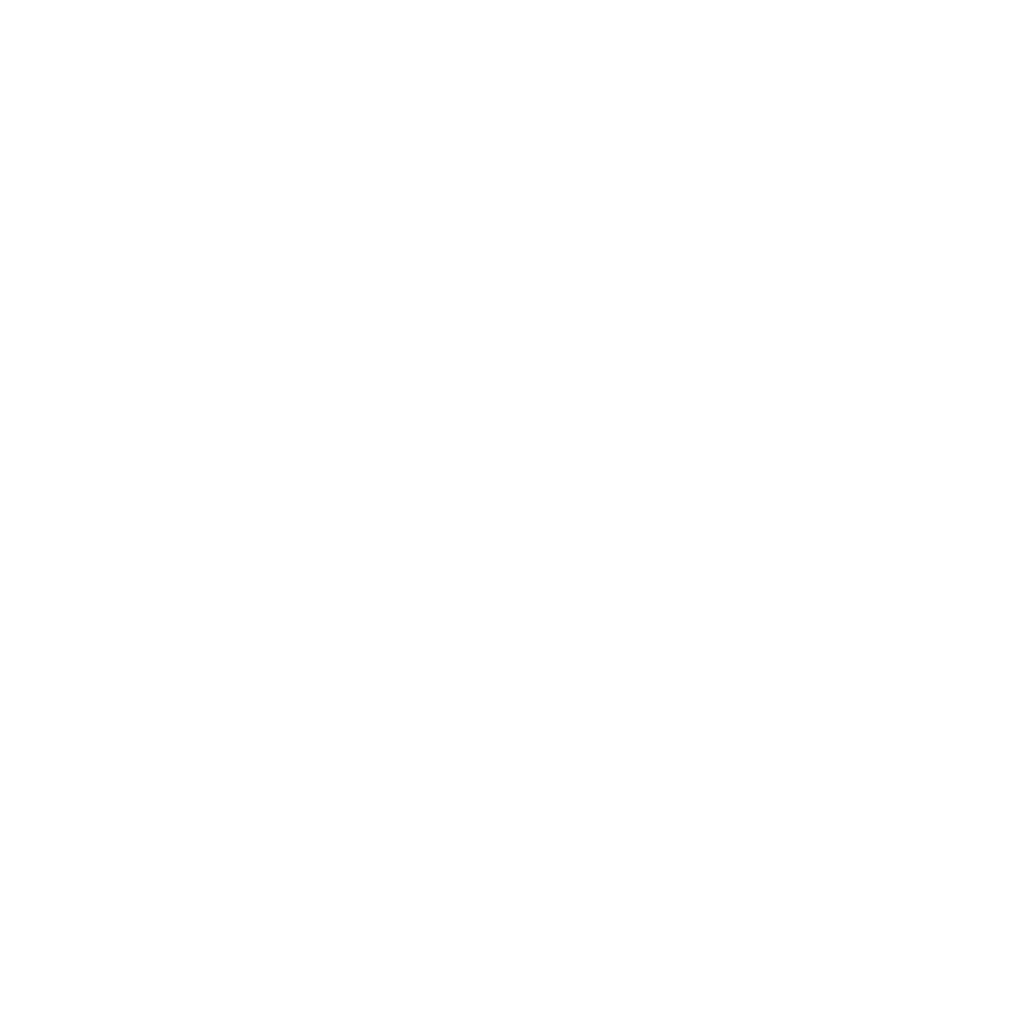

In [5]:
import re
import pandas as pd
import json
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from spacy.matcher import PhraseMatcher

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含人物名称的句子
def extract_sentences_with_names(df, names_dict):
    # 假设人物名称的变体存储在一个字典中，key 为标准名称，value 为变体列表
    all_names = [name for variants in names_dict.values() for name in variants]
    name_sentences = df[df['Sentence'].str.contains('|'.join(all_names))]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 检查共现并打分
def check_cooccurrence_and_score(name_sentences, names_variants_dict, verb_score_dict):
    nlp = spacy.load('en_core_web_sm')  # 加载英文 NLP 模型
    matcher = PhraseMatcher(nlp.vocab)
    for name_variants in names_variants_dict.values():
        patterns = [nlp(name) for name in name_variants]
        matcher.add('Names', None, *patterns)
    G = nx.Graph()
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        doc = nlp(sentence)
        matches = matcher(doc)
        sentence_score = 0
        for match_id, start, end in matches:
            matched_name = doc[start:end].text
            for token in doc:
                if token.text in verb_score_dict:
                    # 这里假设动词出现在两个人物名称之间才算共现
                    if token.head.text == matched_name or token.dep_ == 'conj':
                        sentence_score += verb_score_dict[token.text]
                        for other_match_id, other_start, other_end in matches:
                            if other_match_id != match_id:
                                other_matched_name = doc[other_start:other_end].text
                                G.add_edge(matched_name, other_matched_name, weight=sentence_score)
    return G

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 提取包含人物名称的句子
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')
    name_sentences = extract_sentences_with_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('ROOT_dic_verbs_score.json')

    # 检查共现并打分
    G = check_cooccurrence_and_score(name_sentences, names_variants_dict, verb_score_dict)

    # 绘制网络图
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, font_size=10, node_color='skyblue', node_size=3000, edge_color='black', linewidths=1, arrows=False)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

if __name__ == "__main__":
    main()


In [6]:
import re
import pandas as pd
import json

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    # 假设人物名称的变体存储在一个字典中，key 为标准名称，value 为变体列表
    all_names = [name for variants in names_variants_dict.values() for name in variants]
    name_combinations = [(name1, name2) for name1 in all_names for name2 in all_names if name1 != name2]
    name_sentences = df[df['Sentence'].str.contains('|'.join([f"{name1}.*{name2}|{name2}.*{name1}" for name1, name2 in name_combinations]))]
    return name_sentences

# 读取人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')


    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 打印结果
    print(name_sentences)

if __name__ == "__main__":
    main()


                                               Sentence
0     she keeps me warm\n\nAuthor's Note:\n\nSo, the...
3     It is safe to say that they must've cared for ...
26    Luckily, Riff Raff and Frank were able to fix ...
55    Riff Raff and Magenta never made this a habit ...
65    With playing their parts, come new uniforms fo...
...                                                 ...
1352  Riff Raff wastes no more time and leads Magent...
1375  Magenta decides that might be the latest cutes...
1392  Sign me up!'"\n\n"Old Columbia thinks I'm pret...
1394  What'd old Magenta think about that?"\n\n"She'...
1404  But, it's 6,000+ words of complete Columbia an...

[173 rows x 1 columns]


In [10]:
import re
import pandas as pd
import json

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    # 假设人物名称的变体存储在一个字典中，key 为标准名称，value 为变体列表
    all_names = [name for variants in names_variants_dict.values() for name in variants]
    name_combinations = [(name1, name2) for name1 in all_names for name2 in all_names if name1 != name2]
    name_sentences = df[df['Sentence'].str.contains('|'.join([f"{name1}.*{name2}|{name2}.*{name1}" for name1, name2 in name_combinations]))]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_names = [name for variants in names_variants_dict.values() for name in variants]
    names_in_sentence = [name for name in all_names if name in sentence]
    return names_in_sentence

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('ROOT_dic_verbs_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 提取每个句子中出现的人物名称并打印结果
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

if __name__ == "__main__":
    main()


Sentence: she keeps me warm

Author's Note:

So, the lack of Columbia and Magenta centered fics is more than a little alarming.
Characters: ['Columbia', 'Magenta']
Score: 7

Sentence: It is safe to say that they must've cared for each other at least a little bit, despite Magenta virtually not giving a shit when Riff shoots Columbia with the anti matter gun.
Characters: ['Columbia', 'Magenta', 'Riff']
Score: 13

Sentence: Luckily, Riff Raff and Frank were able to fix up the broken down truck that sat parked and abandoned near the castle.
Characters: ['Frank', 'Riff Raff', 'Riff']
Score: 8

Sentence: Riff Raff and Magenta never made this a habit back home.
Characters: ['Magenta', 'Riff Raff', 'Riff']
Score: 4

Sentence: With playing their parts, come new uniforms for Magenta and Riff Raff.
Characters: ['Magenta', 'Riff Raff', 'Riff']
Score: 11

Sentence: The joke's on Frank, because Riff rather likes his fingerless gloves.
Characters: ['Frank', 'Riff']
Score: 10

Sentence: "Magenta," Fra

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_65843/569262725.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)


In [11]:
import re
import pandas as pd
import json

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    # 假设人物名称的变体存储在一个字典中，key 为标准名称，value 为变体列表
    all_names = [name for variants in names_variants_dict.values() for name in variants]
    name_combinations = [(name1, name2) for name1 in all_names for name2 in all_names if name1 != name2]
    name_sentences = df[df['Sentence'].str.contains('|'.join([f"{name1}.*{name2}|{name2}.*{name1}" for name1, name2 in name_combinations]))]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_names = [name for variants in names_variants_dict.values() for name in variants]
    names_in_sentence = []
    for name in all_names:
        if any(variant in sentence for variant in names_variants_dict[name]):
            names_in_sentence.append(name)
    return names_in_sentence

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('ROOT_dic_verbs_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 提取每个句子中出现的人物名称并打印结果
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

if __name__ == "__main__":
    main()


/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_65843/2971417447.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)


KeyError: 'Brad Majors'

In [12]:
import re
import pandas as pd
import json

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 使用加载人物名称变体的函数
def load_character_variants(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        character_variants = json.load(file)
    return character_variants

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 读取人物名称变体
    names_variants_dict = load_character_variants('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('ROOT_dic_verbs_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 提取每个句子中出现的人物名称并打印结果
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

if __name__ == "__main__":
    main()


Sentence: she keeps me warm

Author's Note:

So, the lack of Columbia and Magenta centered fics is more than a little alarming.
Characters: ['Columbia', 'Magenta']
Score: 7

Sentence: It is safe to say that they must've cared for each other at least a little bit, despite Magenta virtually not giving a shit when Riff shoots Columbia with the anti matter gun.
Characters: ['Columbia', 'Magenta', 'Riff Raff']
Score: 13

Sentence: Luckily, Riff Raff and Frank were able to fix up the broken down truck that sat parked and abandoned near the castle.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: Riff Raff and Magenta never made this a habit back home.
Characters: ['Magenta', 'Riff Raff']
Score: 4

Sentence: With playing their parts, come new uniforms for Magenta and Riff Raff.
Characters: ['Magenta', 'Riff Raff']
Score: 11

Sentence: The joke's on Frank, because Riff rather likes his fingerless gloves.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 10

Sentence: "Magenta

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_65843/1016457838.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)


Sentence: she keeps me warm

Author's Note:

So, the lack of Columbia and Magenta centered fics is more than a little alarming.
Characters: ['Columbia', 'Magenta']
Score: 7

Sentence: It is safe to say that they must've cared for each other at least a little bit, despite Magenta virtually not giving a shit when Riff shoots Columbia with the anti matter gun.
Characters: ['Columbia', 'Magenta', 'Riff Raff']
Score: 13

Sentence: Luckily, Riff Raff and Frank were able to fix up the broken down truck that sat parked and abandoned near the castle.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: Riff Raff and Magenta never made this a habit back home.
Characters: ['Magenta', 'Riff Raff']
Score: 4

Sentence: With playing their parts, come new uniforms for Magenta and Riff Raff.
Characters: ['Magenta', 'Riff Raff']
Score: 11

Sentence: The joke's on Frank, because Riff rather likes his fingerless gloves.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 10

Sentence: "Magenta

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_65843/1858682101.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_65843/1858682101.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


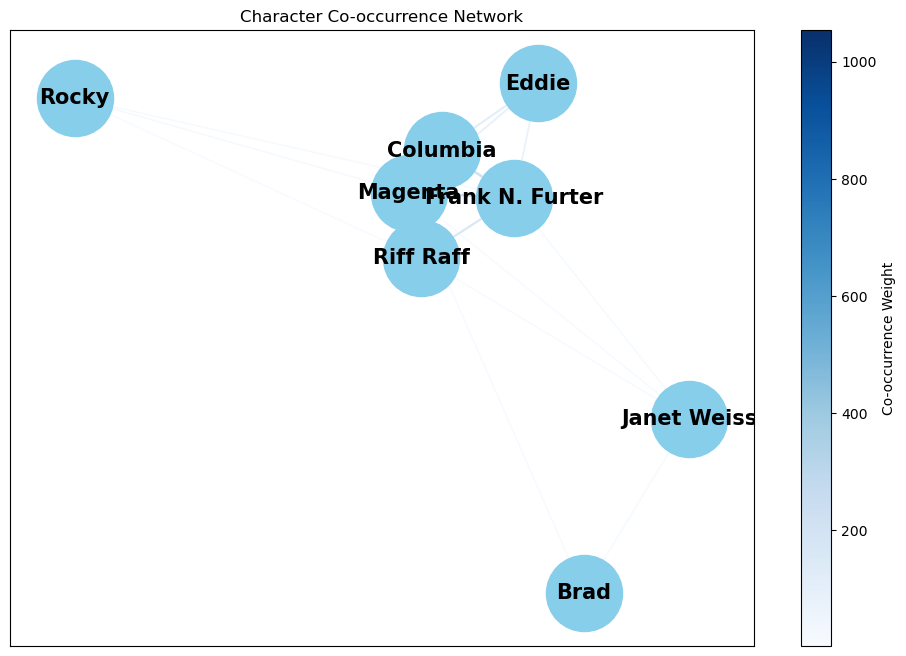

In [21]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='black', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('ROOT_dic_verbs_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##正式开始建网络

In [ ]:
##10608912.txt

Sentence: she keeps me warm

Author's Note:

So, the lack of Columbia and Magenta centered fics is more than a little alarming.
Characters: ['Magenta', 'Columbia']
Score: 4

Sentence: It is safe to say that they must've cared for each other at least a little bit, despite Magenta virtually not giving a shit when Riff shoots Columbia with the anti matter gun.
Characters: ['Riff Raff', 'Magenta', 'Columbia']
Score: 17

Sentence: Luckily, Riff Raff and Frank were able to fix up the broken down truck that sat parked and abandoned near the castle.
Characters: ['Riff Raff', 'Frank N. Furter']
Score: 8

Sentence: Riff Raff and Magenta never made this a habit back home.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: With playing their parts, come new uniforms for Magenta and Riff Raff.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: The joke's on Frank, because Riff rather likes his fingerless gloves.
Characters: ['Riff Raff', 'Frank N. Furter']
Score: 14

Sentence: "Magenta

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/425109284.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/425109284.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


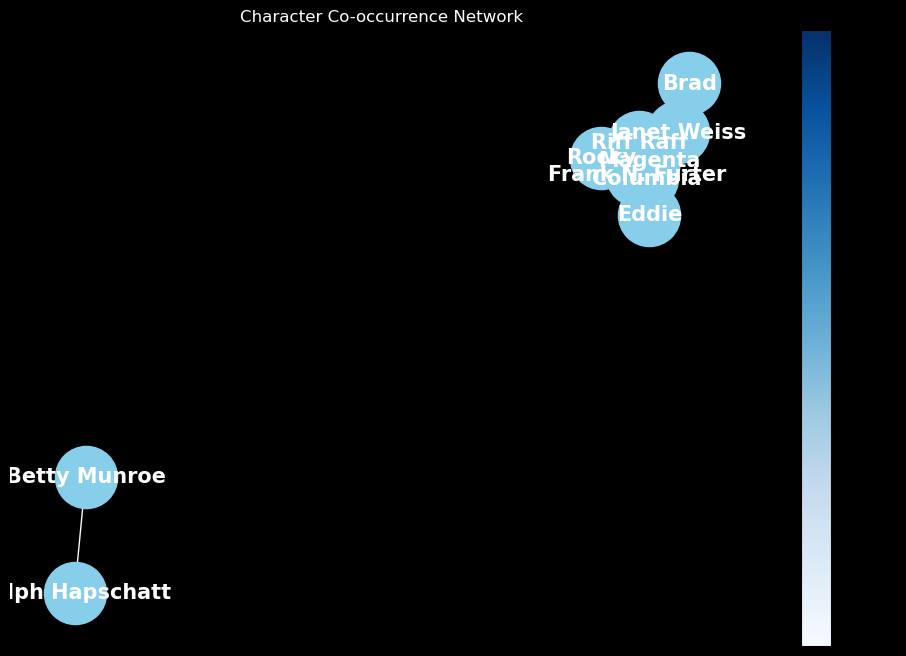

In [3]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [4]:
##10777800.txt， 文章内基本上都是代词。

In [5]:
import re
import pandas as pd
import json

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用更适合的句子分割方式
    sentences = re.split(r'(?<=[.!?]) +', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10777800.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 打印结果
    print(name_sentences)

if __name__ == "__main__":
    main()


Empty DataFrame
Columns: [Sentence]
Index: []


In [ ]:
##1060979.txt

Sentence: Magenta would become the woman of the house, ordering Riff Raff about as if he were her child in some games, servant in others, and every once in a while her husband.
Characters: ['Riff Raff', 'Magenta']
Score: 8

Sentence: Riff Raff told her siblings did not get married, but she simply said, "But who else vould I marry?" Riff Raff laughed this off, knowing his sister didn't entirely understand love and marriage.
Characters: ['Riff Raff']
Score: 23

Sentence: Riff Raff and Magenta looked at each other, but stood and followed her.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: They pretended Frank was their baby, and he and Magenta were his loving parents.
Characters: ['Magenta', 'Frank N. Furter']
Score: 0

Sentence: They placed Frank in Magenta's tank.
Characters: ['Magenta', 'Frank N. Furter']
Score: 0

Sentence: Magenta liked the feeling of Riff Raff's heart beat.
Characters: ['Riff Raff', 'Magenta']
Score: 14

Sentence: Summary for the Chapter:


"Magenta" Riff 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/2763923437.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/2763923437.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


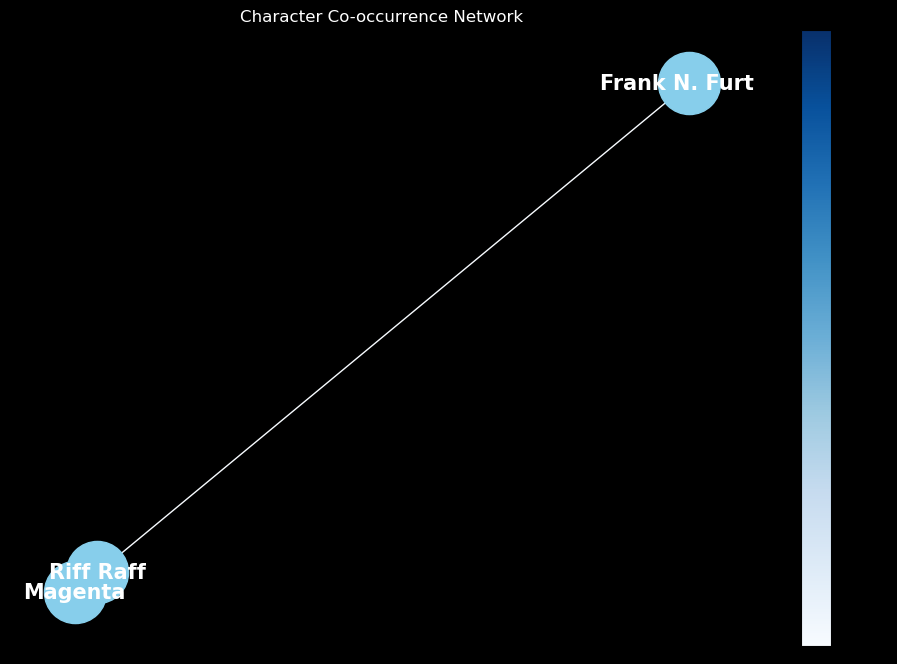

In [6]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1060979.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##1061993.txt

Sentence: I was reduced to servant level

With Riff Raff and Magenta.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: "This is Columbia my dear Riff Raff.
Characters: ['Riff Raff', 'Columbia']
Score: 0

Sentence: "Magenta do introduce yourself." Frank finally said lazily from my side.
Characters: ['Magenta', 'Frank N. Furter']
Score: 4

Sentence: "Columbia you must be awfully tired, why don't you have Magenta show you to your room?"

"Vhich room sir?" Magenta the Domestic asked.
Characters: ['Magenta', 'Columbia']
Score: 16

Sentence: Suddenly Riff Raff came into the room and lay down next to Frank, wordlessly, they began to have sex.
Characters: ['Riff Raff', 'Frank N. Furter']
Score: 12

Sentence: Riff Raff had gone into town for supplies- I asked Frank why they needed supplies so soon after he'd been out, but he told me they were "different sorts." So I dropped it- and he'd gotten some tap shoes I'd asked for!
Characters: ['Riff Raff', 'Frank N. Furter']
Score: 17

Sentence

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/1070401404.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_99085/1070401404.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


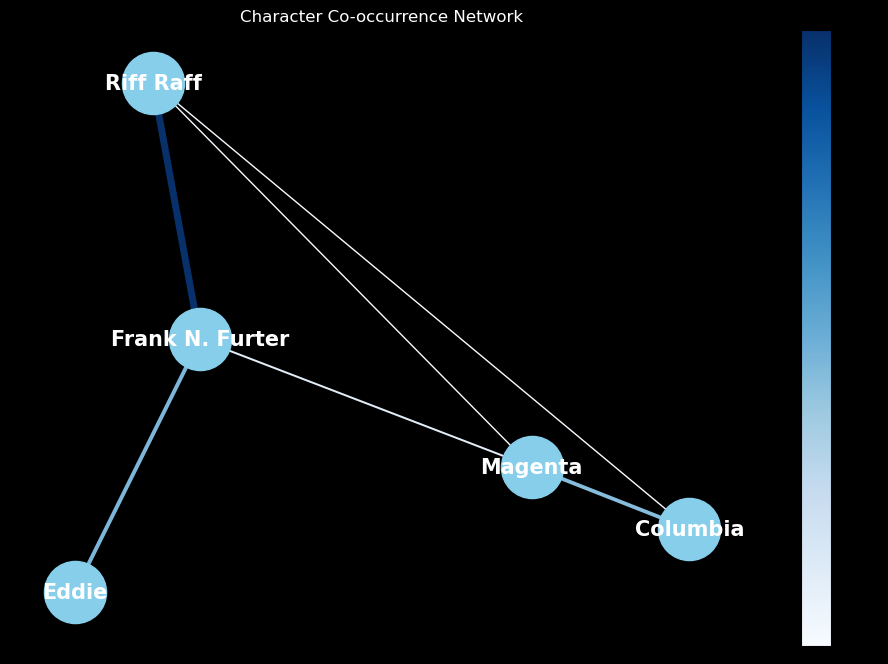

In [7]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1061993.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##10748502.txt

Sentence: He did feel a slight pang of guilt for murdering Rocky and Columbia.
Characters: ['Rocky', 'Columbia']
Score: 1

Sentence: More for Columbia than Rocky.
Characters: ['Rocky', 'Columbia']
Score: 0

Sentence: Rocky's death had a reason, he was never actually meant to exist for any other purpose than what Frank had created him for.
Characters: ['Frank N. Furter', 'Rocky']
Score: 4

Sentence: Riff'd did what he thought was right; by removing the abomination that Frank'd created from existence.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 1

Sentence: It would be a bit of an eerie scene (not that it wasn't one already) for anyone other than the people who were remaining in the house when Magenta had disposed of Eddie's body through waste disposal or when they guest had eaten part of the poor boy or if they knew there were three deceased bodies rotting within the castle when they arrived at Transexual.
Characters: ['Eddie', 'Magenta']
Score: 12

Sentence: Riff knew, out of a

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/301878717.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/301878717.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


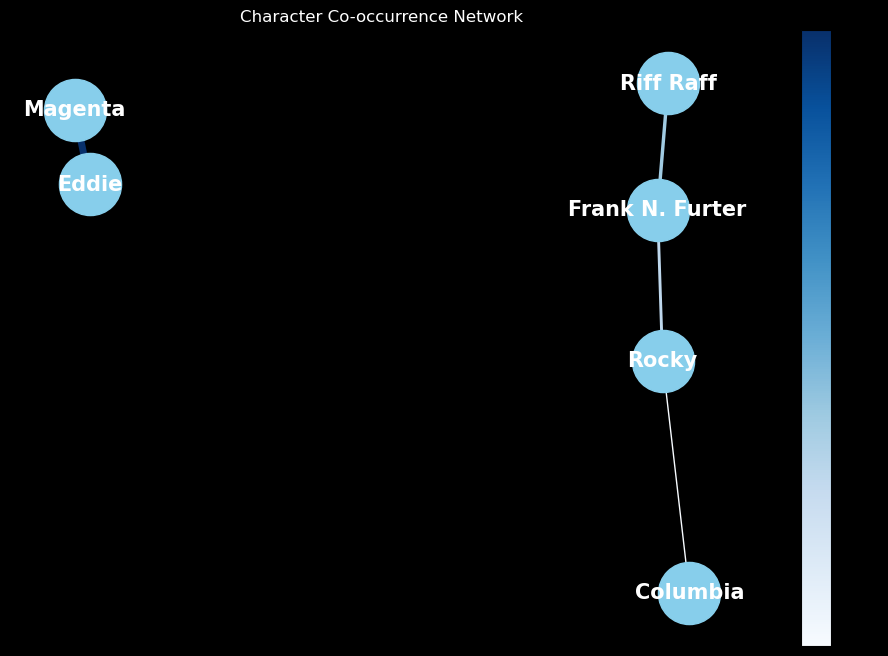

In [5]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10748502.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##10777800.txt

In [8]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text  # 返回文本内容


def split_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text)
# 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10777800.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


TypeError: string indices must be integers, not 'str'

In [ ]:
##错误原因，文章中全是代词。

Sentence: ” Brad yelled, pushing Frank off of him in confusion and anger.
Characters: ['Frank N. Furter', 'Brad']
Score: 7

Sentence: “I’m afraid so, Brad,” Frank replied, dropping his imitation of Janet as he leaned over the other man.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 6

Sentence: “Never.”

“Oh, yes, I know,” Frank replied, leaning in close to Brad and pressing his forehead against his.
Characters: ['Frank N. Furter', 'Brad']
Score: 14

Sentence: Brad shivered, too caught off guard to say anything as Frank continued.
Characters: ['Frank N. Furter', 'Brad']
Score: 7

Sentence: “Oh...no, stop, stop, no---” Brad tried to protest, but he cut himself off with another helpless moan as Frank kissed just below his belly button.
Characters: ['Frank N. Furter', 'Brad']
Score: 11

Sentence: ”

Frank removed himself from Brad’s stomach and looked up very suddenly, holding out one finger and pressing it against Brad’s lips.
Characters: ['Frank N. Furter', 'Brad']
Score

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2698943560.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2698943560.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


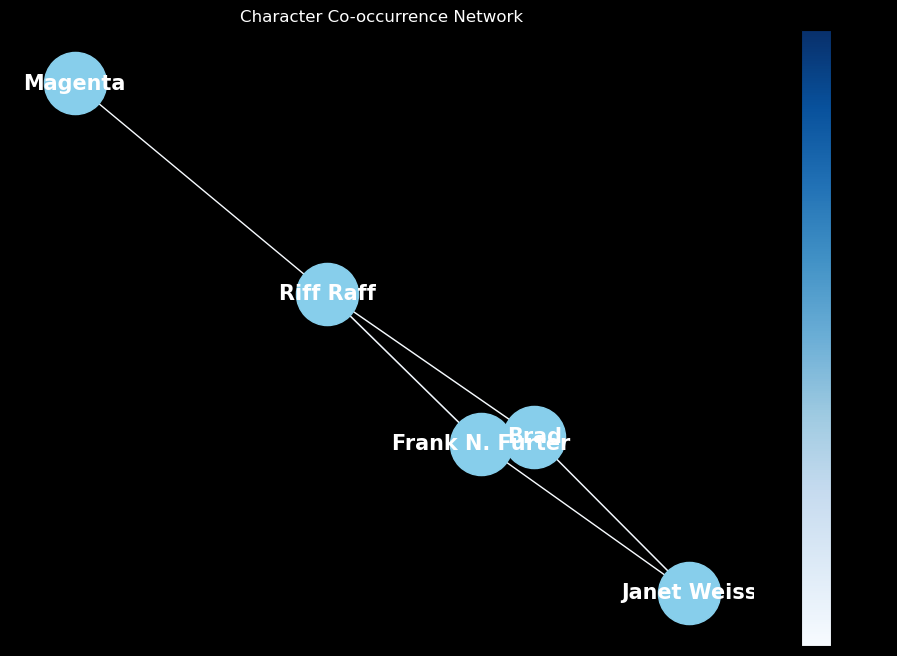

In [9]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/11213277.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##12090570.txt

Sentence: And so we danced together, and me and Magenta danced together, and me and Frank danced together, and me and Riff Raff even danced together (that’s the beanie guy’s name) and the food was so good and I had a great time.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 8

Sentence: And now that I think about it, Magenta was still fast asleep when I left the room...she must have partied too hard :) But Eddie was awake, so me and him ate breakfast together.
Characters: ['Eddie', 'Magenta']
Score: 17

Sentence: We all ate ‘breakfast’ together, then Frank told us to get dressed (though this was probably more for Magenta and Riff Raff’s sake) and then meet him on the third floor.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 8

Sentence: Magenta and Riff Raff had been putting in work, of course, but there was simply not enough manpower to go around.
Characters: ['Riff Raff', 'Magenta']
Score: 16

Sentence: Frank must have thought me and Eddie were some

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3437922771.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3437922771.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


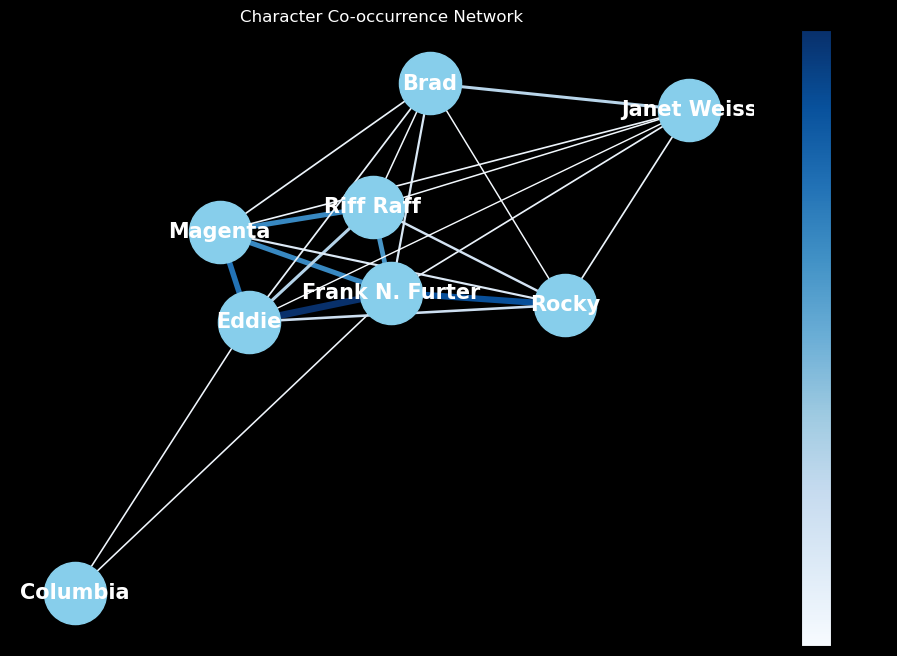

In [10]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/12090570.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##12787710.txt

Sentence: Life isn't all Gold Sequins and Bow Ties

As Riff Raff approaches Frank, threatening him with his laser, it is as if a wave crashes over me.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: I can see all of them- Riff Raff, Magenta, and the humans- talking, but I cannot hear what they are saying.
Characters: ['Riff Raff', 'Magenta']
Score: 11

Sentence: Before I can stop myself, I scream for Frank, and Riff Raff whips around towards me.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 7

Sentence: Riff Raff and Magenta were both busy doing… well, each other, so I got the door.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: Even more quickly than it happened in real life, Frank and Eddie were gone into the master bedroom, and I was left holding a quickly cooling pizza box.
Characters: ['Frank N. Furter', 'Eddie']
Score: 12

Sentence: The memories slow down to play the day that Frank had the idea to create Rocky.
Characters: ['Frank N. Furter', 'Ro

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2427157713.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2427157713.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


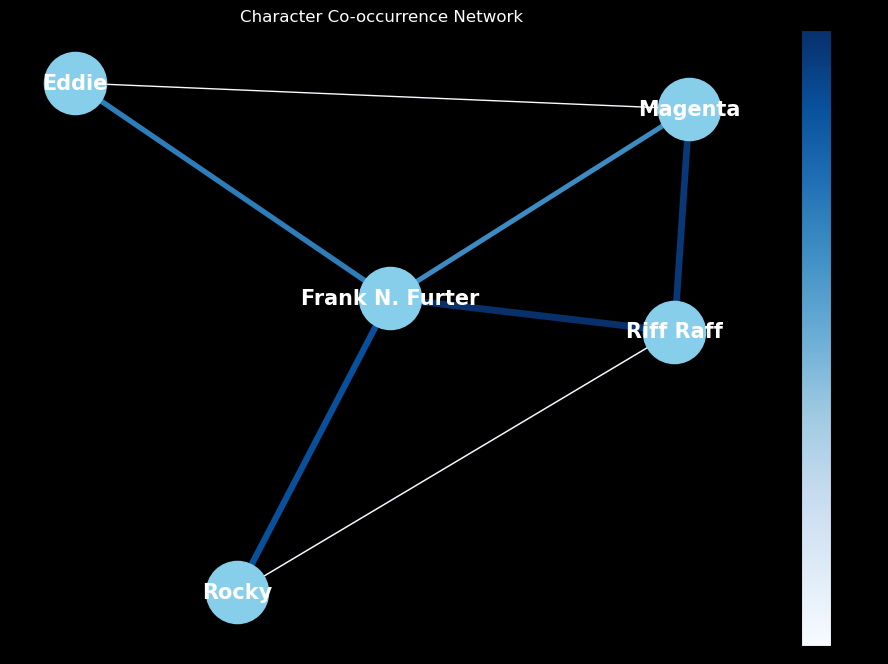

In [11]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/12787710.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##13917528.txt

Sentence: "I trust Magenta and Riff Raff will show you around, I have something I must attend to" he seductively whispers as he steps onto the metal elevator and presses a button.
Characters: ['Riff Raff', 'Magenta']
Score: 19

Sentence: You are faintly aware of the hushed laughter of Magenta and Riff Raff from a distance, but you are too drunk to care at this point as you begin to get on your knees, again not trusting yourself to fully stand up yet.
Characters: ['Riff Raff', 'Magenta']
Score: 19

Sentence: Columbia and Magenta are wearing pink surgical masks and white aprons, and you notice a large rectangular looking structure behind him.
Characters: ['Columbia', 'Magenta']
Score: 6

Sentence: Riff Raff gently nudges you out of the elevator and Frank struts up to greet you once again.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: While Magenta and Riff Raff look bored as always, you notice Columbia's eyes are practically as wide as yours as she releases a sigh when

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3561325698.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3561325698.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


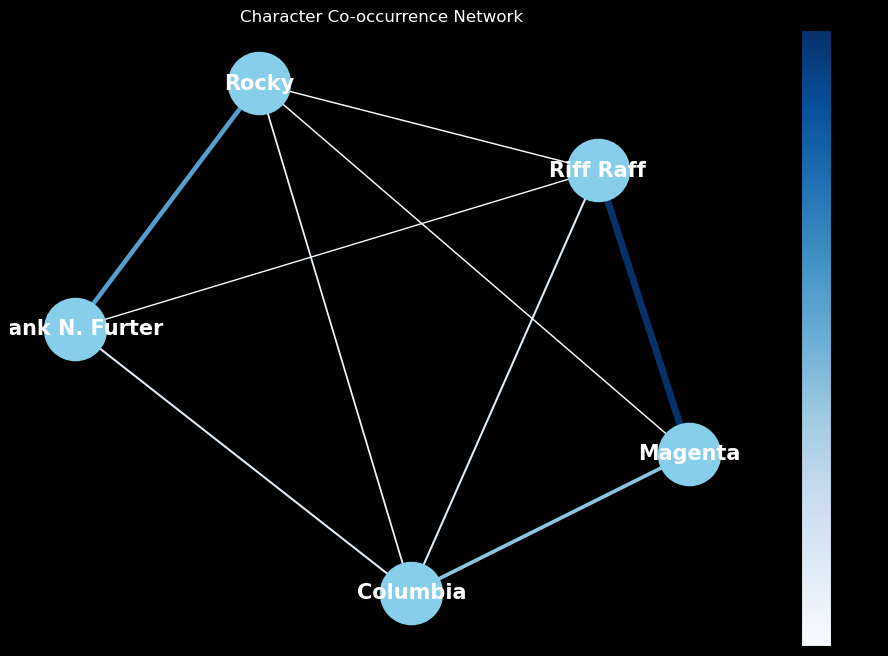

In [12]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/13917528.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##13979313.txt

Sentence: I'm in a production of Rocky Horror and I play my favorite weirdo handyman -- Riff-Raff!
Characters: ['Rocky', 'Riff Raff']
Score: 12

Sentence: Yes, we called each other "bro" and "sis" before we started dating, oof.) Columbia has always been my favorite character and I YEARN for her fuckin' motivation for staying with Frank as long as she does, especially after she gets tossed aside not once, but twice.
Characters: ['Frank N. Furter', 'Columbia']
Score: 27

Sentence: “Kinda crummy,” Eddie continues, “that we can’t leave.”

“Frankie’s got his rules,” Columbia says immediately.
Characters: ['Frank N. Furter', 'Columbia', 'Eddie']
Score: 19

Sentence: Like Eddie says, Frank doesn’t let them leave the castle grounds.
Characters: ['Frank N. Furter', 'Eddie']
Score: 15

Sentence: XXX

Okay, so Columbia likes Eddie.
Characters: ['Columbia', 'Eddie']
Score: 5

Sentence: XXX

So Frank starts to take Eddie away a lot.
Characters: ['Frank N. Furter', 'Eddie']
Score: 4

Sentence: XXX



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2466553345.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2466553345.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


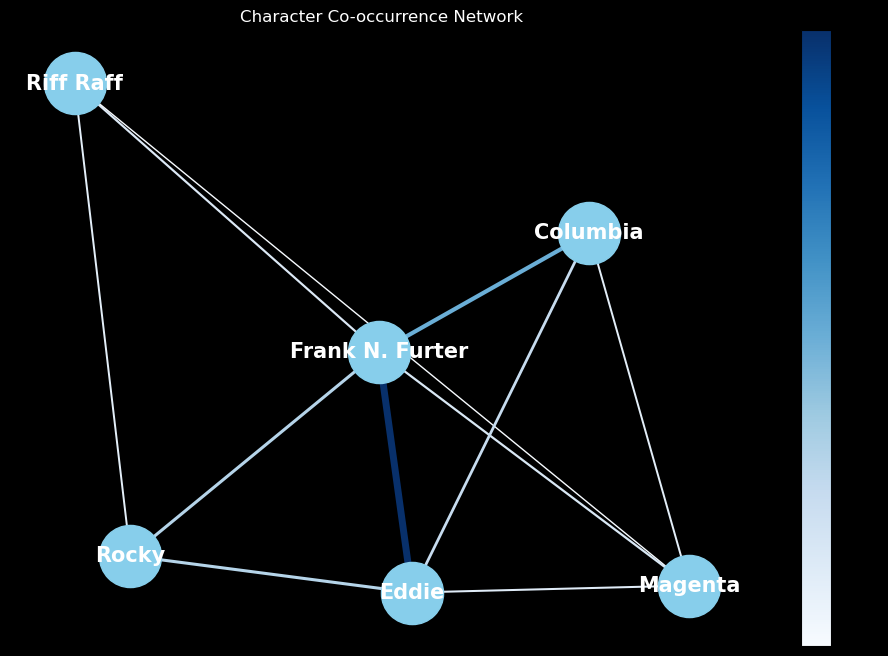

In [13]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/13979313.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##1409260.txt

Sentence: "So, what now, BradandJanet?" he drawls, slurring their names into one word like they are two parts of the same whole.
Characters: ['Janet Weiss', 'Brad']
Score: 9

Sentence: for fun around here?"

“Work, eat, sleep, maybe go down the cinema,” Brad supplies, and Frank sighs loudly.
Characters: ['Frank N. Furter', 'Brad']
Score: 15

Sentence: After the death of tiny, dainty, delicious Columbia and of Rocky, Frank’s beloved creation - well.
Characters: ['Frank N. Furter', 'Rocky', 'Columbia']
Score: 5

Sentence: She’d been sure Riff Raff and Magenta had killed him, and she was sure they’d thought so too, but the antimatter beam had killed Doctor Scott instead.
Characters: ['Riff Raff', 'Magenta']
Score: 5

Sentence: Frank hadn’t been the only one crying as they’d left; Brad had tears sliding down his cheeks from the loss of his beloved tutor, but her?
Characters: ['Frank N. Furter', 'Brad']
Score: 11

Sentence: She makes Frank a bed out of the couch and a couple of blankets and

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1816340725.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1816340725.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


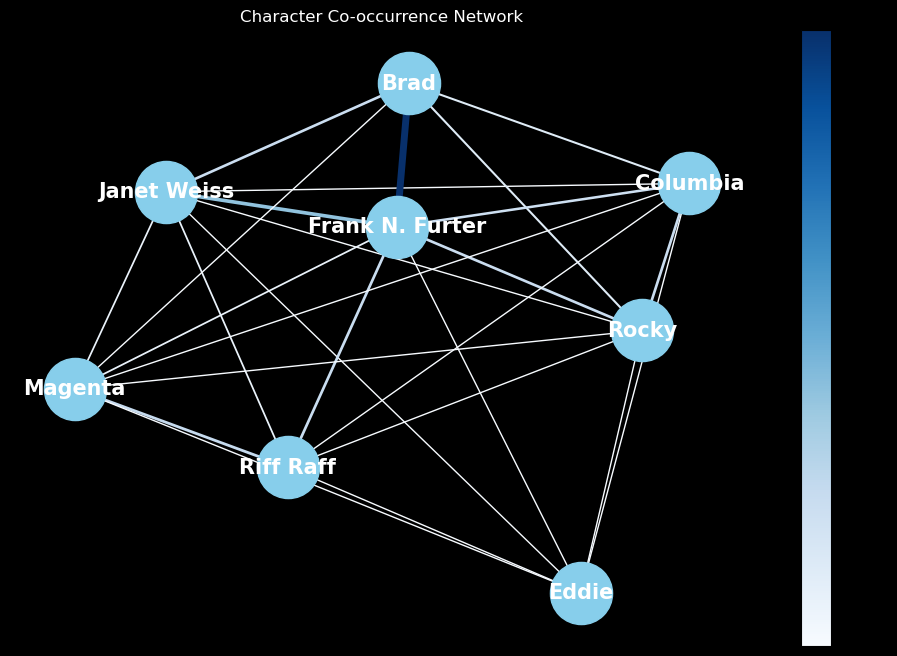

In [14]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1409260.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##14427576.txt

Sentence: "Thank you Riff Raff," Frank threw his jacket on him as he walked into the castle.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: Columbia politely smiled at him and followed Frank inside.
Characters: ['Frank N. Furter', 'Columbia']
Score: 6

Sentence: "Now, Magenta, that's no way to treat a guest!" Frank scolded.
Characters: ['Frank N. Furter', 'Magenta']
Score: 4

Sentence: Columbia apologized to Magenta and followed Frank through the castle to his room where she would stay for the night.
Characters: ['Frank N. Furter', 'Columbia', 'Magenta']
Score: 12

Sentence: Columbia couldn't keep her mind off of Magenta for the rest of the night.
Characters: ['Columbia', 'Magenta']
Score: 4

Sentence: "Well, it was OK, I guess," Columbia shrugged Frank's question off.
Characters: ['Frank N. Furter', 'Columbia']
Score: 5

Sentence: "Oh, nothing, Frankie." Frank was feeling heated about Columbia having the audacity to tell him that his pleasure was only OK and she was 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2013095488.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2013095488.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


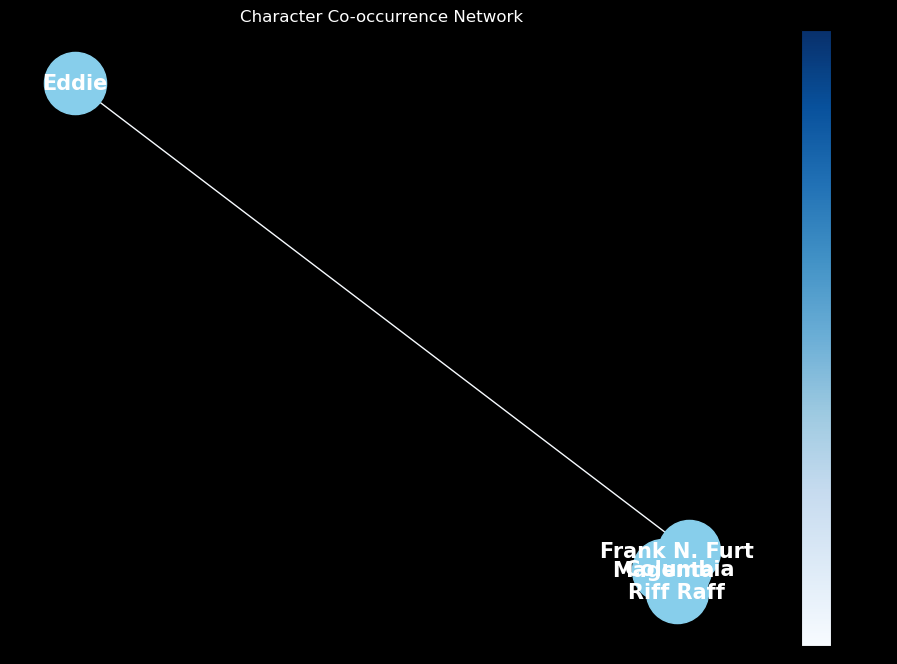

In [15]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/14427576.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##14718293.txt

Sentence: When I land, I try to get away, but two other people come over (Magenta and Columbia, how do I know this?) and start taking off what is wrapped around me.
Characters: ['Columbia', 'Magenta']
Score: 24

Sentence: Frank, Riff Raff, Magenta, and Columbia talk, and Columbia says something to anger Frank.
Characters: ['Frank N. Furter', 'Columbia', 'Riff Raff', 'Magenta']
Score: 11

Sentence: Frank puts his arm around me and talks to them, during which I hear him call them Brad and Janet.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 15

Sentence: I’m shocked into stopping when Frank begins to chase Eddie with a pickaxe.
Characters: ['Frank N. Furter', 'Eddie']
Score: 4

Sentence: Frank walks back out, drops the pickaxe, and has Magenta take off his bloody gloves.
Characters: ['Frank N. Furter', 'Magenta']
Score: 21

Sentence: Riff Raff and Magenta open a curtain, revealing a room that is mostly taken up by a bed.
Characters: ['Riff Raff', 'Magenta']
Score: 8

Sent

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/728132864.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/728132864.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


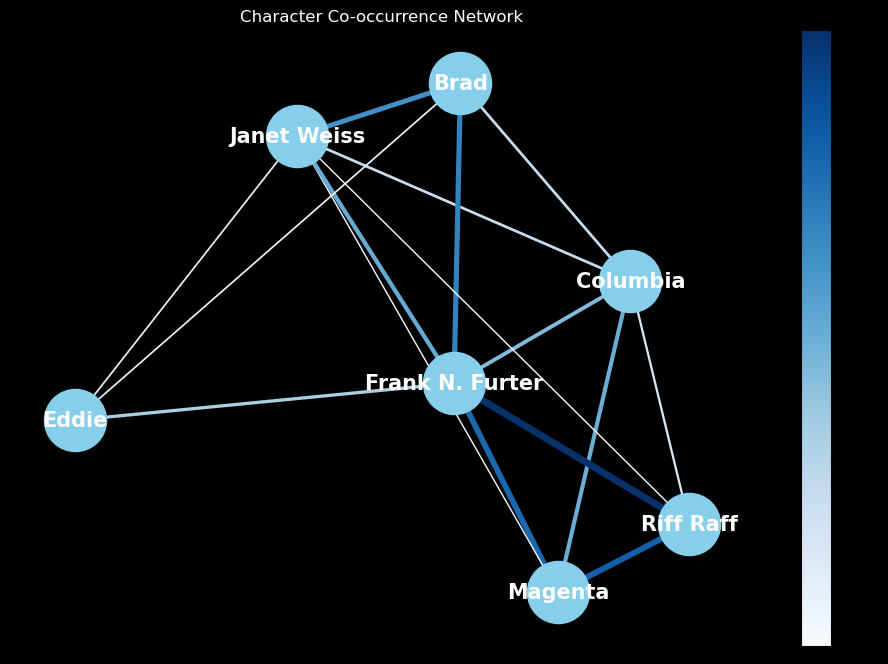

In [16]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/14718293.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##1578.txt

Sentence: They disguised themselves as a humpbacked
butler named Riff Raff and an attractive maid called Magenta.
Characters: ['Riff Raff', 'Magenta']
Score: 7

Sentence: Frank tried once, unsuccessfully, to seduce Magenta.
Characters: ['Frank N. Furter', 'Magenta']
Score: 0

Sentence: Besides, in his own way, Frank wanted to meet and speak with intelligent
people, and Riff Raff and Magenta (to the best of his knowledge) just didn't
fit the bill.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 7

Sentence: "Columbia really suits you much better," Frank murmured, moving closer.
Characters: ['Frank N. Furter', 'Columbia']
Score: 7

Sentence: Frank directed his attention back to Columbia.
Characters: ['Frank N. Furter', 'Columbia']
Score: 0

Sentence: "I came to see if you were all right."

"I -- I was just going for some warm -- that is, I'm quite well, thank you."

Frank advanced, and Columbia backed into the bedpost.
Characters: ['Frank N. Furter', 'Columbia']
Score: 9



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2744325792.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2744325792.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


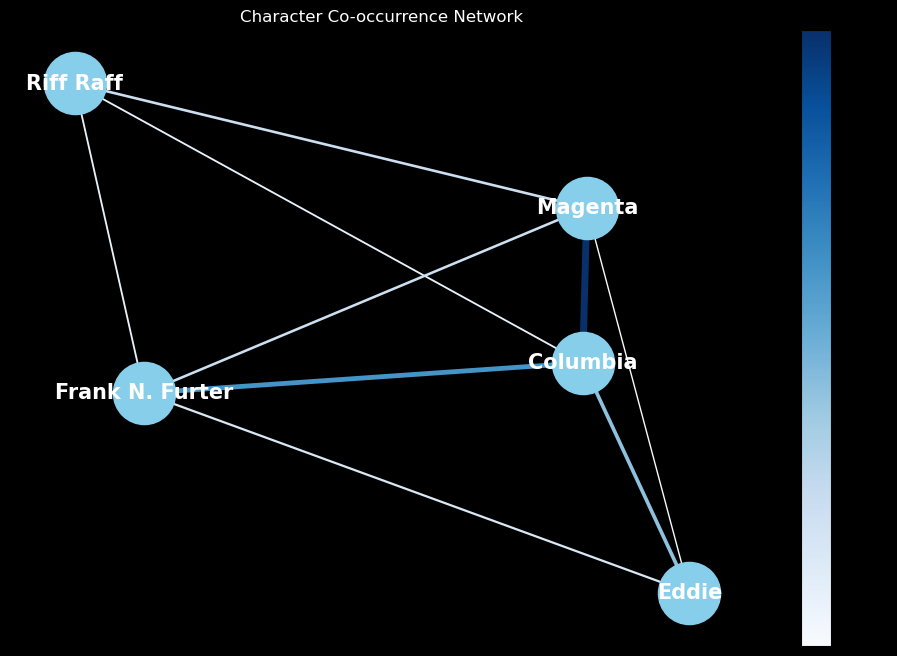

In [17]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1578.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##1579100.txt

Sentence: Janet: I met Brad Majors from Denton High about two years ago and he told me he was straight and we hit it off right away.
Characters: ['Janet Weiss', 'Brad']
Score: 9

Sentence: Magenta: Now I'm standing in the dining room carving up the meatloaf for dinner in storms my brother Riff Raff in a jealous rage.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: My lover Rocky and I used to do everything together and this bitch, Janet, used to hang around with us.
Characters: ['Janet Weiss', 'Rocky']
Score: 25

Sentence: I come back, open the door, and there's Rocky and Janet doing number 17: The Pearl Necklace.
Characters: ['Janet Weiss', 'Rocky']
Score: 12

Sentence: On the way, he found Eddie, Janet, Brad, and Rocky.
Characters: ['Janet Weiss', 'Rocky', 'Eddie', 'Brad']
Score: 0



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1808278286.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1808278286.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


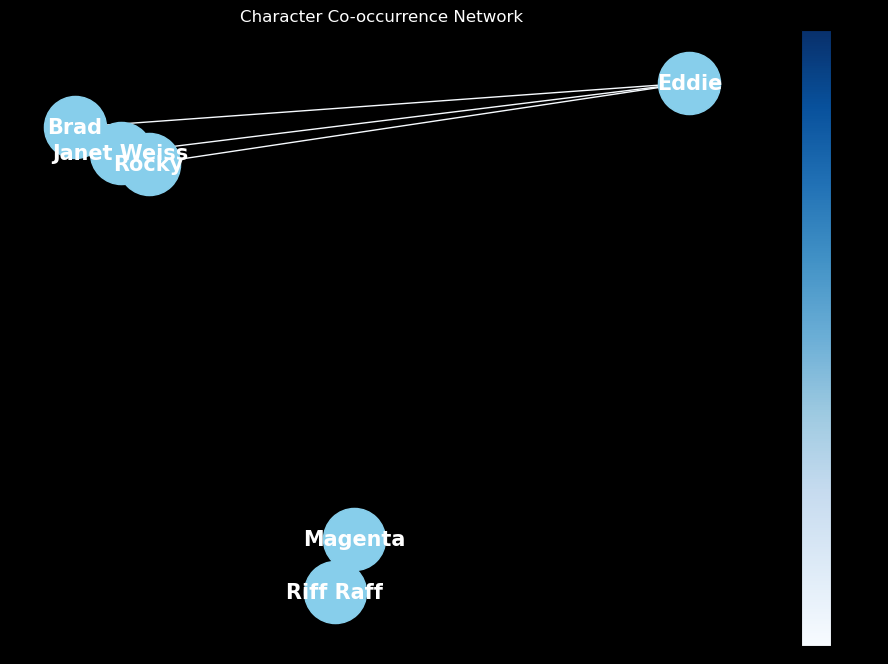

In [18]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1579100.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##15950534.txt

Sentence: When Riff Raff sat on the end of the bed to tie his shoelaces Magenta crawled up behind him and linked her legs around his waist and pressed her cheek into his back.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: “Get yourself made up and then go wake Columbia.” Riff said to his sister, gently prying her legs apart so he could get up.
Characters: ['Columbia', 'Riff Raff']
Score: 8

Sentence: Magenta strutted down the corridor toward the room where Columbia slept.
Characters: ['Columbia', 'Magenta']
Score: 4

Sentence: Magenta crossed the cluttered floor and sat down on Columbia’s bed.
Characters: ['Columbia', 'Magenta']
Score: 8

Sentence: Columbia took hold of Magenta’s face and pulled her in for a playful kiss.
Characters: ['Columbia', 'Magenta']
Score: 25

Sentence: While Magenta was mindlessly dusting the banister of the main staircase Riff Raff passed her as he carried boxes down the stairs.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: “What are yo

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4270976299.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4270976299.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


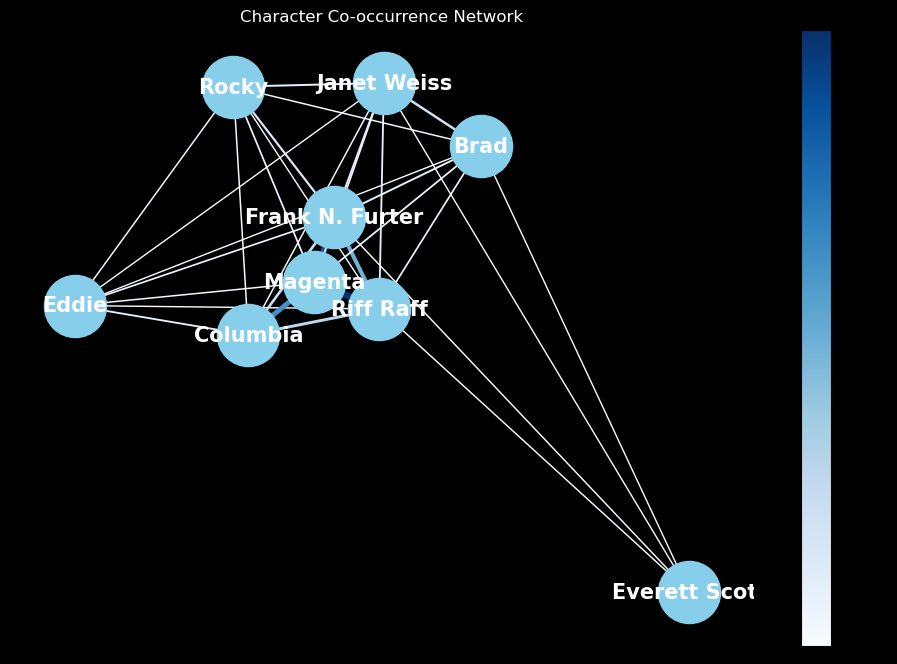

In [19]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/15950534.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##1749797.txt

Sentence: A story of the events of the castle leading up to the movie mainly revolving around Riff Raff and Magenta as always but also focusing a lot on Columbia and Eddie.
Characters: ['Columbia', 'Eddie', 'Magenta', 'Riff Raff']
Score: 8

Sentence: Riff Raff and Magenta had always spent large amounts of time together but sometimes they found their frustration at the living situation on a distant unknown planet coming out on one other.
Characters: ['Riff Raff', 'Magenta']
Score: 20

Sentence: So until they deemed themselves ready for complete earthling contact or Frank just got bored of the current situation, Riff Raff, Magenta and Frank were stuck in this castle that seemed absurdly smaller everyday for the unforeseeable future.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 20

Sentence: In the large pink tiled laboratory Riff Raff sat at the oak desk toying with sketches and diagrams for the experiment while Frank sat on the edge of the desk, legs crossed watching h

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/26052871.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/26052871.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


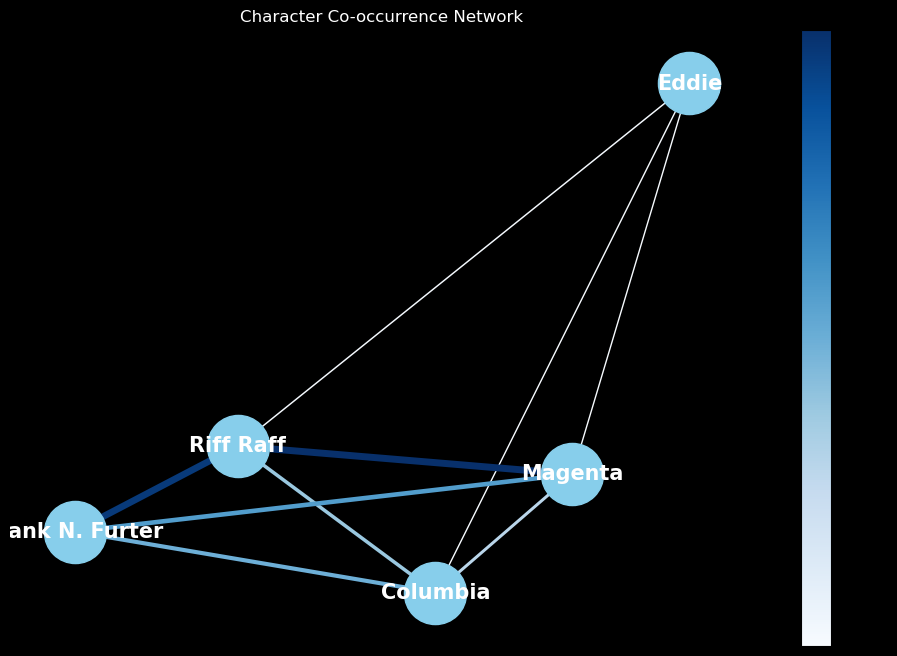

In [20]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/1749797.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##18528691.txt

Sentence: Freak

Author's Note:

AN: Because I’ve grown recently very much attached to Brad/Janet/Frank as an OT3 and I need more fanfiction action with them, so I thought I’d just write one myself!
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 14

Sentence: Frank is everything that Brad wishes to be… Well no, maybe not in the same way exactly, but in the sense that Frank is so free and doesn’t care who knows it.
Characters: ['Frank N. Furter', 'Brad']
Score: 18

Sentence: Brad remembers too, the man breaking down in tears, his loneliness and vulnerability clear on his face, realizing; again and again, as he watched the scene from afar – as he gripped Janet like a lifeline.
Characters: ['Janet Weiss', 'Brad']
Score: 20



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4026246205.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4026246205.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


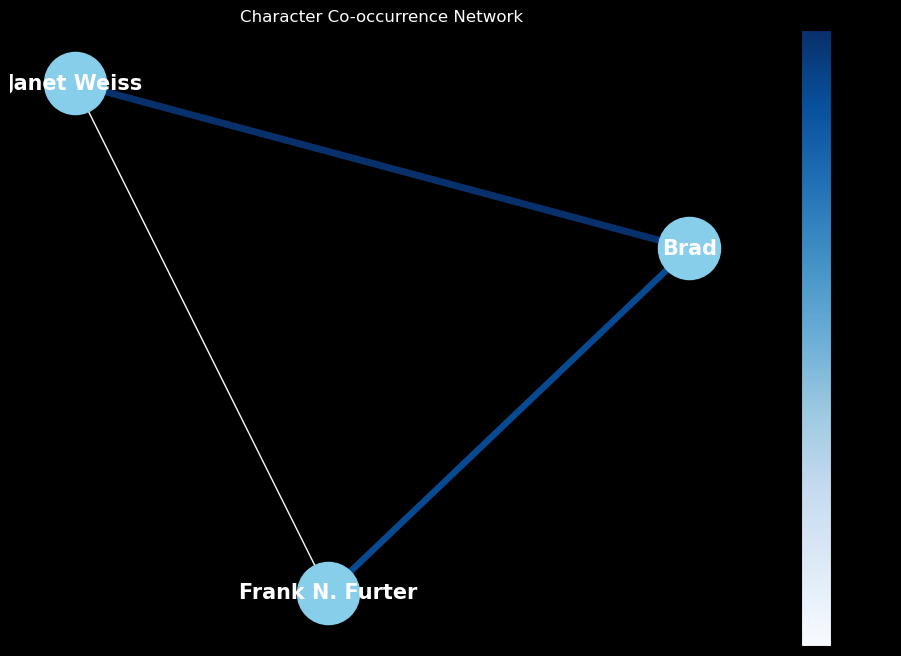

In [21]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/18528691.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##19183975.txt

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2461756356.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2461756356.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


Sentence: “Magenta, and my brother, Riff Raff.”

She really didn’t know why she thought this, and she immediately felt sick with guilt that she was being territorial at a time like this, but only one word ran through her mind in response to Magenta’s statement.
Characters: ['Riff Raff', 'Magenta']
Score: 10

Sentence: Her hands were taken hostage again, Magenta and Riff Raff each taking a wrist and all but dragging her out the doorway once again.
Characters: ['Riff Raff', 'Magenta']
Score: 8

Sentence: Kay didn’t recognize the voice; it didn’t belong to Magenta or Columbia.
Characters: ['Columbia', 'Magenta']
Score: 0

Sentence: “I mean, Columbia sounds like she’s from somewhere further North than here, but Magenta sounds like she’s from somewhere in Europe.
Characters: ['Columbia', 'Magenta']
Score: 5

Sentence: “Columbia is not part of our team; she was just picked up by the master and formed a relationship with Magenta.
Characters: ['Columbia', 'Magenta']
Score: 4

Sentence: As soon

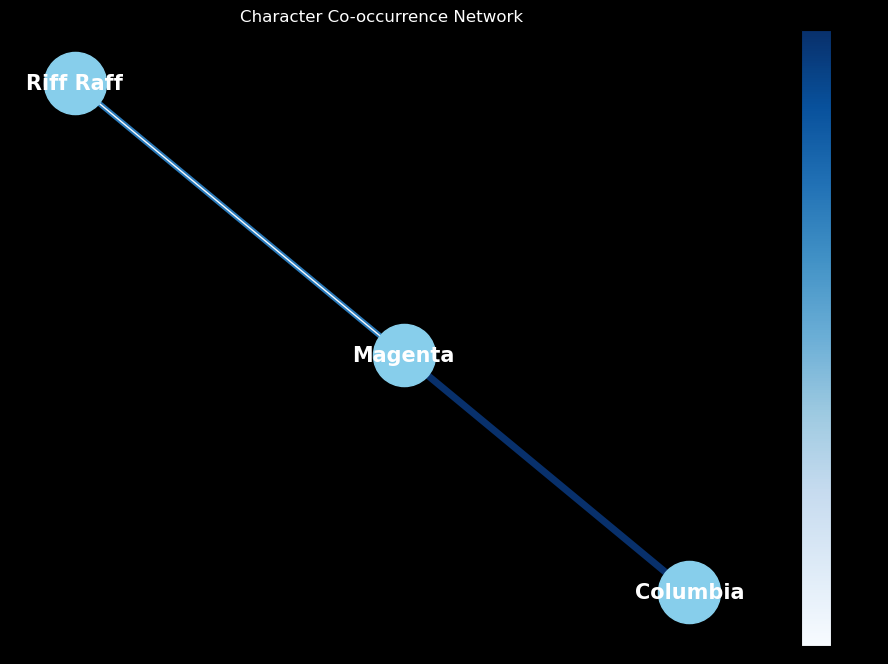

In [22]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/19183975.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##19480177.txt

Sentence: The first person and only person Riff Raff had ever loved was Magenta, from the moment they were conscious of what love was, they were one being.
Characters: ['Riff Raff', 'Magenta']
Score: 5

Sentence: Magenta had pinned Riff Raff by the wrists for the first time when he was five and she was seven.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: When the Academy had learned of their bond, days in when an older creature had shoved Riff Raff to the floor in the training rooms and Magenta went red with rage and attempted to claw the poor soul’s eyes out, they had it contracted not to seperated.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: Riff Raff and Magenta lived out their young and reckless days on missions across the galaxies, learning self preservation strategies that would save their lives a thousand times over.
Characters: ['Riff Raff', 'Magenta']
Score: 9

Sentence: Riff Raff remembered Magenta’s ranting as they had packed what belongings they were

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3187645304.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3187645304.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


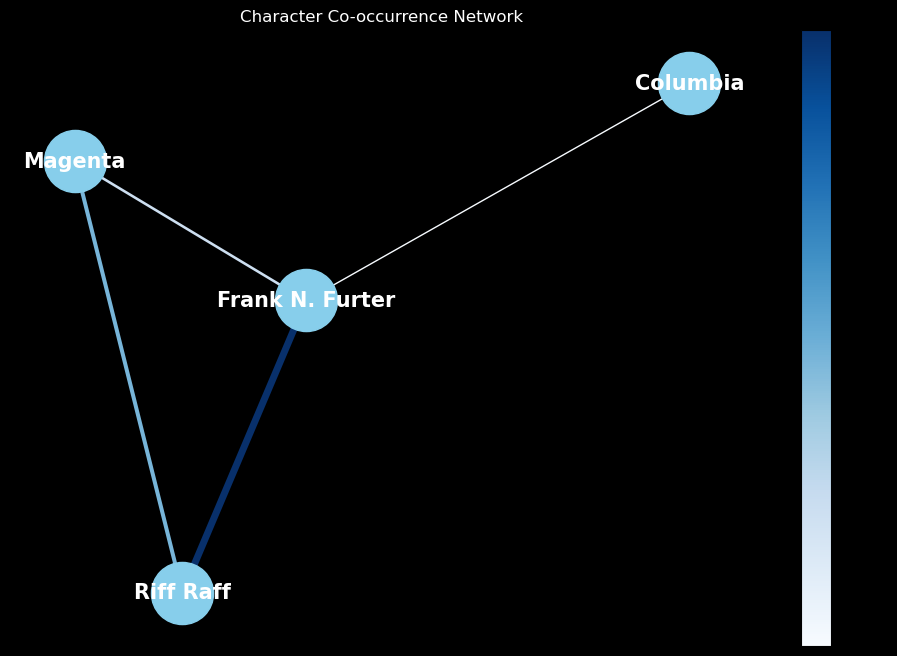

In [23]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/19480177.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##20649923.txt

Sentence: When Brad was twenty-five, a few hours after he had finally proposed to Janet, he met Dr.
Characters: ['Janet Weiss', 'Brad']
Score: 4

Sentence: He learned that their host's name was Frank and that seeing Janet in only a bra from the middle up did nothing for his libido.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: Frank was covered again (Thank God!), his guests looked from above like the two stranded outsiders were goldfish and the room didn't remind Brad in the least the laboratories he was familiar with.
Characters: ['Frank N. Furter', 'Brad']
Score: 13

Sentence: So he grabbed Frank's hand with more force than necessary and the aggression he let loose made him pronounce Janet's surname wrong, yell at Frank for not giving him a phone so he could be far away from these conflicting feelings and generally make a fool of himself.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 17

Sentence: The worst part was that Frank and Janet got along swimmin

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3420801592.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3420801592.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


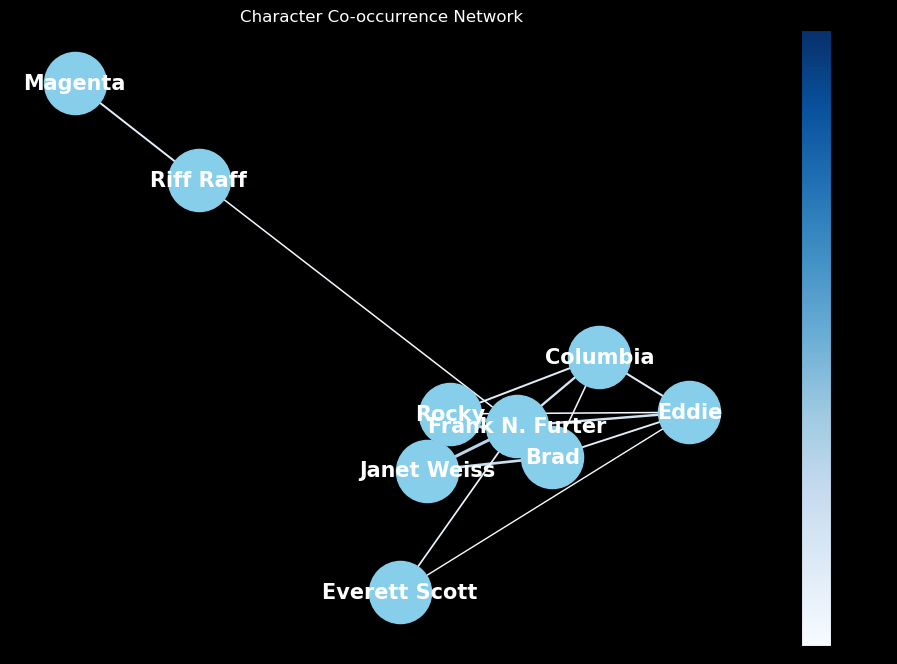

In [24]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/20649923.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##20841947_txt.txt

Sentence: “Just as long as you don’t ruin yours, too.”






Biting/Crossdressing (Frank N Furter/Brad Majors; Rocky Horror Picture Show)


Chapter Summary


This is indeed Rocky Horror Picture Show porn.
Characters: ['Frank N. Furter', 'Rocky', 'Brad']
Score: 8

Sentence: Frank’s mouth on his dick was too much for Brad.
Characters: ['Frank N. Furter', 'Brad']
Score: 0

Sentence: “Please I wasn’t—”
Frank took his mouth off Brad’s dick with a 
pop
, chuckling softly to himself.
Characters: ['Frank N. Furter', 'Brad']
Score: 0

Sentence: It really was strange how well he had been able to mimic Janet voice, even her body, but even if he had come into Brad’s room as himself, Brad couldn’t say that he would have necessarily said no.
Characters: ['Janet Weiss', 'Brad']
Score: 11

Sentence: There was just something about his confidence that got to Brad, even though he’d never really let himself think of guys in the same way he thought of Janet, even if he’d sometimes caught himself staring at

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4194862266.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4194862266.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


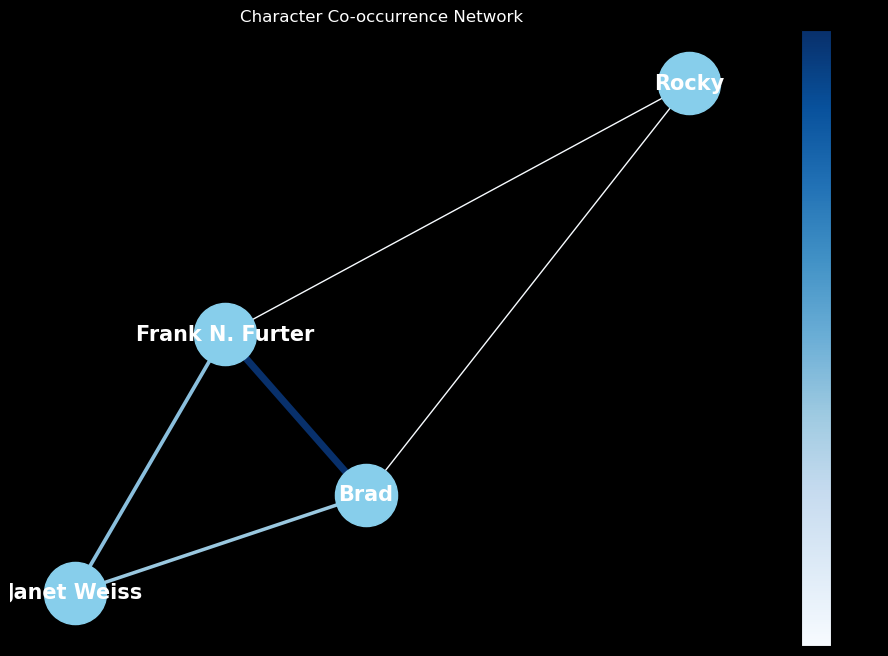

In [25]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/20841947_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##21680740.txt

Sentence: I recently went and saw a Rocky Horror shadowcast performance and since then I've just been in love with Rocky again like I used to be a few years ago, and I'm back writing fanfic bc honestly I love Magenta so much and I just want more Magenta content, canon or not!
Characters: ['Rocky', 'Magenta']
Score: 30

Sentence: I love Magenta and Columbia so much and there's a severe lack of fics about them so here's my input.
Characters: ['Columbia', 'Magenta']
Score: 9

Sentence: It baffled Magenta how her ‘master’, Frank, managed to bring home so many vibrant, interesting looking young playmates.
Characters: ['Frank N. Furter', 'Magenta']
Score: 12

Sentence: He whipped Riff Raff in punishment over the smallest of mistakes, leaving Magenta to pick up the pieces.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: The human who emerged from Frank’s passenger seat this time was a young girl, barely older than 18 from what Magenta could make out, with a small frame and near impe

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2673040211.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2673040211.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


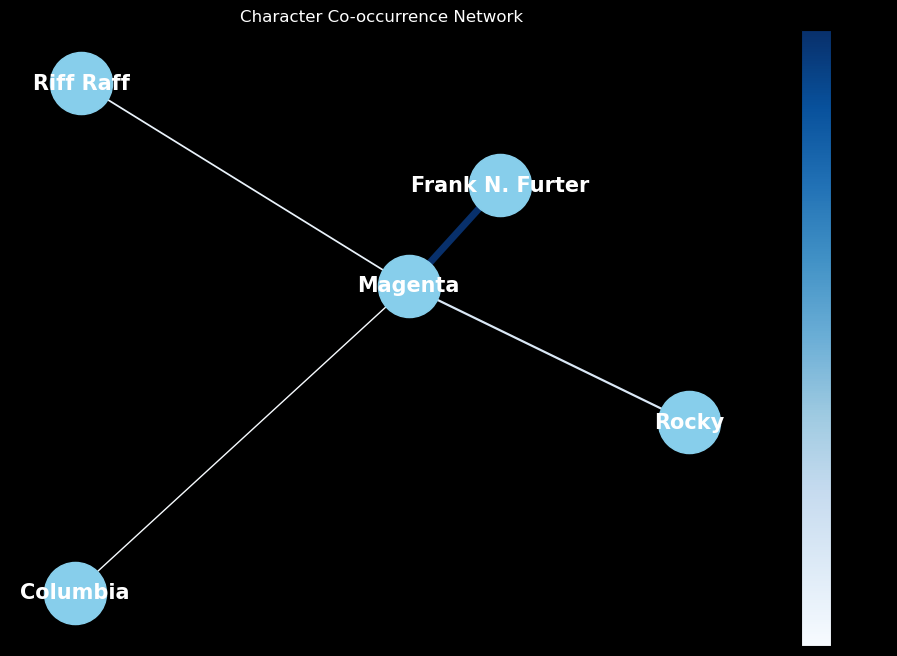

In [26]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/21680740.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##22262287.txt

Sentence: Accompanying him was Brad, Janet, and Frank and Janet’s son, Sonny.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 0



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1182583652.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1182583652.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


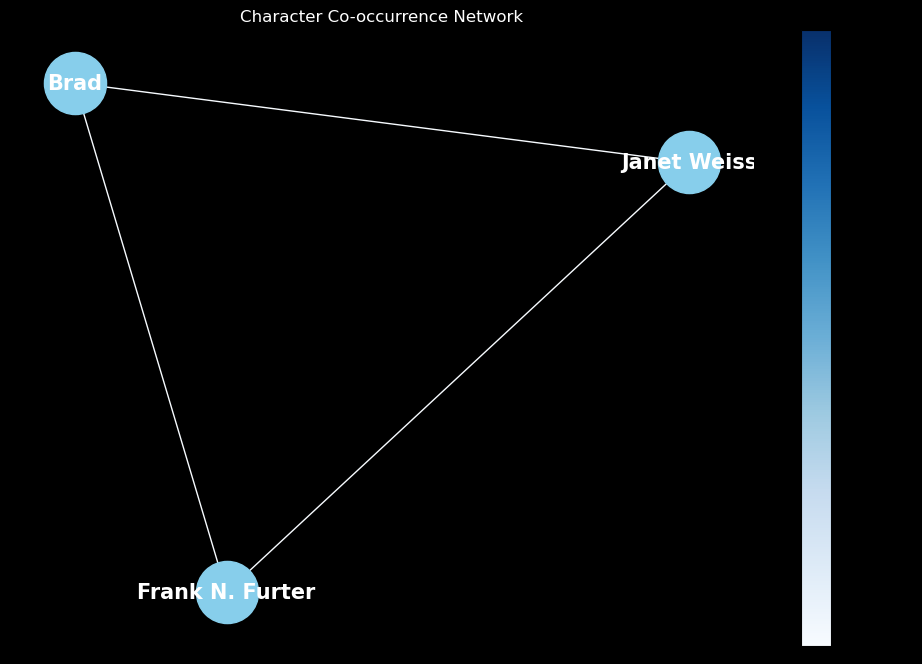

In [27]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/22262287.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##23080390.txt

Sentence: très charmant

Columbia watches Magenta brush her hair through the mirror as she takes a makeup wipe to her face, and she thinks Magenta is gorgeous.
Characters: ['Columbia', 'Magenta']
Score: 20

Sentence: Magenta sits on her knees in front of her, and Columbia runs her fingers through the hair that frames Magenta’s face as she smiles through lipstick coated lips.
Characters: ['Columbia', 'Magenta']
Score: 10



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3343602291.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3343602291.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


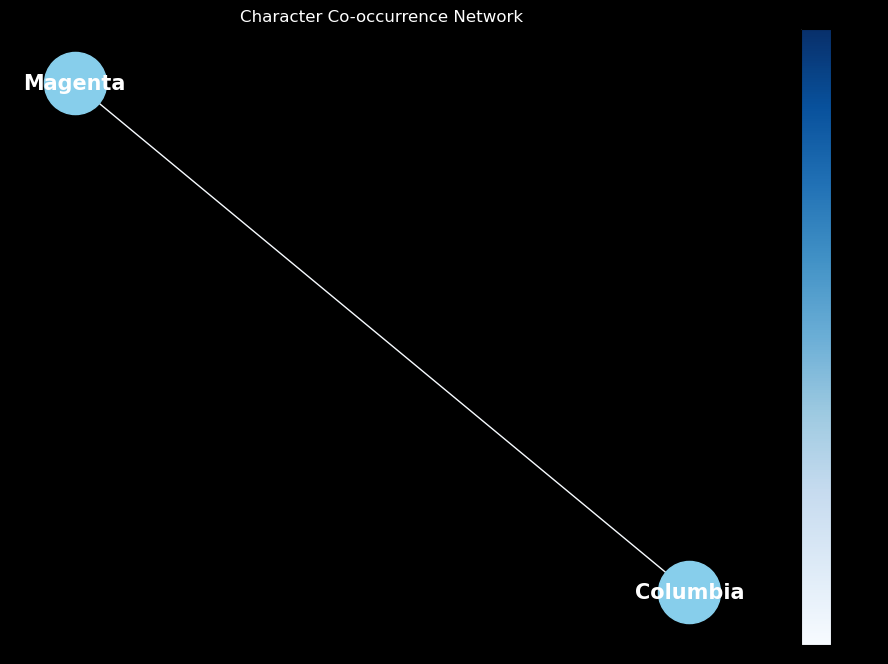

In [28]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/23080390.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##2484962.txt

Sentence: "They are my domestic, Magenta, and my handyman, Riff Raff."

Sarah-Anne nodded and looked at them.
Characters: ['Riff Raff', 'Magenta']
Score: 8

Sentence: "You better vatch out for Frank..." Magenta, the domestic, spoke up, revealing a very thick accent, and she folded her arms, looking a little peeved with Sarah-Anne even if she had just met her.
Characters: ['Frank N. Furter', 'Magenta']
Score: 12

Sentence: Riff Raff looked at Magenta.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: Riff looked at Frank.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 0

Sentence: "I still don't trust this..." Magenta whispered to Riff Raff, worried about the girl being caught in a trap from Frank with him being the way he usually was.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 11

Sentence: Riff Raff placed a hand on Magenta's arm, he knew if she lost her calm then everything would be worse.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: He kne

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1251102909.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1251102909.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


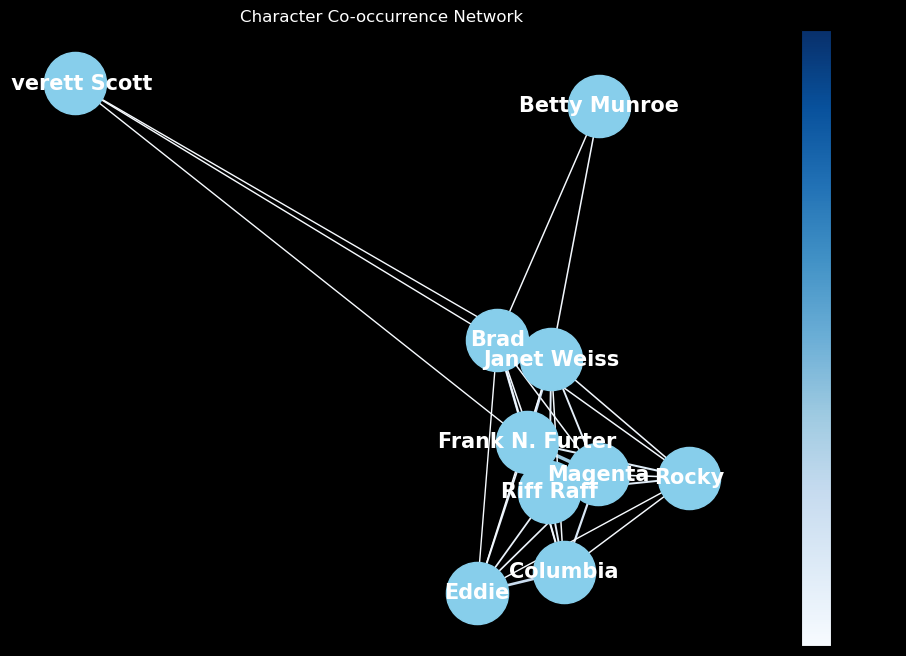

In [101]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/2484962.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##2662625.txt

Sentence: “Oh, Rocky!” Frankie shouted, throwing himself at his creation and pulling the limp figure into his arms.
Characters: ['Frank N. Furter', 'Rocky']
Score: 8

Sentence: Several coppers dragged Frankie away from Rocky’s beautiful but cold body while he sobbed brokenly.
Characters: ['Frank N. Furter', 'Rocky']
Score: 0



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1317719267.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1317719267.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


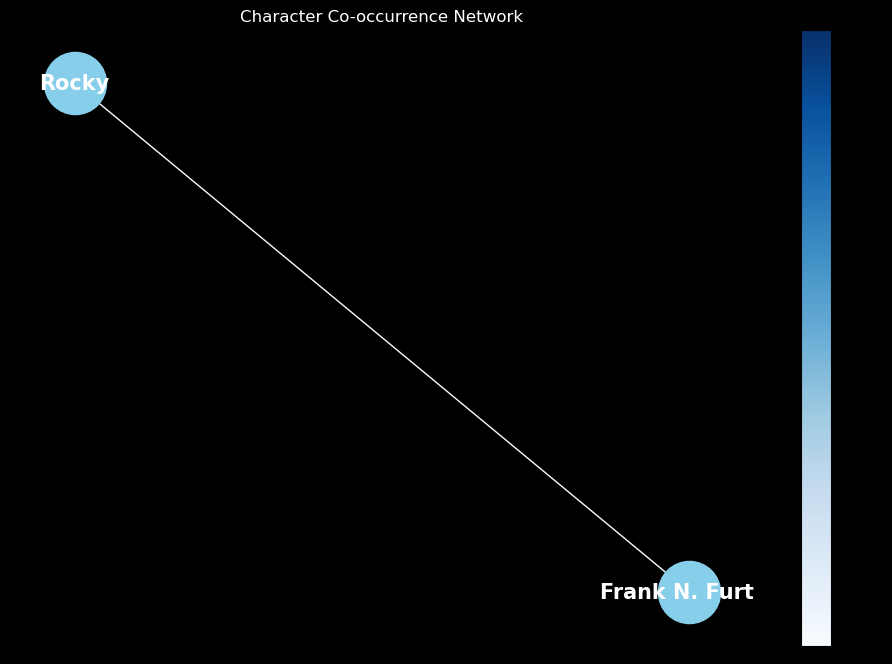

In [30]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/2662625.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##27580583.txt

Sentence: “...as long as we both shall live.”

Janet snapped back to the moment, Brad’s hand leaving hers to clap and cheer.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Janet looked around and saw Brad and Ralph remove themselves from the mass of excitement.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: Brad and Janet dallied on the lawn.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Janet’s mood, buoyed up by the crowd and Betty’s euphoria, sank into gentle contentment as Brad held her hand.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Ralph Hapschatt.” Janet glanced up and saw Brad still looking after the car, now just a spot in the distance.
Characters: ['Janet Weiss', 'Brad']
Score: 8



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1379487884.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1379487884.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


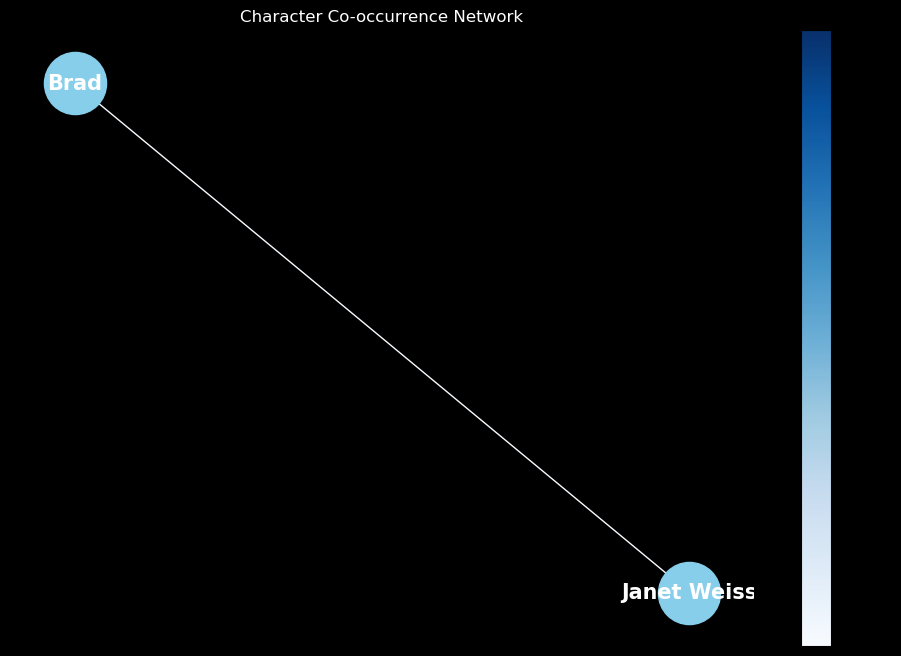

In [31]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/27580583.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##27626326.txt

Sentence: Chapter 1

Columbia skittered around the cramped stone hallways, following Riff Raff and Magenta.
Characters: ['Columbia', 'Riff Raff', 'Magenta']
Score: 8

Sentence: Columbia caught it with her first set of hands and tossed it onto Riff Raff’s head.
Characters: ['Columbia', 'Riff Raff']
Score: 4

Sentence: “Well...you know how me an’ Magenta an’ Riff were out getting the last piece for, um--” Eddie’s replacement “--the new playmate?” Frank had decided last minute that Eddie’s replacement simply had to have three functioning kidneys, so off they went to the nearest funeral to go get another.
Characters: ['Frank N. Furter', 'Eddie', 'Riff Raff', 'Magenta']
Score: 29



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/279681306.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/279681306.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


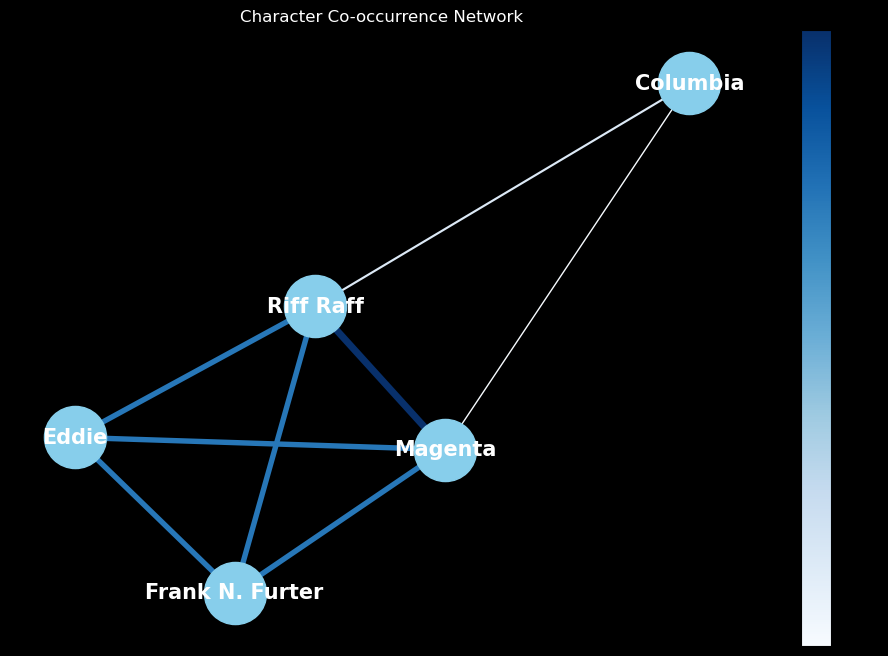

In [32]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/27626326.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##27658573.txt

Sentence: Nobody spoke until they got to Everet's estate where Janet and Brad were supposed to be all along.
Characters: ['Janet Weiss', 'Brad']
Score: 12

Sentence: Janet sniffles and rubs her exposed arms, already stripped off those shimmering gloves and sloppily wiped the paint off her face, leaving soft blue tear streaks mocking Frank's own.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 19

Sentence: " If I had any sense left after what you've done I would have let them "

Both Janet and Frank cringed at his crossness, especially Janet, knowing Brad to be such a nice guy...guess some things changed in all of them after tonight.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 29

Sentence: Brad tugged on the jacket he had found nearly torn in half in the rubble of the ruins of Frankenfurter's palace.
Characters: ['Frank N. Furter', 'Brad']
Score: 4

Sentence: Janet's cardigan had been torn to shreds but despite her shivering, Brad had grabbed it up in an instan

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1615013123.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1615013123.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


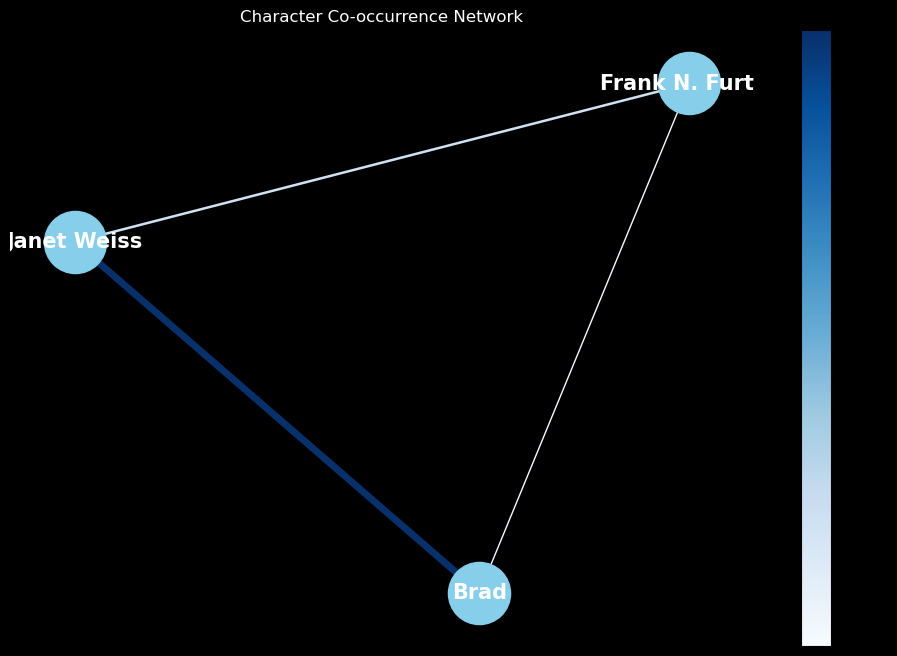

In [33]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/27658573.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##28063239.txt

Sentence: Brad and Janet opened their doors to step into the deluge, and met at the back corner of the car.
Characters: ['Janet Weiss', 'Brad']
Score: 12

Sentence: “..into my life!”

Brad caught Janet before she could fall into the mud.
Characters: ['Janet Weiss', 'Brad']
Score: 4



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2650312576.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2650312576.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


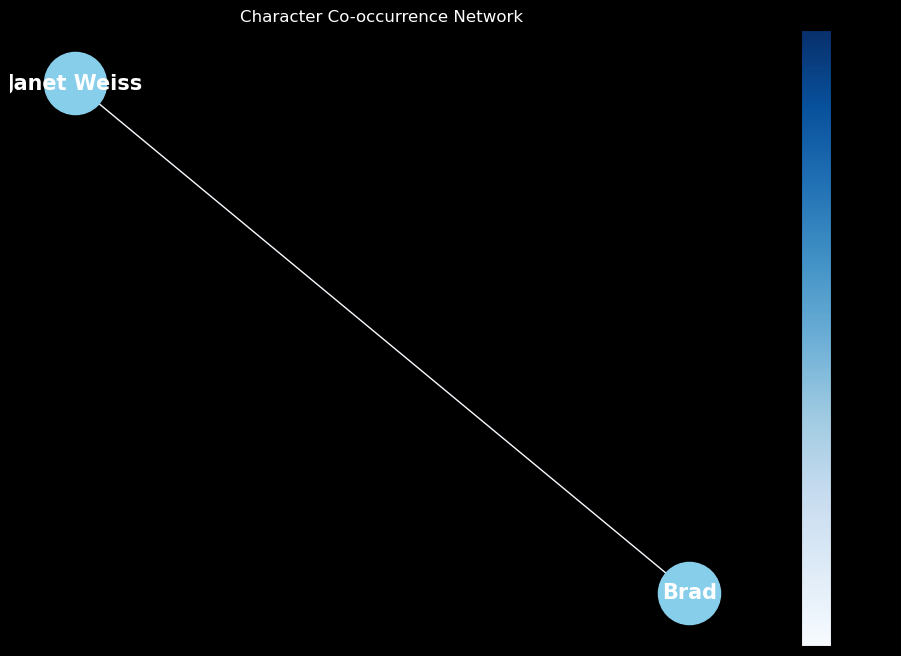

In [34]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/28063239.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##2808269.txt

Sentence: Brad and Janet had gotten married a few weeks after the… incident with the Transylvanians.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: To an exterior eye, they looked like the perfect household but Janet still longed for the perfect, innocent Rocky, and Brad couldn't forget the few sensual minutes he had spent with Frank.
Characters: ['Frank N. Furter', 'Rocky', 'Brad', 'Janet Weiss']
Score: 17

Sentence: "Frank!" shouted Brad, extending his hand to touch the taller's man shoulder.
Characters: ['Frank N. Furter', 'Brad']
Score: 4

Sentence: For a split second, Brad had been certain he had seen Riff Raff winking at him.
Characters: ['Brad', 'Riff Raff']
Score: 6



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1104807333.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1104807333.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


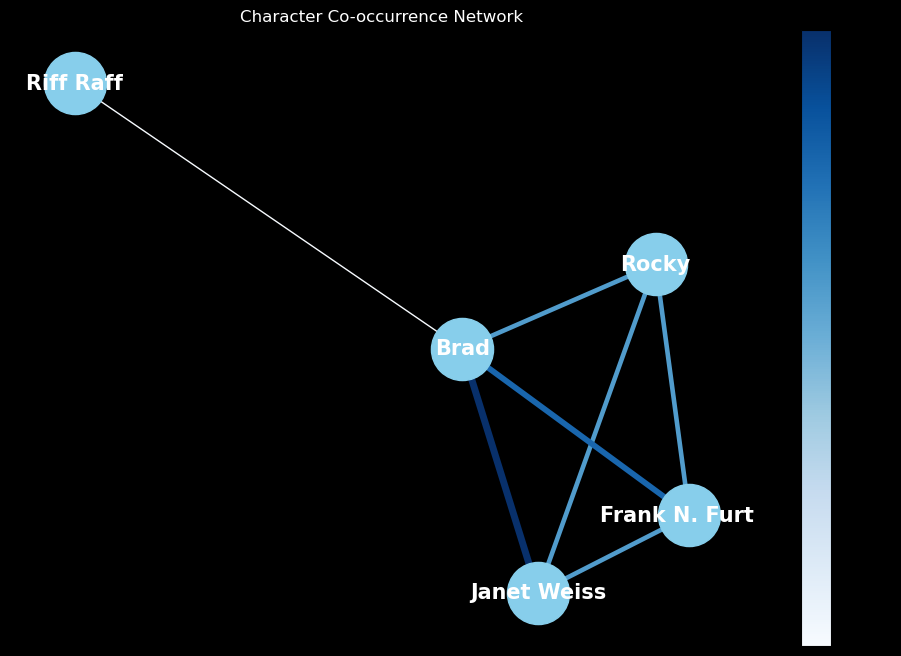

In [35]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/2808269.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##28809600.txt

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2819109940.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2819109940.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


Sentence: You won't get far.' Magenta chewed her sirloin looking at her plate, missing the utterly ferocious glare Frank was giving her.
Characters: ['Frank N. Furter', 'Magenta']
Score: 15

Sentence: Silly children, the pair of them.' Frank seethed once more at Magenta then turned his attention back to his plate.
Characters: ['Frank N. Furter', 'Magenta']
Score: 4

Sentence: The only good thing about potentially being lied to, was that Frank was so intent on killing Magenta with his blazing eyes, Sprite grabbed the bottle and quickly hid it under the table, where she uncorked it and poured a generous amount into her elderflower fizz.
Characters: ['Frank N. Furter', 'Magenta']
Score: 12

Sentence: 'This is Magenta's personal stash.' Frank selected a labelled jar of lavender buds.
Characters: ['Frank N. Furter', 'Magenta']
Score: 0

Sentence: I'm not fussed about Columbia but she can sit in if she wants - not that she'll have anything worth noting to say.' Frank paused.
Characters: ['Fr

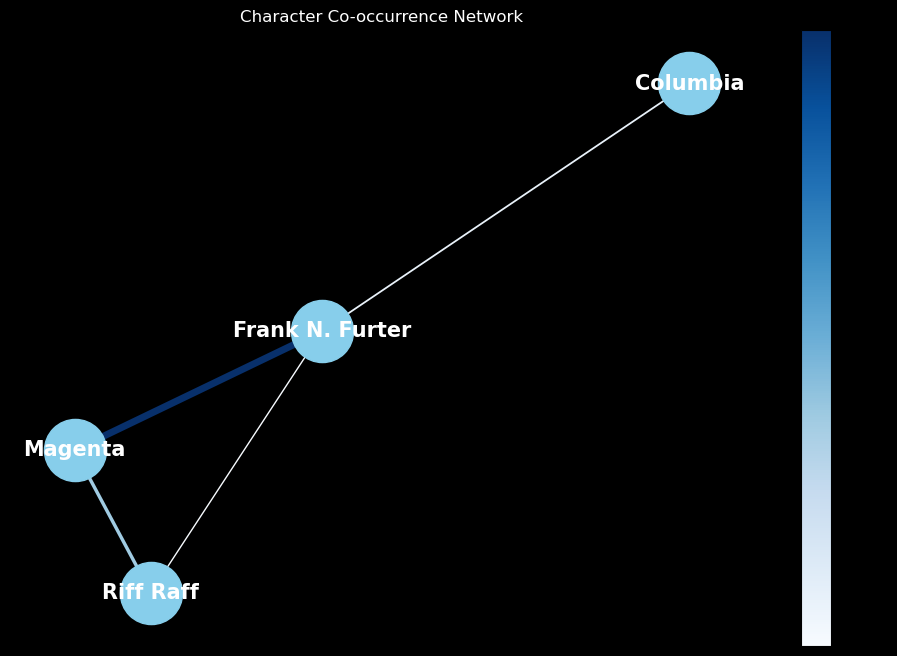

In [36]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/28809600.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##28950279_txt.txt

Sentence: It wasn’t her fault that their rather queer host, Dr Frank, was so incredibly attractive in the strangest of ways, or that he had slipped into her bedroom pretending to be Brad (really, how had she not noticed?), or that he had insisted on kissing down her neck, her collarbone, her chest, down even lower…


There’s no crime in giving yourself over to pleasure.
Characters: ['Frank N. Furter', 'Brad']
Score: 26



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1764472452.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1764472452.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


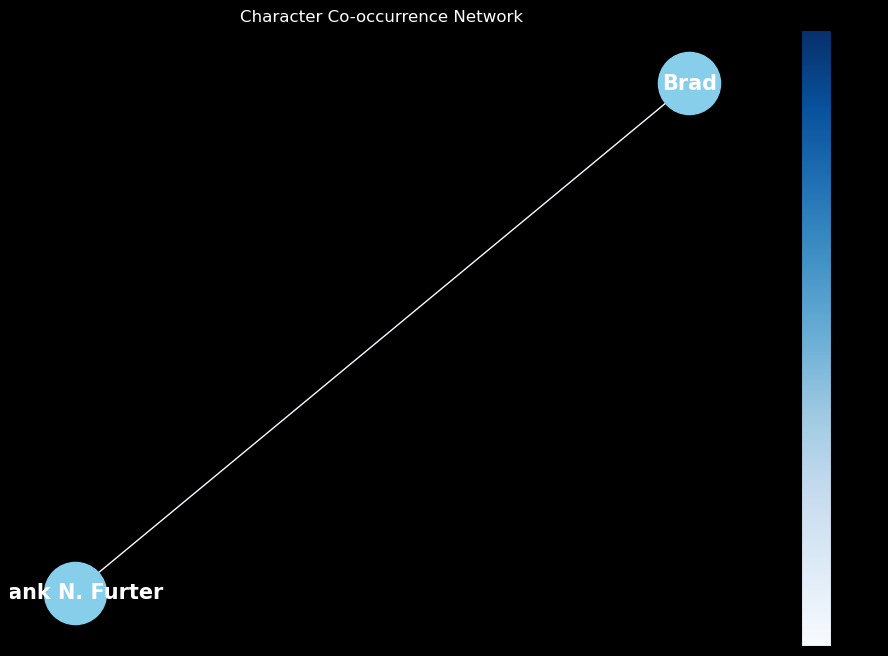

In [37]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/28950279_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##29058837.txt

Sentence: Frank’s flirtatious taunts replayed over and over in Brad’s head, like the devil speaking right into his ear.
Characters: ['Frank N. Furter', 'Brad']
Score: 13



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/737939040.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/737939040.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


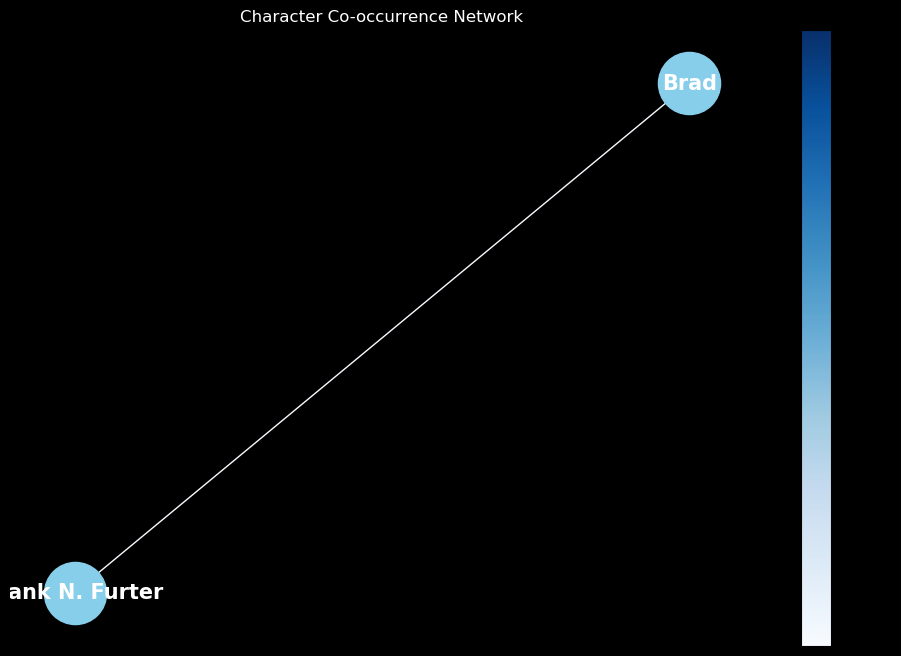

In [38]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/29058837.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##29608974.txt

Sentence: Prologue 💋

Michael Rennie was ill🤒
🌎The Day the Earth Stood Still🌎
But he told us...where we stand🤗
🌌And Flash Gordon was there🌌
In silver underwear⭐
⛆Claude Rains was The Invisible Man
Then something went wrong
👠For Fay Wray and King Kong🙊
⚠They got caught in a celluloid jam⚠
Then at a deadly pace☠
⁉It Came From Outer Space⁉
And this is how the message ran...🏃

Science fiction 🔍
🗣ooh ooh ooh
🎬Double feature
😏Doctor X😏
🗣ooh ooh ooh
will build a creature💪
👀See androids fighting 👀
🗣ooh ooh ooh
👓Brad and Janet👒
Anne Francis stars in ☄
🗣ooh ooh ooh
Forbidden Planet🍄
💋Wo oh oh oh oh oh
🎞At the late night, double feature,🎞 picture show📸

I knew Leo G.
Characters: ['Janet Weiss', 'Brad']
Score: 28

Sentence: Carrol👧

😮Was over a barrel😮
🕷When Tarantula took to the hills
🔥And I really got hot🔥
🌺When I saw Janette Scott
☠Fight a Triffid that spits poison and kills☠
🍆Dana Andrews said prunes
🔲Gave him the runes
✔And passing them used lots of skills✔
🌋But When Worlds Collide🌋
👿Said Geo

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2015658422.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2015658422.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


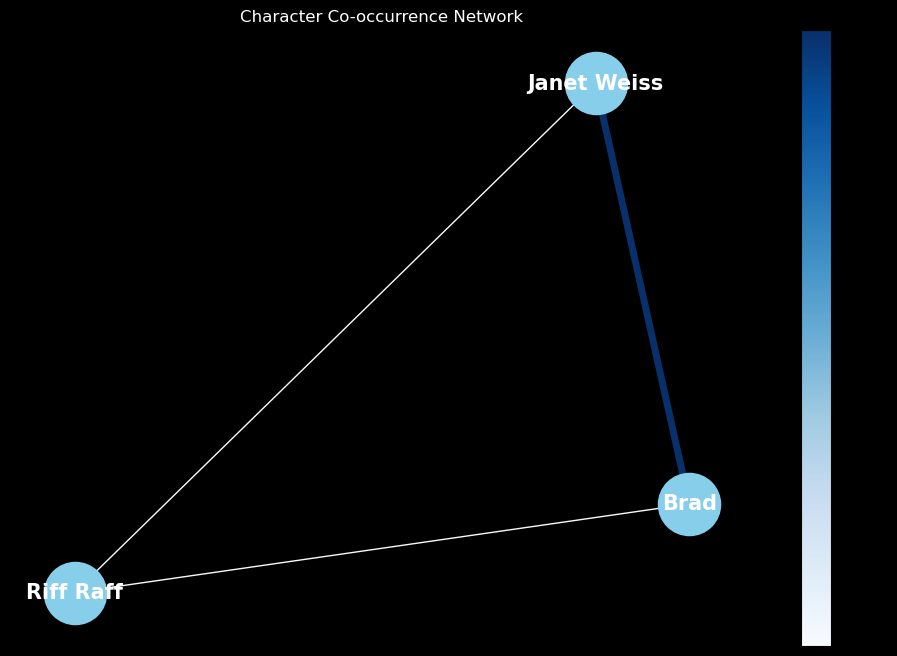

In [39]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/29608974.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##32097430.txt

Sentence: It was okay I guess Brad." Janet Majors sighed as she looked at the old photo album where all of their happy memories lay in Polaroids, while Brad Majors replied.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: Though personally despite Brad having psychic powers, Janet wasn't sure if the phony doctors were going to escape from jail.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: "I hope our kids are happy in the future." As the clock struck midnight, Brad and Janet enjoyed their simple company in the last night of the 1990s.
Characters: ['Janet Weiss', 'Brad']
Score: 0



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4125914699.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4125914699.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


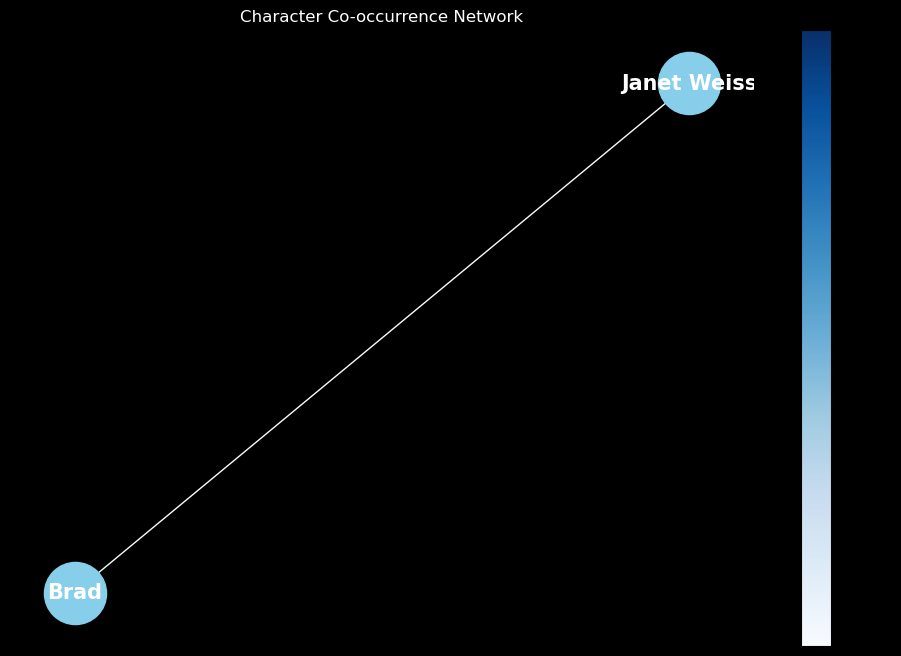

In [40]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/32097430.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##32886031.txt

In [41]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/32886031.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


ValueError: min() arg is an empty sequence

In [ ]:
##错误原因，使用了新的人物名称

In [ ]:
##34268329.txt

Sentence: That evening, Riff Raff spent a good deal of time explaining his latest findings, the intricacies of what should be the next steps in Frank's little science project.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 15

Sentence: Riff Raff tried to push the words out of his thoughts, Fuck yourself for me, the amused tone in Frank's voice.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 10

Sentence: The naughty face she'd make as Riff Raff would wet his fingers in her and Magenta would stroke his cock a tantalizing way, in response.
Characters: ['Riff Raff', 'Magenta']
Score: 10

Sentence: It was like this, with Frank over him and those hands all over Riff Raff that he allowed his mind to just drift.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 9

Sentence: Frank had pushed him all long he was onto the sofa and was grinning a hideous way, hand around Riff Raff's erection.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 12

Sentence: In moments like this, when

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1119392167.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1119392167.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


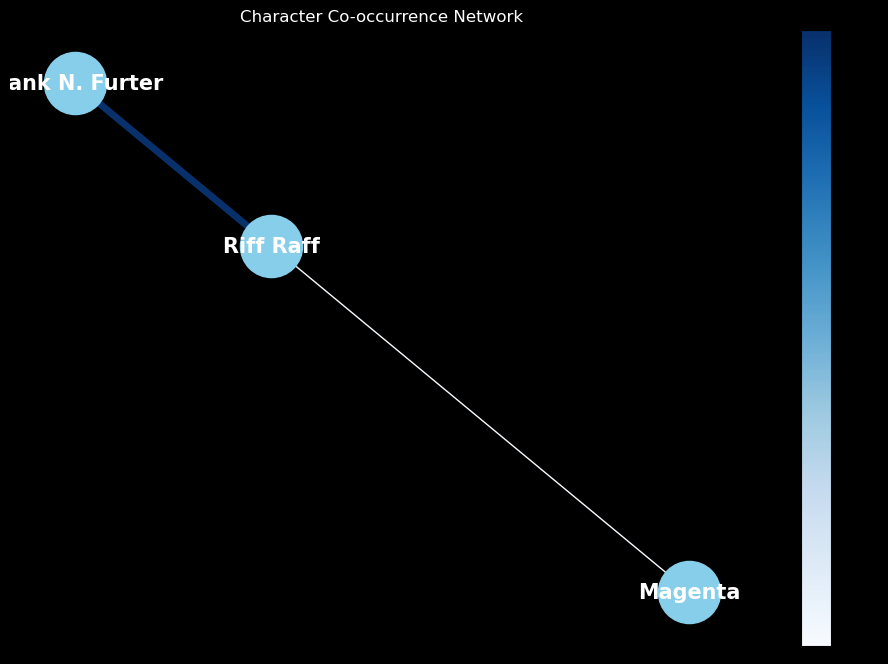

In [42]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/34268329.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##34411.txt

Sentence: "He won't like this," Magenta said, walking around to smooth Riff Raff's hair into the single spike he'd been accustomed to back on Transsexual.
Characters: ['Riff Raff', 'Magenta']
Score: 13

Sentence: Back when it had just been Riff Raff, his sister, and the Master, later when Columbia and Eddie had joined them.
Characters: ['Columbia', 'Eddie', 'Riff Raff']
Score: 0

Sentence: "And what of Columbia, Brad, Janet, and Dr.
Characters: ['Janet Weiss', 'Columbia', 'Brad']
Score: 0

Sentence: Scott?"

Columbia and Magenta had formed a sort of friendship fairly quickly.
Characters: ['Columbia', 'Magenta']
Score: 0

Sentence: Magenta didn't answer, but Riff Raff could tell she disapproved.
Characters: ['Riff Raff', 'Magenta']
Score: 6

Sentence: "Do you remember how it was when Columbia showed up at first?" Magenta asked, glancing over at him.
Characters: ['Columbia', 'Magenta']
Score: 9

Sentence: He's broken every rule we have repeatedly."

"Frank has very little use for rules a

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2490274645.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2490274645.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


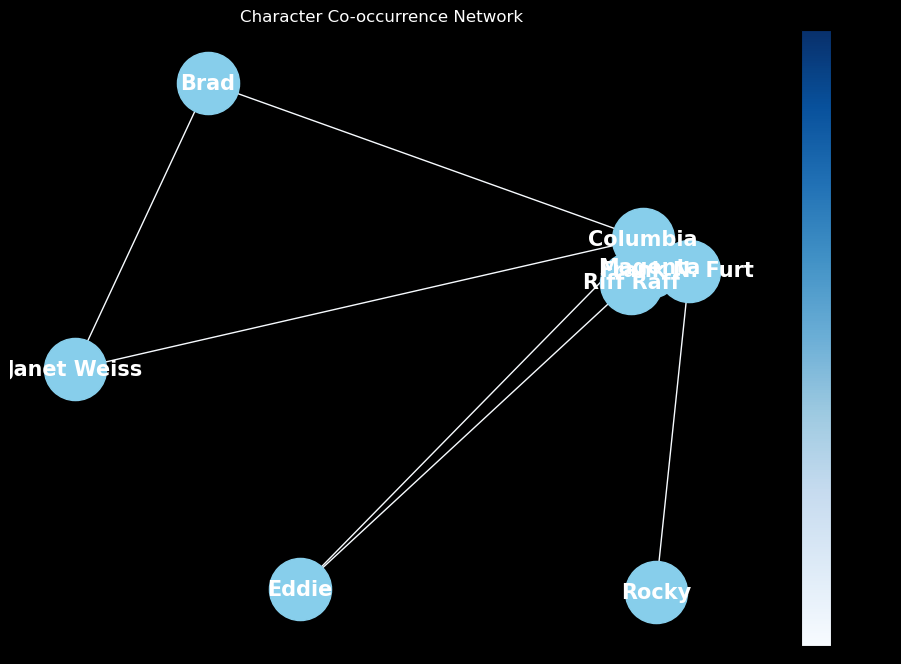

In [43]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/34411.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##34495012_txt.txt

Sentence: Just a couple of hours ago, Janet and Brad were driving over to their dear friend Dr.
Characters: ['Janet Weiss', 'Brad']
Score: 4

Sentence: It was just that Frank didn’t seem to be anything like any of the scientists that Janet had seen in her life.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 5

Sentence: And there was Frank’s creation too, Rocky.
Characters: ['Frank N. Furter', 'Rocky']
Score: 0

Sentence: It was just that… well, Janet wasn’t lying when she said that she wasn’t into men with too many muscles, but there was something about Rocky that was appealing, in a sense.
Characters: ['Janet Weiss', 'Rocky']
Score: 4

Sentence: - but she knew why Frank had created Rocky and what the scientist was going to use his creation for.
Characters: ['Frank N. Furter', 'Rocky']
Score: 8

Sentence: Thinking of Frank using Rocky for his intended purposes made a blush creep onto Janet’s face.
Characters: ['Frank N. Furter', 'Rocky', 'Janet Weiss']
Score: 10

Sentence: Fran

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1103521442.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1103521442.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


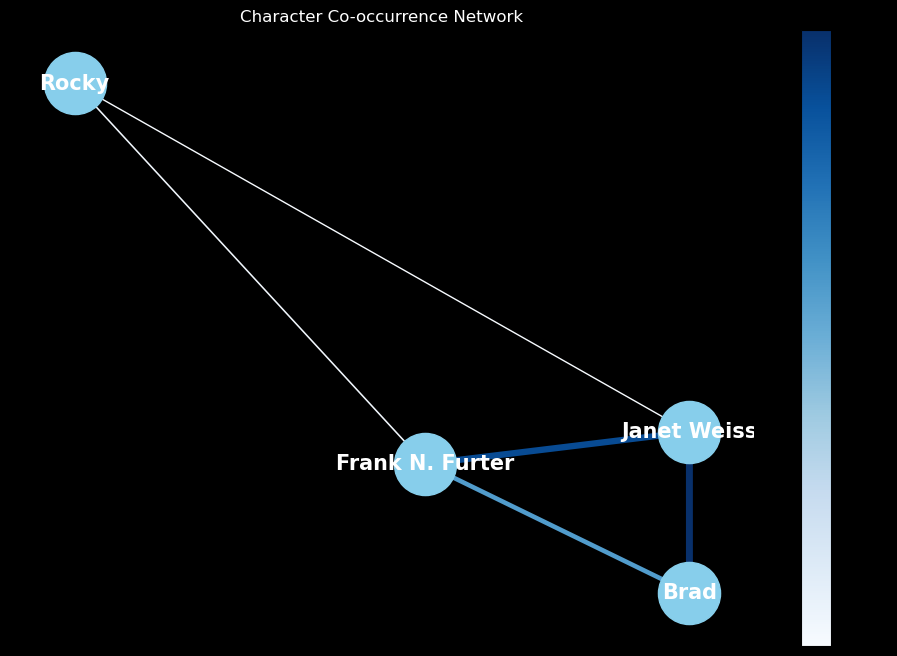

In [44]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/34495012_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##34583485.txt

Sentence: Not that Columbia minded, she liked the silence in the afterglow, the warmth of Eddie’s skin against her own enough to calm her down.
Characters: ['Columbia', 'Eddie']
Score: 9

Sentence: With the thought of Frank, she shot up, startling Eddie.
Characters: ['Frank N. Furter', 'Eddie']
Score: 5

Sentence: Hopefully your little dreams brought you some joy though, by the way you were whimpering I think they might have~.”

Columbia felt warm, confused tears gush down her cheeks, eyes flickering around the room, trying to see Frank through the harsh, stinging light.
Characters: ['Frank N. Furter', 'Columbia']
Score: 20



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2480500734.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2480500734.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


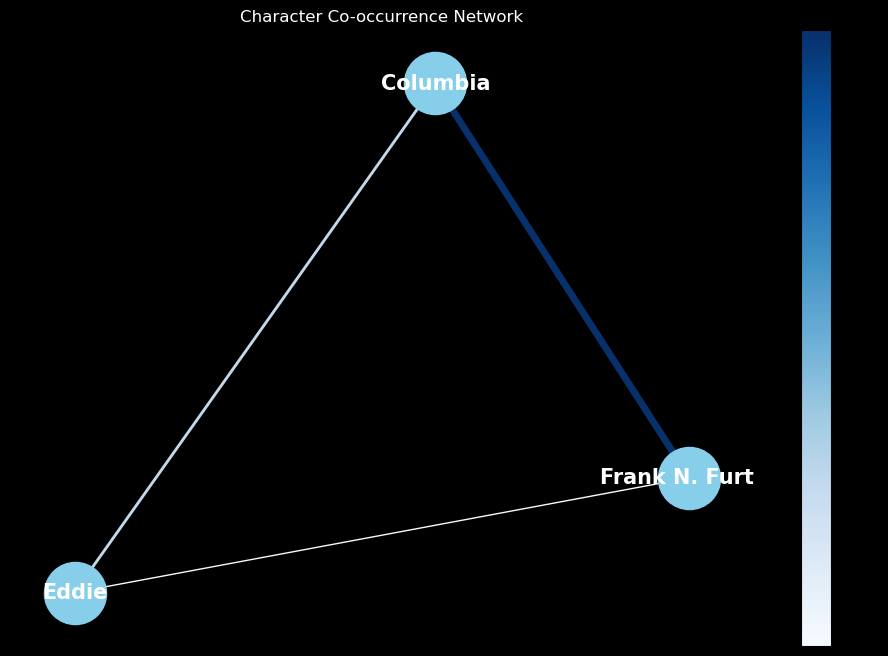

In [45]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/34583485.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##35073142.txt

Sentence: Brad felt as though he had been living in Frank-N-Furter's castle since the beginning of time, although it had only been a week.
Characters: ['Frank N. Furter', 'Brad']
Score: 4

Sentence: Janet was interested in Rocky now, mostly, and Brad-

Brad swallows.
Characters: ['Janet Weiss', 'Rocky', 'Brad']
Score: 4

Sentence: Brad doesn't like to think of Rocky.
Characters: ['Rocky', 'Brad']
Score: 10

Sentence: Frank and Janet.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 0

Sentence: Frank would never want Brad, not really.
Characters: ['Frank N. Furter', 'Brad']
Score: 0

Sentence: "I'm just thinking, Frank, go back to sleep," Brad sighs.
Characters: ['Frank N. Furter', 'Brad']
Score: 12

Sentence: It bothers Brad when exactly Frank has time to do all that makeup when he's always with other people.
Characters: ['Frank N. Furter', 'Brad']
Score: 13

Sentence: Brad turns his face away, shy, and Frank ends up kissing his cheek instead before bursting into laughter.
Charac

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/108932495.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/108932495.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


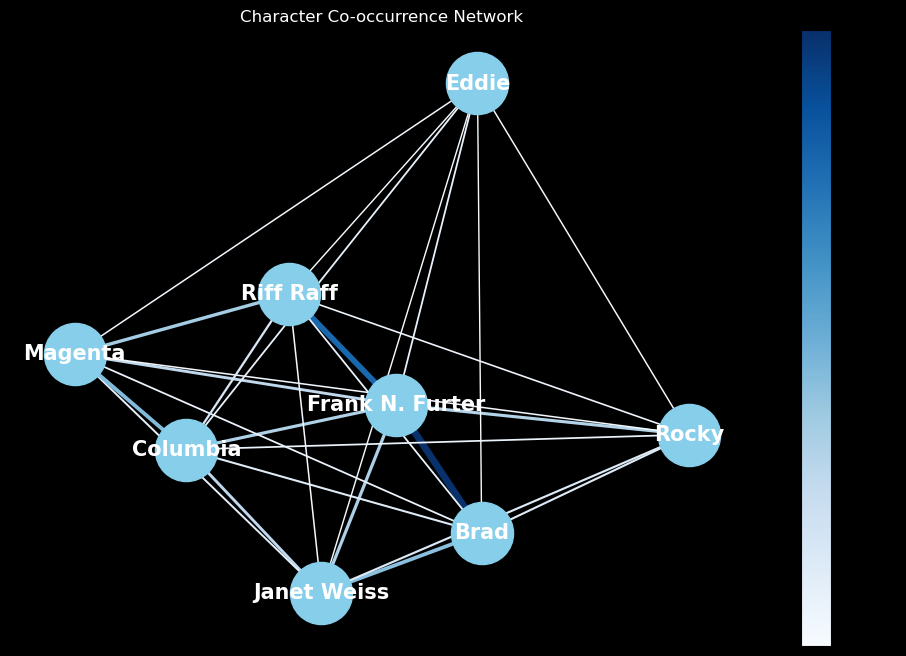

In [46]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/35073142.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##35224531.txt

Sentence: "Brad?"

Janet's voice manages to snap Brad out of his groggy daze for a moment.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Brad notices Janet's concerned expression and huffs out a sigh he didn't know he'd been holding.
Characters: ['Janet Weiss', 'Brad']
Score: 20

Sentence: Brad knows that his family and Janet's family has high hopes for the both of them, and he knows that they can't just ruin that expectation.
Characters: ['Janet Weiss', 'Brad']
Score: 4

Sentence: "Brad, darling?"

"Yes, I'm alright, Janet," Brad responds, almost automatically.
Characters: ['Janet Weiss', 'Brad']
Score: 3

Sentence: "Frank?" Brad asks incredulously, eyebrows raised.
Characters: ['Frank N. Furter', 'Brad']
Score: 8

Sentence: "Whatever you say, big guy," Columbia replies and exchanges looks with Magenta.
Characters: ['Columbia', 'Magenta']
Score: 16

Sentence: But Brad really can't imagine Frank settling down into a relationship with him.
Characters: ['Frank N. Furter', 'Brad

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3657217120.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3657217120.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


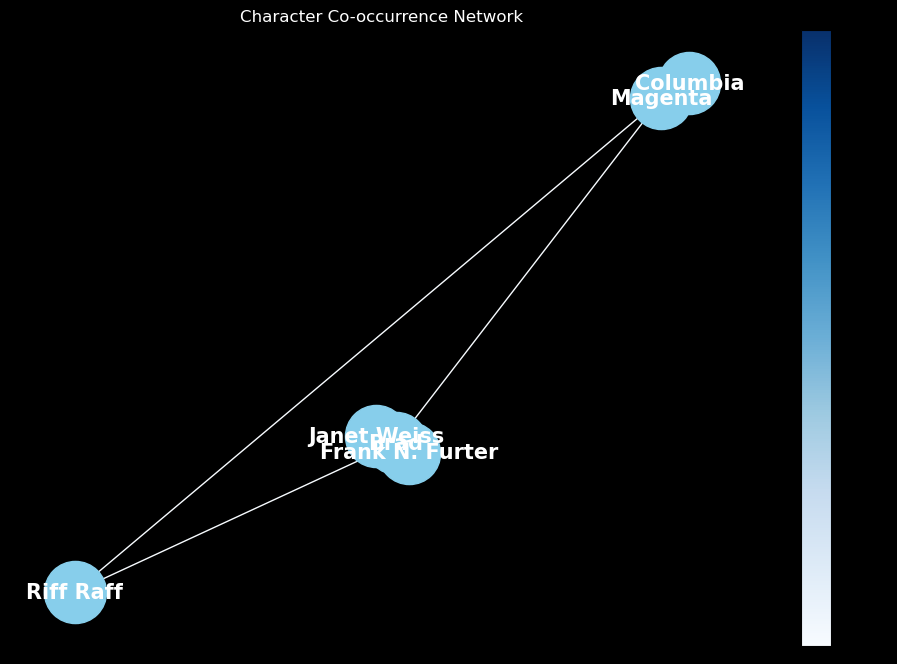

In [47]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/35224531.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##35286316.txt

In [48]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/35286316.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


ValueError: min() arg is an empty sequence

In [ ]:
##36512008.txt

In [49]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/36512008.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


ValueError: min() arg is an empty sequence

In [ ]:
##36673720.txt

Sentence: Janet was inside the car, Brad was by her side, driving.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: As Janet got inside, she realized, the objects were in the exact same place as they had been, before Frank's handyman had taken it all with him, to the planet he missed so much.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 21

Sentence: After everything Frank did and the unpleasant memories she had of him, he was still who she had to thank for introducing her to the Janet she knew, the Janet she could not let go of.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 9

Sentence: Lifting Janet, Frank held her with one of his arms under her legs, while the other one kept her steady bearing her back.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: Before Riff Raff could finish his plans, Rocky took me there, and despite the way he used to dismiss me, he was the one who activated it, and I could breathe again.
Characters: ['Rocky', 'Riff 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2541696271.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2541696271.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


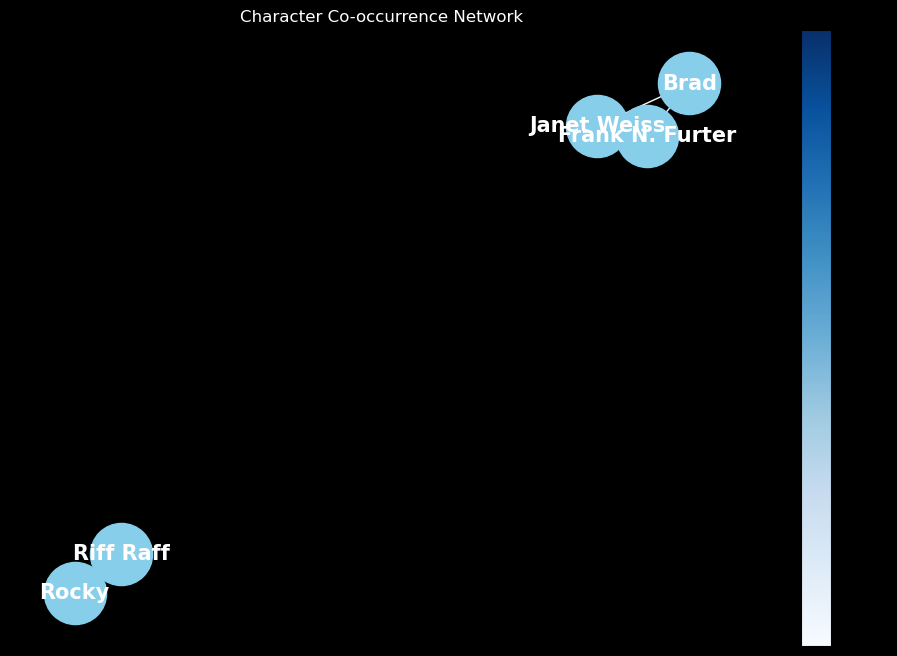

In [50]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/36673720.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##37093471.txt

Sentence: Chapter 1

Author's Note:

No Brad and Janet yet but never fear!
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: There has to be Brad and Janet because if there isn't then there's no Brad x Frank, which is a physical impossibility as far as I'm concerned, I simply must write it.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 8

Sentence: All Riff and Magenta this chapter!
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: Riff Raff has never, in his whole life, been in trouble with Magenta before.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: Riff doesn’t know if Frank's life will ever be saved.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 12

Sentence: Riff has seen Magenta throw things at people before—she threw something at Frank, even, once, during the creation of Rocky—but never, ever at him, and not even really that often.
Characters: ['Frank N. Furter', 'Rocky', 'Riff Raff', 'Magenta']
Score: 4

Sentence: I wasn’t thinking

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2107767573.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2107767573.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


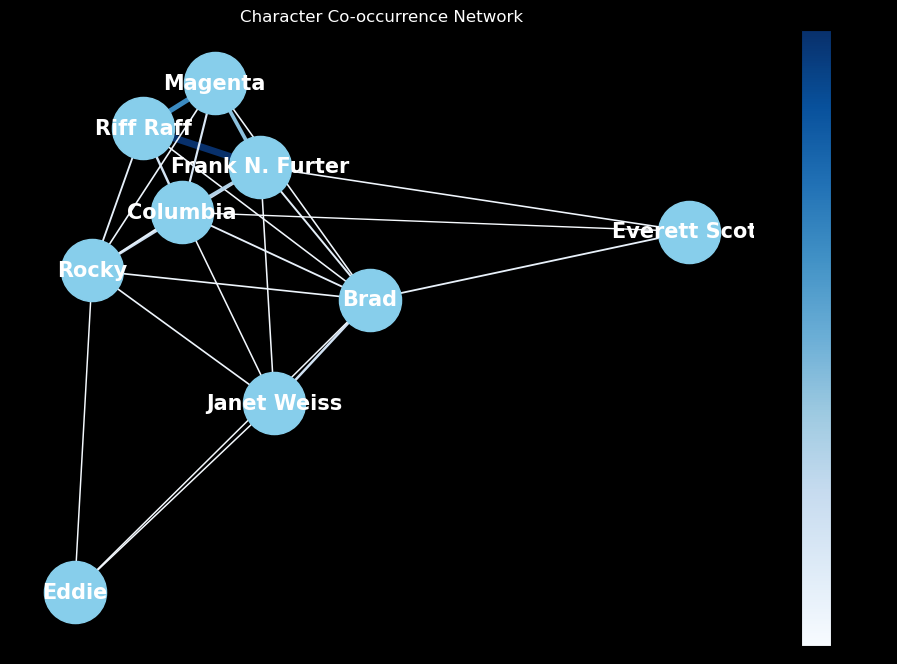

In [51]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/37093471.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##37372630.txt

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2249730068.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2249730068.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


Sentence: Salvation

Author's Note:

Being a huge Frank/Brad simp, and having mixed feelings towards the end of the movie, I just had to write something like that.
Characters: ['Frank N. Furter', 'Brad']
Score: 18

Sentence: * the words in italic are from "The Rocky Horror Picture Show", I obviously do not own any of these lines

“ How sentimental .” *

Like the crack of a whip, Magenta’s words resounded in the ball room, dragging Brad out of the foggy daze he’d been in for the past few hours.
Characters: ['Rocky', 'Brad', 'Magenta']
Score: 8

Sentence: The lab, the dinner, Frank chasing Janet… Janet!
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: With a satisfied smirk, Riff Raff put both of his hands on the gun as Brad clenched his fist behind his back.
Characters: ['Brad', 'Riff Raff']
Score: 6

Sentence: When he realized it was only a matter of seconds before Riff Raff regained focus, Brad removed his platform shoes calmly and got off the stage.
Characters: ['Br

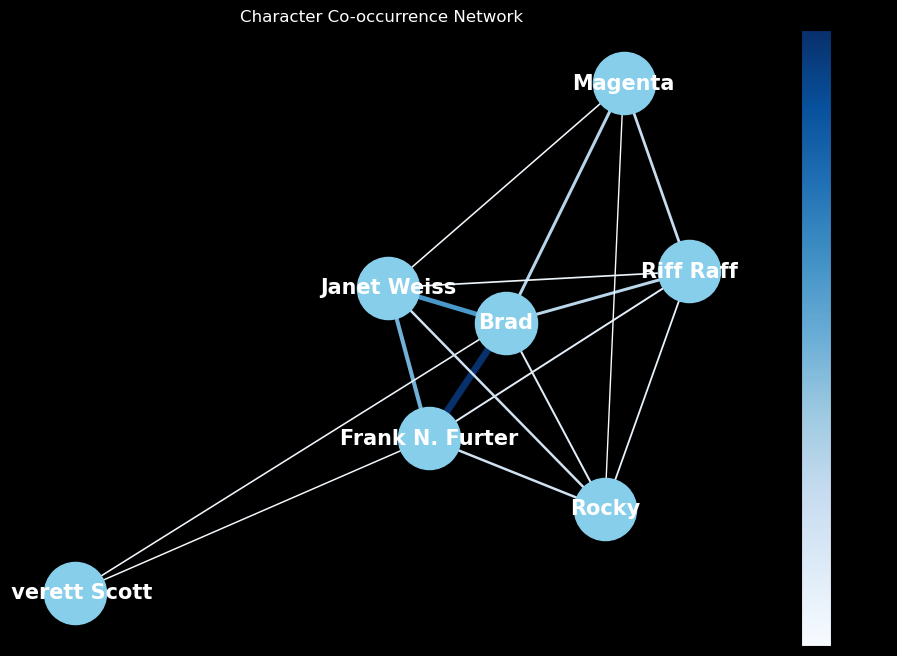

In [52]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/37372630.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##37613392.txt

Sentence: Brad likes women but OH NO Janet slept with rocky what a ROCKY HORROR (Oh no it’s a pun) So now Brad is sad (Oooh that rhymes) and almost kind of single he’s still figuring that out.
Characters: ['Janet Weiss', 'Rocky', 'Brad']
Score: 9

Sentence: Oh god now Frank is doing some weird shit and now Brad realizes that sexy men turn him on (Same fam) so now he’s confused cus he’s technically with Janet but he likes men and DAmm son Frank sexy.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 25

Sentence: OHHH AND Now Frank figured that out and now hre and Braf are awkwardly flirting cus they are so different from each other yayyyy and 1 to skip a few million words and now Janet and Rocky are happily together so Brad and Frank talk and oH God They ARE HAVING SREX AND THEY ARE FUCKING THIS IS GREAT And I would put that in the plot if I could write smut lolololollolo And That MAh PlaOoOt
Characters: ['Frank N. Furter', 'Rocky', 'Brad', 'Janet Weiss']
Score: 16



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/882623612.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/882623612.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


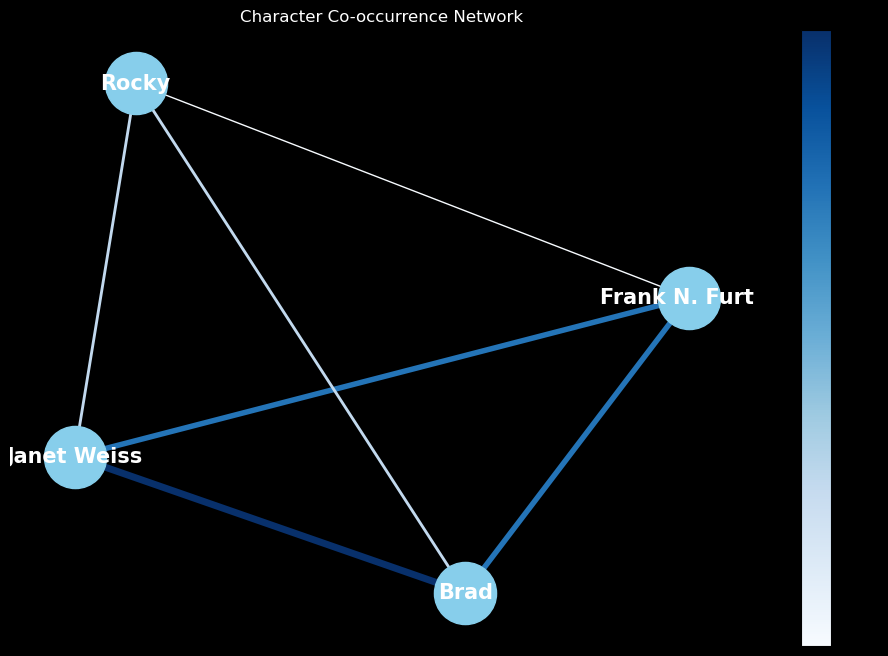

In [53]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/37613392.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##37645705_txt.txt

Sentence: Why don't you go and bother the Master?"
"He's with Eddie." Columbia pouted and Riff Raff ignored it.
Characters: ['Columbia', 'Eddie', 'Riff Raff']
Score: 14

Sentence: Frankie is with Eddie, Mags is busy.
Characters: ['Frank N. Furter', 'Eddie']
Score: 0

Sentence: The one day in countless months where the Master had allowed Riff Raff an evening off also just happened to be the one where he spills who-knows-what all over his 'favourite' corset and demands Magenta clean it by hand.
Characters: ['Riff Raff', 'Magenta']
Score: 15

Sentence: The silence was broken now and again by a complaint from Columbia or the occasional correction from Riff.
Characters: ['Columbia', 'Riff Raff']
Score: 0



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3830225232.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3830225232.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


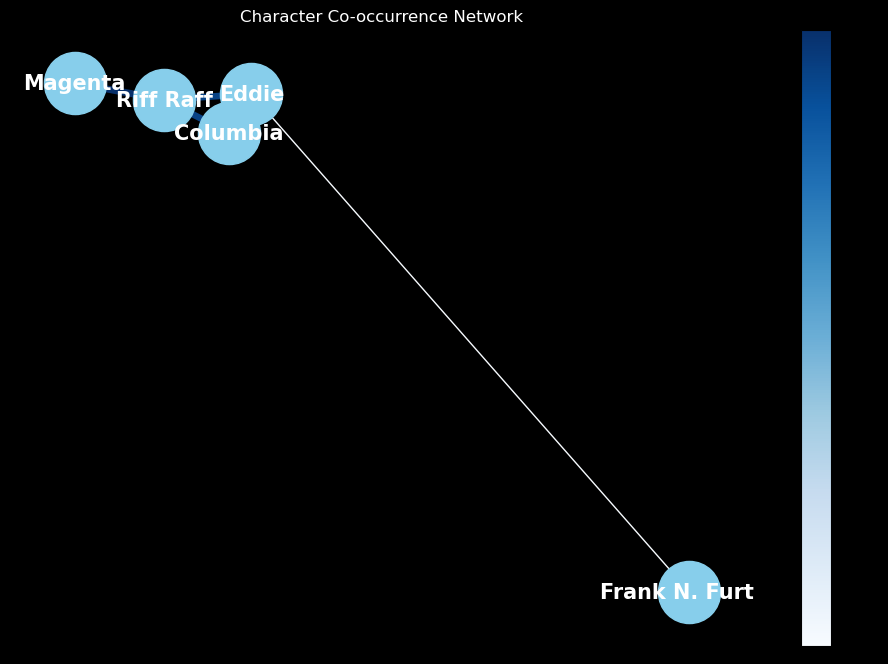

In [54]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/37645705_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##37650010.txt

Sentence: I guess just after it all, pretend Magenta and Riff Raff just...
Characters: ['Riff Raff', 'Magenta']
Score: 1

Sentence: Got Brad/Frank and Collie/Mage for DAYS though!
Characters: ['Frank N. Furter', 'Brad']
Score: 0

Sentence: After all, it had been his idea to go here after the baking incident, the board game fiasco and three broken vases from Columbia dragging Magenta to roller skate around the castle.
Characters: ['Columbia', 'Magenta']
Score: 12

Sentence: Even though Magenta was no longer tasked with cleaning the entire place by herself, she still couldn’t always be there to entertain Columbia.
Characters: ['Columbia', 'Magenta']
Score: 10

Sentence: “BJ?" Magenta whispered as Janet pulled Rocky up from his seat and walked towards the ball dispenser.
Characters: ['Janet Weiss', 'Rocky', 'Magenta']
Score: 11

Sentence: Columbia looked up and out at the bowling lanes then, watching as Janet hefted one of those metal slides onto the floor and lined it up with the middle 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/548281011.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/548281011.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


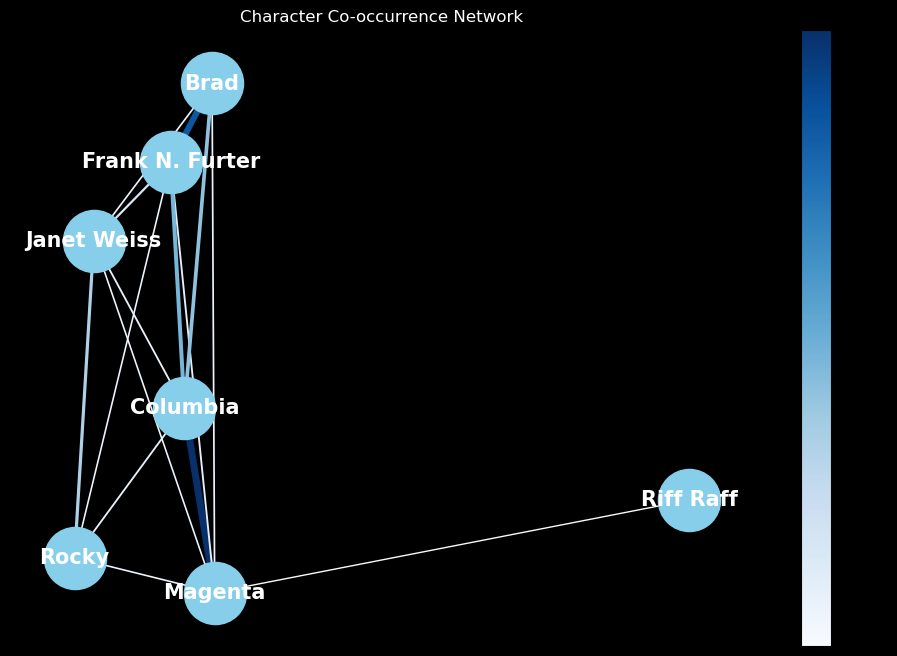

In [55]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/37650010.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##38107357.txt

Sentence: “You seem to be having so much fun.”

“Yes,” Janet resounded breathlessly as Frank moved down from her neck to smother her collar bone in wet, thick kisses.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 13

Sentence: “I am, Frank.” She couldn’t say she had another thought of Brad, if she was honestly.
Characters: ['Frank N. Furter', 'Brad']
Score: 4

Sentence: “Frank, I...” Janet breathed heavy, placing a dainty hand over her chest as it rise and fell almost alarmingly fast as she filled down air.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 12

Sentence: If she had the brains to think of the man in the moment, she wondered if Brad would have told her the same if he was in Frank’s position now.
Characters: ['Frank N. Furter', 'Brad']
Score: 10

Sentence: “Mhm.” Frank nodded, momentarily distracted by the sight of Janet being overtaken by the pleasure Frank was able to give her.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 19

Sentence: “And look at y

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1664486391.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1664486391.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


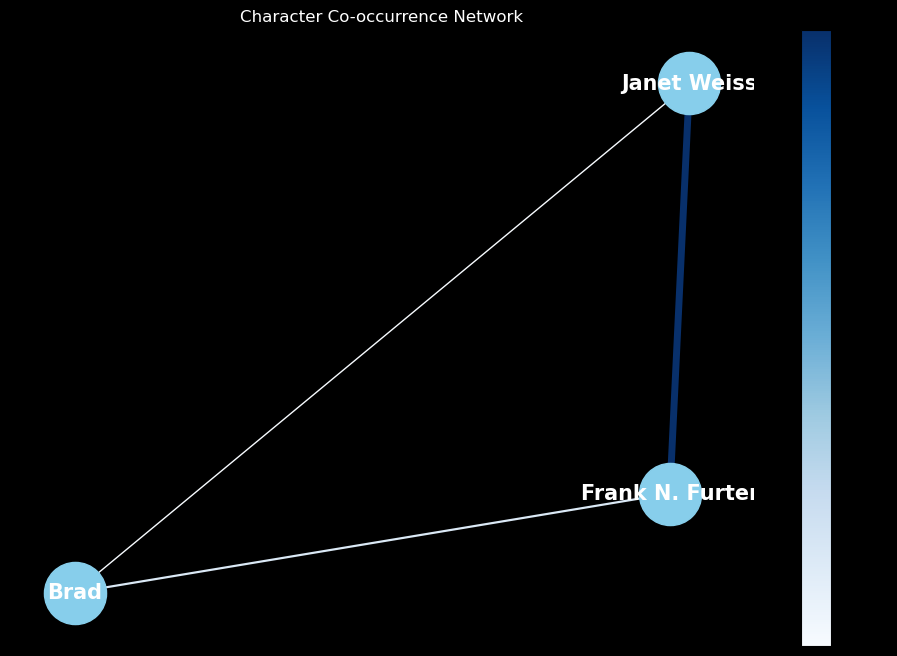

In [56]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/38107357.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##38280799.txt

Sentence: Once Janet's fiancé and his friend arrived to the rescue, Frank ran and put the lady to stand on the floor beside him, keeping her still with one arm around her, activating the Medusa and immediately paralyzing the men.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 16

Sentence: Beside her, Magenta only displayed stoicism and disdain, Riff Raff had a similar expression, yet their eyes were focusing intently on each of Janet's actions.
Characters: ['Janet Weiss', 'Riff Raff', 'Magenta']
Score: 16

Sentence: The last one made Janet shiver and timidly whimper, much to Frank's arousal.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 2

Sentence: yes..."
Janet held the base firmly and licked Frank's tip, already leaking a few drops of precome, and he failed to suppress a sob at the stream of pleasure that coursed through each fiber of his body.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 8

Sentence: She was unable to avoid his gaze, so frightening and so i

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1833321434.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1833321434.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


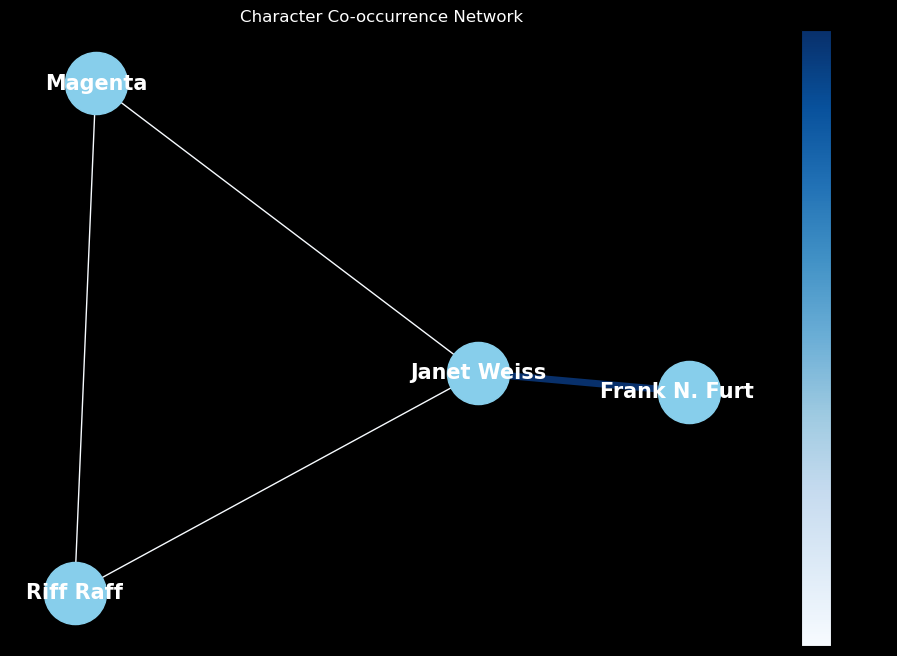

In [57]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/38280799.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##38978856.txt

Sentence: Brad closes his damp eyes gently and holds Janet against him, still trying to keep her safe from the world despite everything they’d been through.
Characters: ['Janet Weiss', 'Brad']
Score: 16

Sentence: ---

Janet buries herself as far as she can into Brad’s bare chest.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Magenta heard Columbia’s cry and stood boldly in front of Riff Raff’s ray gun.
Characters: ['Columbia', 'Riff Raff', 'Magenta']
Score: 6

Sentence: It was the first time Frank had ever seen Magenta look scared.
Characters: ['Frank N. Furter', 'Magenta']
Score: 9

Sentence: But then again, Magenta and her older brother Riff Raff had always been in his life.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: For a time, they were his royal caretakers, Riff Raff more of a sighing older brother and Magenta a good friend to him, despite them being nothing alike at first.
Characters: ['Riff Raff', 'Magenta']
Score: 21

Sentence: “-Then don’t do this for 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4080887281.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4080887281.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


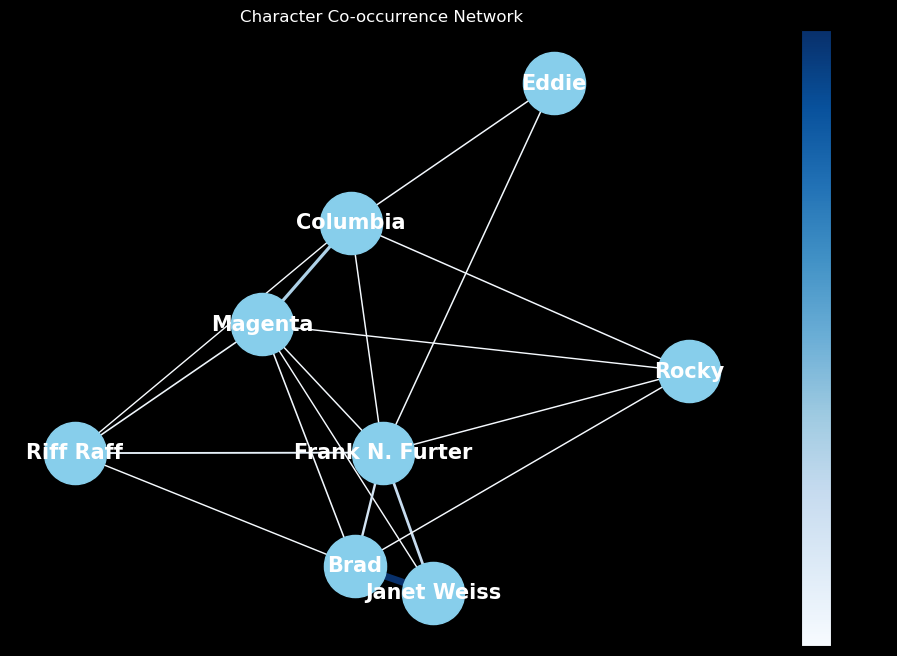

In [58]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/38978856.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##39126051.txt

Sentence: As funny as Eddie's passing and Frank's subsequent comment about it had been, the toll it took on her...
Characters: ['Frank N. Furter', 'Eddie']
Score: 11



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3635281826.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3635281826.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


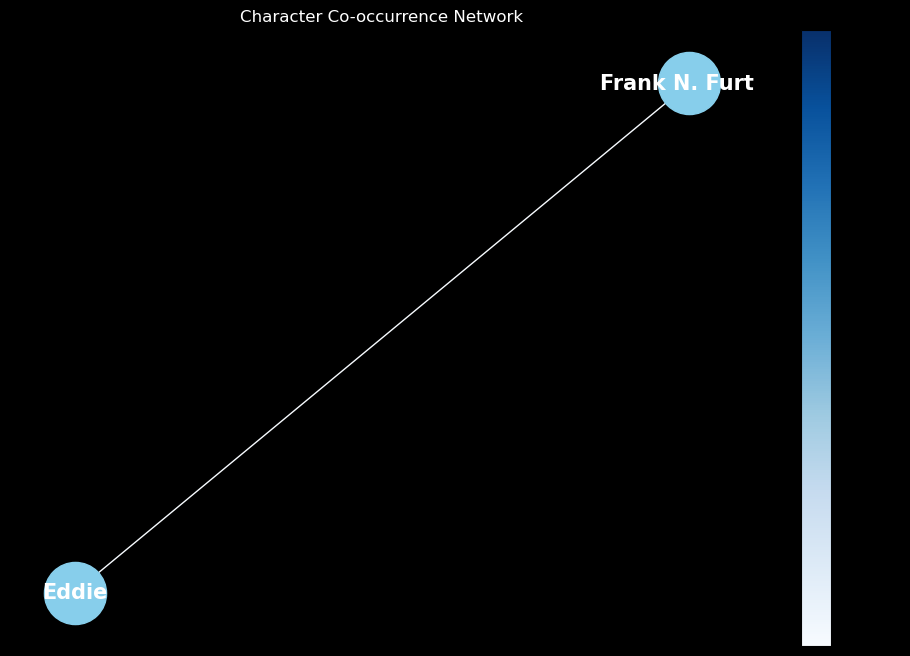

In [59]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/39126051.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##39273348.txt

Sentence: I'm leaving my dressing room in no time", Janet informed Frank behind the closed door.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 12

Sentence: "Let's get going now", he said, matter-of-factly, and they ran to meet Brad and find him standing still at the aim of the sonic transducer Frank had worked relentlessly to design in a single night.
Characters: ['Frank N. Furter', 'Brad']
Score: 28

Sentence: After positioning themselves in front of the device, Janet and Frank held hands and the man in heels activated the switch, and they were automatically transported to France, situated in front of the monumental Palace of Versailles.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 11

Sentence: "Mille-feuille, salad and soup, croque madame, tomato with cheese, and café crème to top it all", Frank listed to an absolutely open-mouthed Janet.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: As they enjoyed their meal, Frank and Janet felt like they co

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/117115806.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/117115806.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


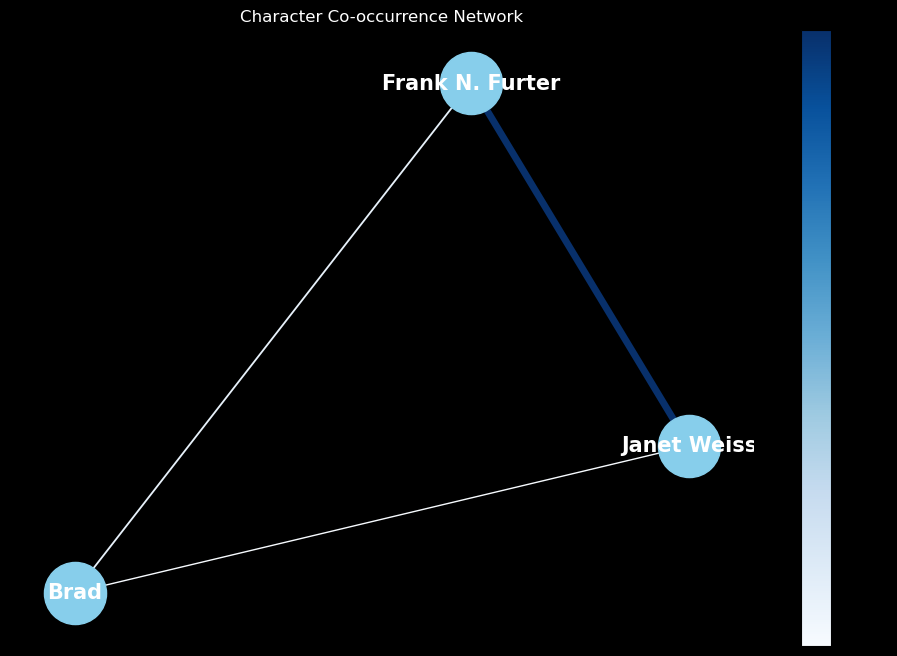

In [60]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/39273348.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##39702837.txt

Sentence: Between quick breaths and kisses all over his shaft, Janet pronounced a sentence with such a deep level of intimacy that made Frank's blood run cold:

"Don't be afraid.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 5

Sentence: In concern, Frank pulled away and eyed Janet with an empathetic look, before softening the tone of his voice and timidly inquiring:

"Sorry.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 8

Sentence: Face resting on Janet's shoulder,Frank's lips curled into a faint smile and quivered as the words naturally rolled off his tongue.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 6

Sentence: Janet put Frank into bed.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: A lustful glimmer spread through Frank's eyes and had him sink between Janet's thighs, his hands spreading them wide, holding each one onto place so firmly and resolutely, the pressure was sure to leave reddish impressions of his fingerprints on her cream

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3122449533.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3122449533.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


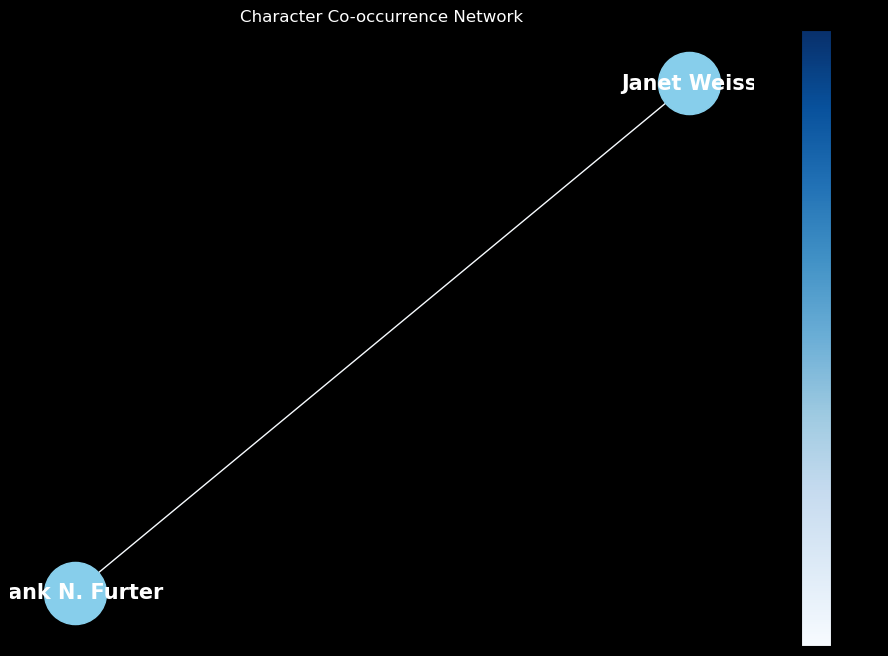

In [61]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/39702837.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##39811401.txt

Sentence: Frank was in bed with Rocky, doing such activities that resulted in a lot of panting and moaning when Magenta came in with some letters that Columbia had already opened out of boredom.
Characters: ['Frank N. Furter', 'Rocky', 'Columbia', 'Magenta']
Score: 14

Sentence: She pulled back the bed curtains open, and after seeing Frank and Rocky engaged in their activities, pulled them back closed.
Characters: ['Frank N. Furter', 'Rocky']
Score: 16

Sentence: Frank and Rocky continued, everyone in the castle was no stranger to seeing each other engage in sexual activities together.
Characters: ['Frank N. Furter', 'Rocky']
Score: 16

Sentence: Rocky belonged to Frank and Frank alone and he made that abundantly clear.
Characters: ['Frank N. Furter', 'Rocky']
Score: 0

Sentence: It was never fully proved, but everyone had even suspected Magenta and her brother Riff-Raff of engaging in such activities too.
Characters: ['Riff Raff', 'Magenta']
Score: 5

Sentence: Magenta knew Frank and 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/49139358.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/49139358.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


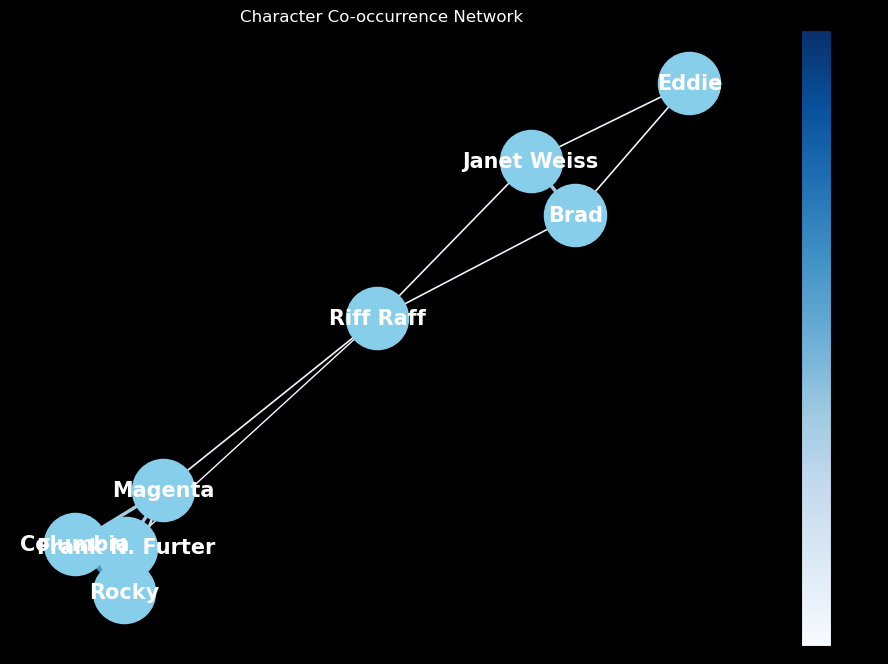

In [62]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/39811401.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##40258689.txt

Sentence: Frank found himself impressively warm, inside and out, entwined with a wonderfully relaxed Janet Weiss.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 5

Sentence: Frank's hand seized her arm and Janet turned to face him, confusion causing her to palpitate.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 12



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/63260916.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/63260916.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


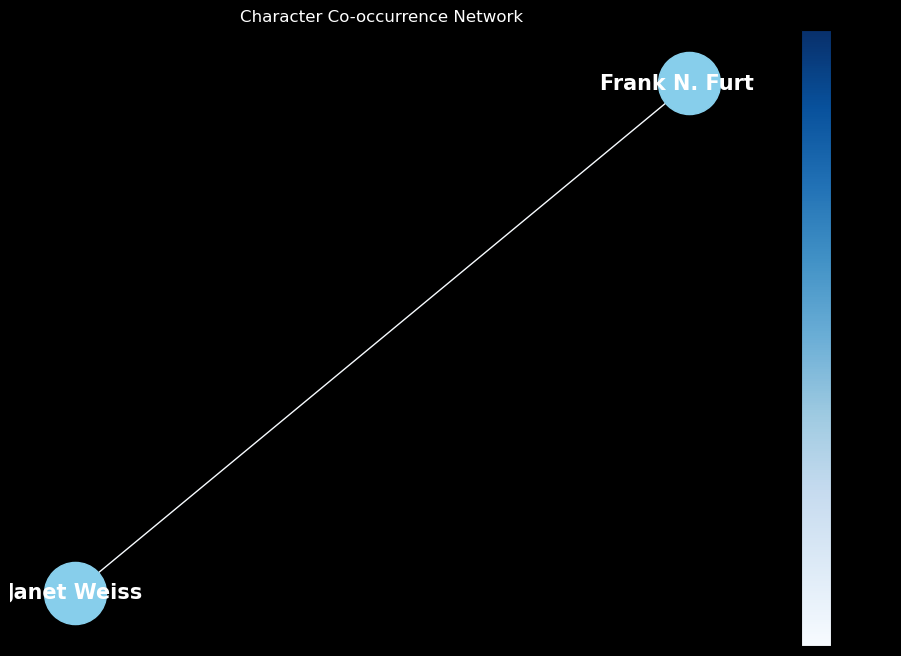

In [63]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/40258689.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##40481862.txt

Sentence: It drew a gasp from you, the combination of Columbia’s assault on your neck and Magenta’s massaging your clitoris making you feel quite content yet elated.
Characters: ['Columbia', 'Magenta']
Score: 9

Sentence: While Magenta was busy, Columbia brought you back to reality, now at your side, taking one of her hands and playing with your nipples.
Characters: ['Columbia', 'Magenta']
Score: 8

Sentence: “Collie,” she said, “would you like to have a go at them?”

Columbia agreed hurriedly, and let Magenta arrange herself to get off the bed in search of a strap-on.
Characters: ['Columbia', 'Magenta']
Score: 17

Sentence: Just as soon as Magenta had left did Columbia get in front of you, her breasts pressing into yours as she kissed you with a fervor that sent a bolt of what felt nearly electric between your legs.
Characters: ['Columbia', 'Magenta']
Score: 13

Sentence: Magenta stopped teasing your nipple, instead bringing her hands to lay on your stomach as she got behind you, her 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4015047682.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4015047682.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


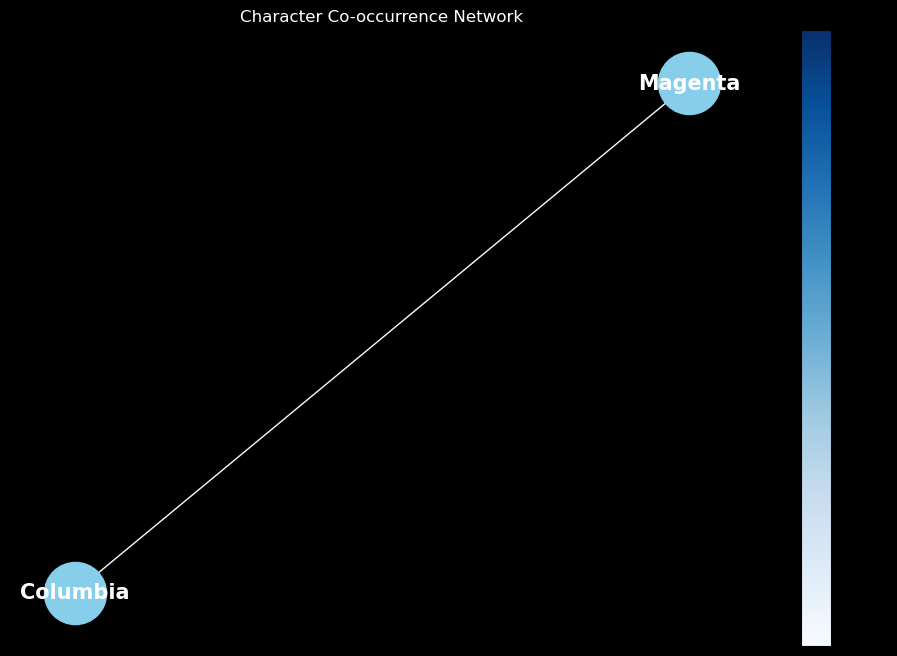

In [64]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/40481862.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##4092298.txt

Sentence: All in all, it’s more than a little alarming, a sensation he can see reflected back at him in Janet’s eyes as she takes a tiny, tentative step forward, stepping over the outflung arm of Riff Raff‘s prone body.
Characters: ['Janet Weiss', 'Riff Raff']
Score: 4

Sentence: It’s evidently not a welcome motion, as Frank snarls through that crimson mouth, an utterly inhuman sound that would be more at home in a cage of wild hyenas, and Janet freezes in place with a little yip of fright.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: “You‘re mad, I get that,” says Janet, in her sweetest and most reasonable voice - the one she uses on toddlers, porch-sitting grannies and small, yappy dogs - “But why don’t you just drop boring ol’ Brad and come on back to bed, huh?
Characters: ['Janet Weiss', 'Brad']
Score: 27

Sentence: With me?”

Seems Brad’s not the only one who thinks giving an angry Frank a swift massage in the libido area is a valid escape plan.
Characters: [

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1372292902.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1372292902.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


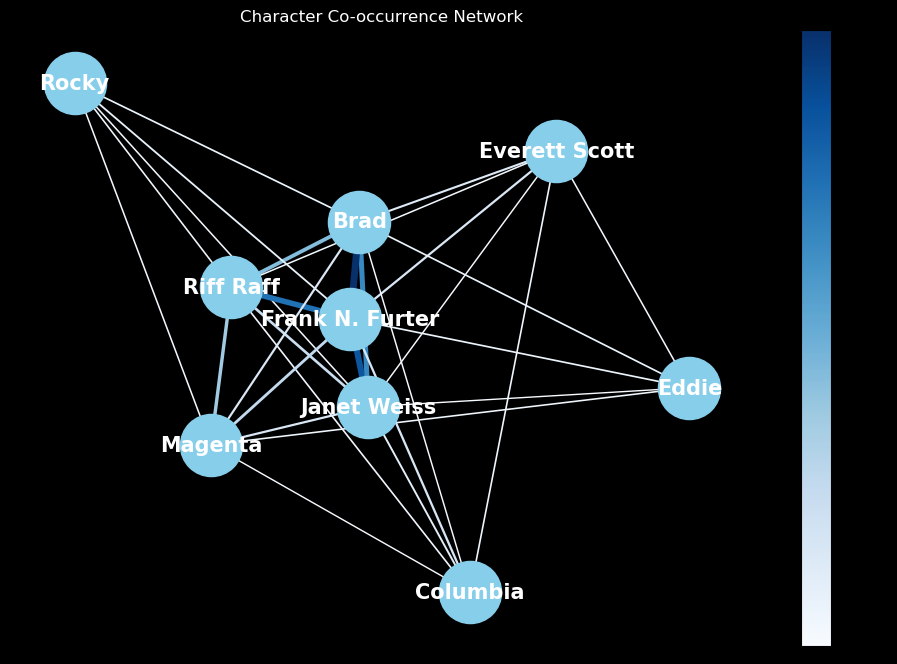

In [65]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/4092298.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##41571429.txt

Sentence: Images of the castle and its inhabitants flashed through his mind, and he still felt the ghost of Frank, Janet, Columbia, and Rocky’s touch brushing against him, his body shivering at the memories.
Characters: ['Frank N. Furter', 'Rocky', 'Columbia', 'Janet Weiss']
Score: 12

Sentence: Another day was beginning, and Brad knew that he had to get out of the car and face Janet and Dr.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: “Morning, Brad.” Janet said, her voice quiet and tired, and he knew that she had been thinking about the exact same things as him.
Characters: ['Janet Weiss', 'Brad']
Score: 5

Sentence: Everything about him was completely different from how Brad remembered him, and yet he seemed more familiar than ever, the events in Frank’s castle bringing them closer than Brad thought possible for teacher and student, but he figured it’d be better to keep someone who had seen the things that Dr.
Characters: ['Frank N. Furter', 'Brad']
Score: 22

Sentence: “

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3683546763.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3683546763.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


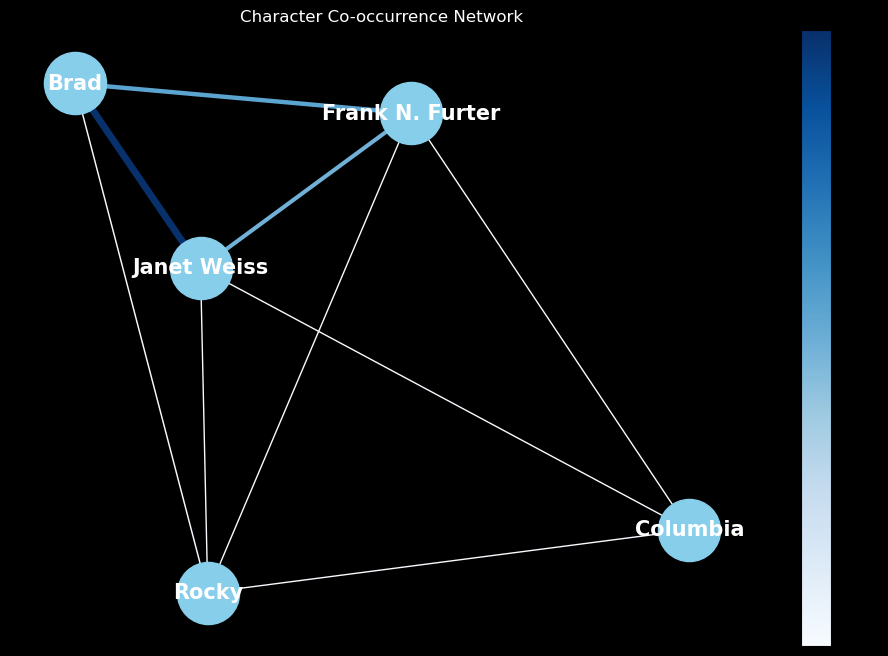

In [66]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/41571429.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##41587494.txt

Sentence: Completely unable to breathe, unlike herself, unlike Brad, her fiancé, who watched it all beside her, unlike Dr Scott, her friend, who was another avid witness.
Characters: ['Brad', 'Everett Scott']
Score: 11

Sentence: Digesting the determined intent exposed in Riff Raff's icy eyes, his loyal sister Magenta standing impassively by his side in her fancy attire matching the one he wore.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: They'd been acting on antagonistic ends to each other earlier, a jealous Frank spitting resentful words, clutching and chasing her, the behavior founded on the trivial competition he'd coined of who Rocky belonged to.
Characters: ['Frank N. Furter', 'Rocky']
Score: 16

Sentence: then, maybe you'd trust the word of the man you're attempting to defend", Magenta reasoned and pointed one gloved finger at Frank's direction.
Characters: ['Frank N. Furter', 'Magenta']
Score: 9

Sentence: Hear me out though, thank you for the clarification."

Th

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/238750989.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/238750989.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


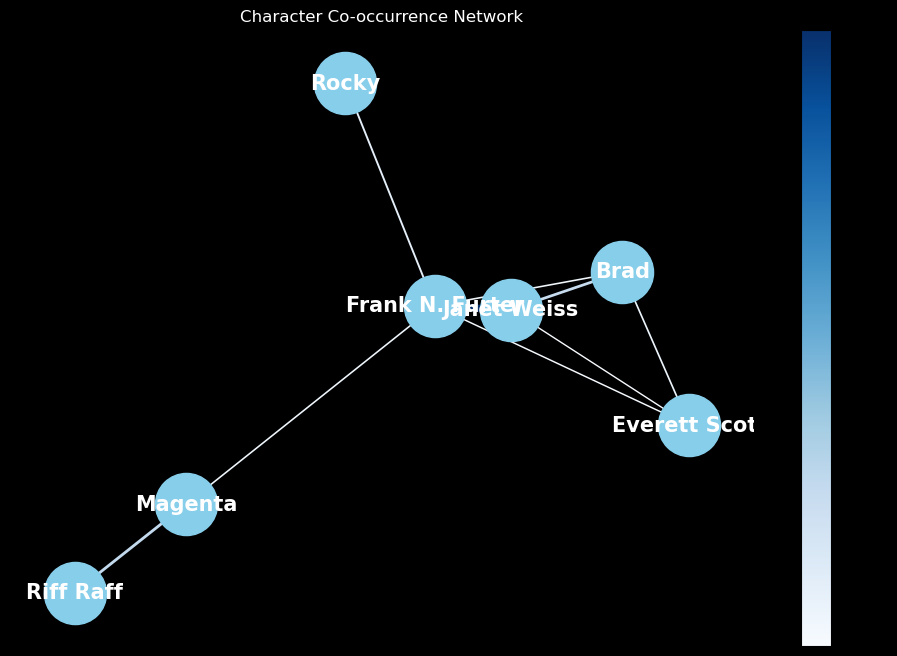

In [67]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/41587494.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##42486444_txt.txt

Sentence: 
Magenta and Riff Raff were soaring through outer space in Frank-N-Furter’s castle, heading back to their home planet of Transexual from Earth.
Characters: ['Frank N. Furter', 'Riff Raff', 'Magenta']
Score: 8

Sentence: Magenta sighed, turning to Riff Raff.
Characters: ['Riff Raff', 'Magenta']
Score: 7

Sentence: Frank I can almost begin to understand, but Columbia!?
Characters: ['Frank N. Furter', 'Columbia']
Score: 4

Sentence: Magenta cornered him, the sheer rage and thirst for revenge in her eyes striking a fear in Riff Raff’s soul he never would have expected to have of his sister.
Characters: ['Riff Raff', 'Magenta']
Score: 4

Sentence: With his left hand now free, Riff Raff managed to reach past Magenta’s neck and shove her aside with a sweep of his arm, but as he did so, Magenta jabbed at him with the knife.
Characters: ['Riff Raff', 'Magenta']
Score: 4



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/43271123.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/43271123.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


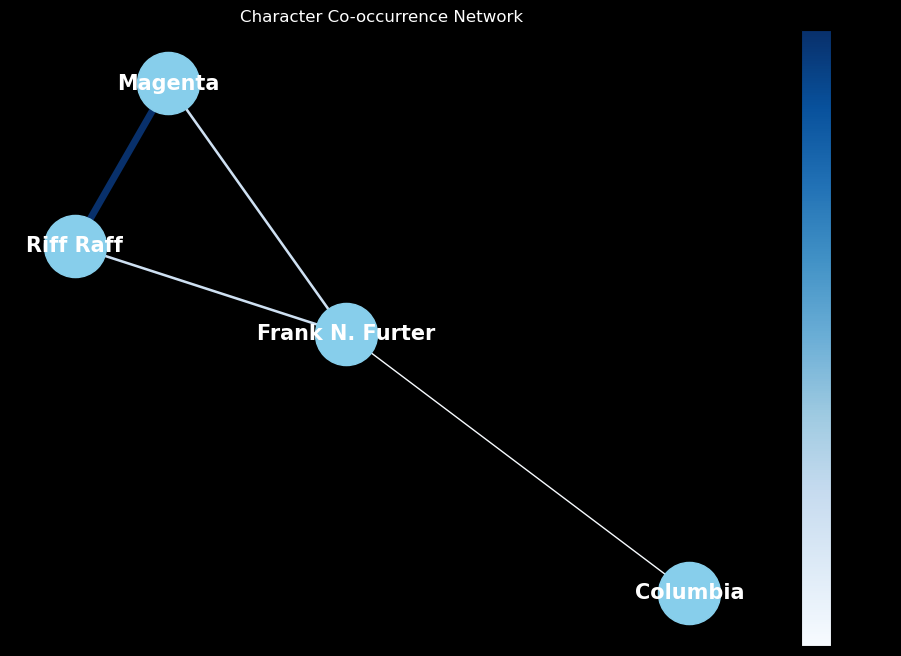

In [68]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/42486444_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##42717156_txt.txt

Sentence: 

first it’s riff-raff and magenta.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: both with long hair - riff’s lanky, magenta’s snarled.
Characters: ['Riff Raff', 'Magenta']
Score: 0

Sentence: of course, he’s still going to go out of his way to seduce this new couple, brad and janet.
Characters: ['Janet Weiss', 'Brad']
Score: 4



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3053687013.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3053687013.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


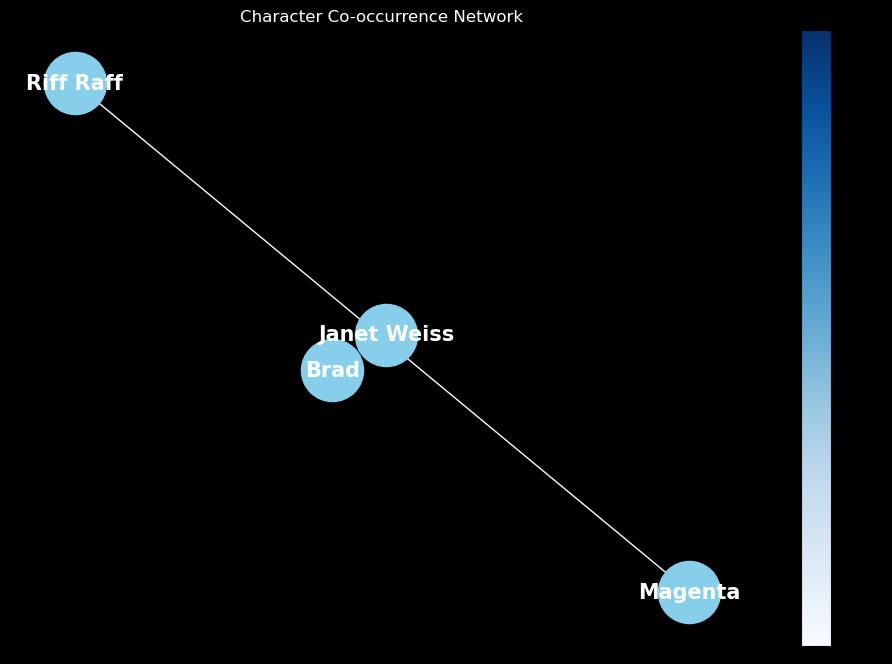

In [69]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/42717156_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##42737817_txt.txt

Sentence: 
“oh,” says columbia, the first time she sees magenta, and promptly forgets how to speak, and from then on, it’s nothin’ but a slippery slope downwards.
Characters: ['Columbia', 'Magenta']
Score: 11

Sentence: magenta’s got a sort of quality that’s…kinda hard to describe, all things considered, so maybe columbia shouldn’t bother tryin’.
Characters: ['Columbia', 'Magenta']
Score: 17

Sentence: yeah, there’s eddie, and columbia loves him to death.
Characters: ['Columbia', 'Eddie']
Score: 5

Sentence: but even eddie would be a lil’ more acceptable outside the house than magenta would, and maybe that’s why columbia likes her so much, chases after her so often.
Characters: ['Columbia', 'Eddie', 'Magenta']
Score: 9

Sentence: magenta and columbia can watch the stupid slut fuck rocky - frank’ll be 
furious, 
won’t he - and yeah, columbia’s still hurtin’ after eddie, but gettin’ to see 
janet 
lose herself all over rocky and thinkin’ she’s 
sooooooo 
good at fuckin’?
Characters: ['Ja

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3547454402.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3547454402.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


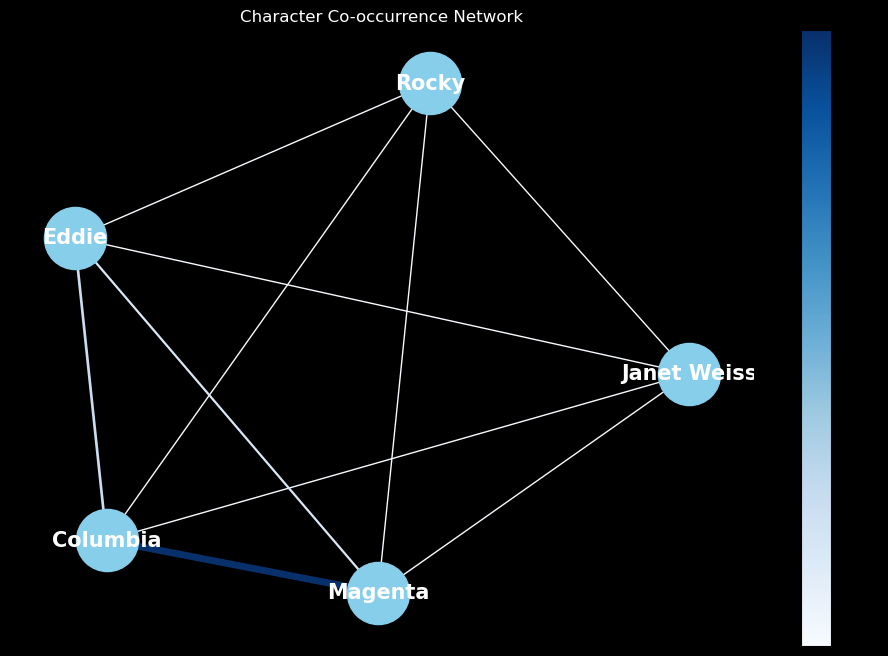

In [70]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/42737817_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##43430671_txt.txt

Sentence: Making a mental note to never knock a human up, Riff Raff gently took their hand, letting them squeeze it as they pushed, crying as Riff Raff kept encouraging them to push.
Characters: ['Riff Raff']
Score: 15

Sentence: "Master, the kid has been born." Riff Raff said as he ran into Frank who was just bored.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 0

Sentence: You're a dad now."


 


All Riff Raff could do was just stare at Frank in shock as he walked off.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 10

Sentence: Magenta offered to stay with Riff for the night to help him out, which he gladly accepted.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: Groaning, Riff Raff got up and walked over to the couch, Magenta and Rainflower were both there, the latter crying their eyes out.
Characters: ['Riff Raff', 'Magenta']
Score: 14

Sentence: Brad and Janet!
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Magenta doesn't exactly get herself pregn

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4194631204.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4194631204.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


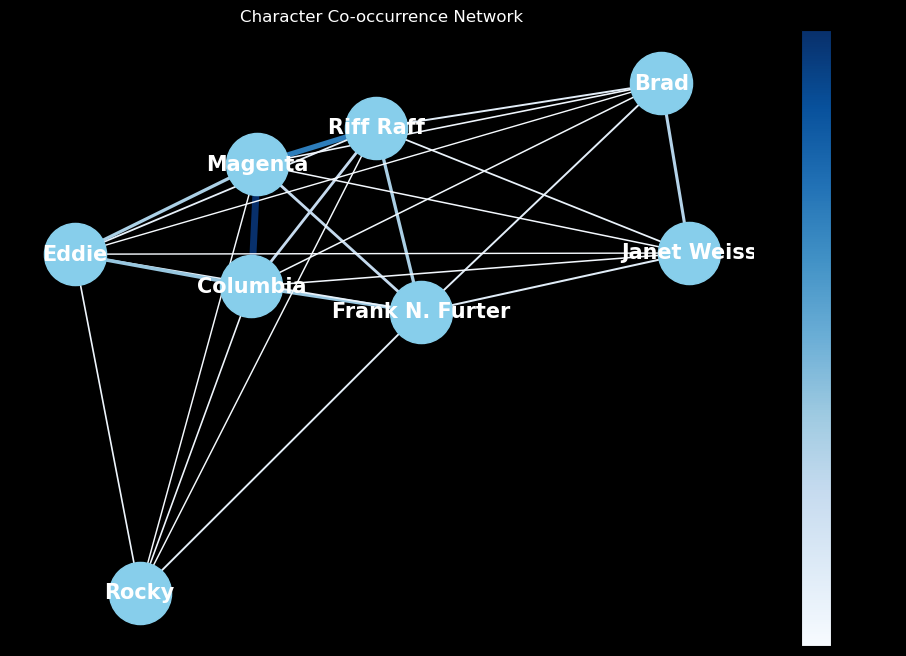

In [71]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/43430671_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##44492005_txt.txt

Sentence: Stretching the broom handle-first across the pool’s surface, Magenta prodded Frank-N-Furter’s body until he drifted close enough to the side for her to grab his arm.
Characters: ['Frank N. Furter', 'Magenta']
Score: 20

Sentence: She knew that Riff Raff had chafed under Frank-N-Furter’s command- he had made that clear on a number of occasions.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 4

Sentence: “Room for one more,” Magenta said, rolling Frank-N-Furter onto his side.
Characters: ['Frank N. Furter', 'Magenta']
Score: 4

Sentence: It was a cool and cloudy night when Frank brought Columbia back to the castle.
Characters: ['Frank N. Furter', 'Columbia']
Score: 4

Sentence: Magenta turned back to Riff Raff and shook her head, smirking.
Characters: ['Riff Raff', 'Magenta']
Score: 6

Sentence: “What a good-looking bunch you all- ah!”
“Riff Raff,” Frank spoke up.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: “Do give Columbia some personal space.” He to

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2502431708.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2502431708.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


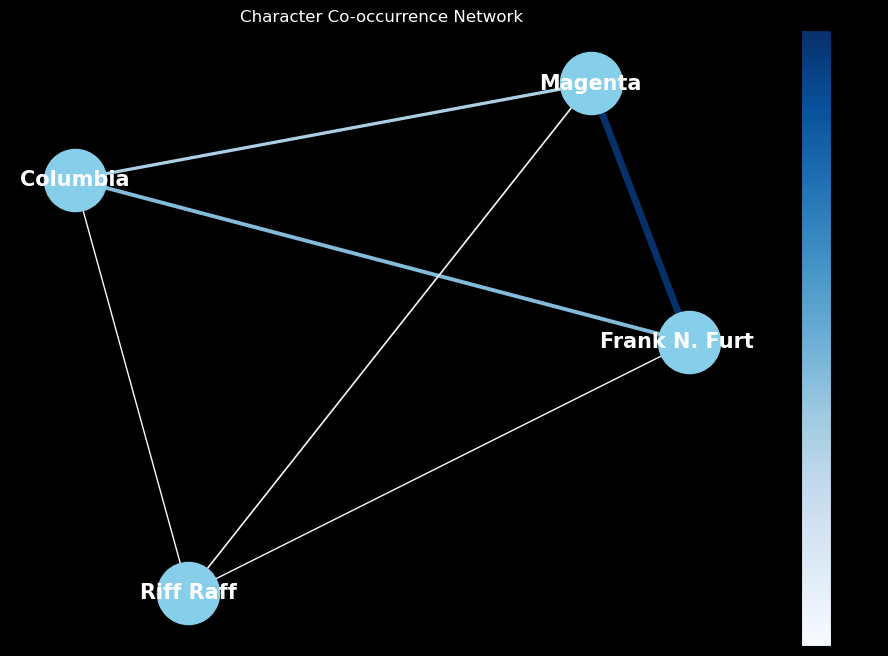

In [72]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/44492005_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##44501146_txt.txt

Sentence: Oh, Janet wanted to run her hands freely all over Frank.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 0

Sentence: Somehow, Janet found the courage and determination within her body to come over behind Frank.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: “Janet, what is it you are doing to me?” Frank asked with mirth in his voice whilst not looking at Janet.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 8

Sentence: “Just feeling you.” Janet whispered, her tongue wetting her upper lip as she finally felt Frank’s back with her own hands.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: Frank let out a small sigh as he closed his eyes to take in the warm sensation of Janet’s hands.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 11

Sentence: Frank looked at Janet with a need in his eyes for her to keep up what she was doing to him.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 9

Sentence: Janet began placin

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2388795685.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2388795685.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


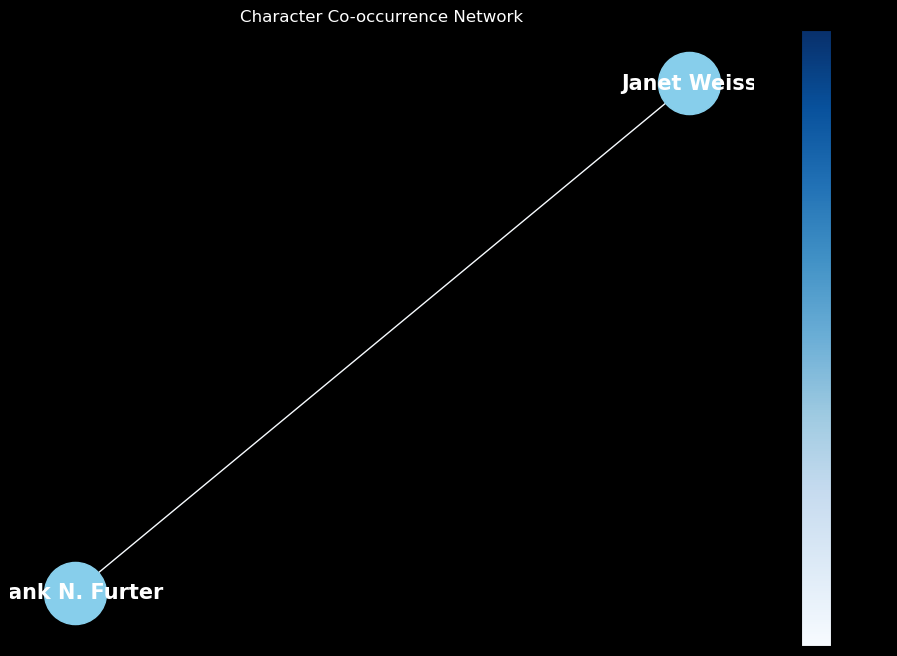

In [73]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/44501146_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##46470013_txt.txt

Sentence: Frank smirked, gently moving his hand to Riff Raff’s lower stomach and gently pressed it.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 2

Sentence: Riff Raff whimpered, squeezing his legs together as Frank got off the bed and got on his knees, looking up at him with a smirk.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 16

Sentence: “You can use me~”


 


Blushing furiously, Riff Raff covered his face,  Frank purred and gently rubbed his lower stomach again.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 16

Sentence: Is that a yes or no~?” He smirked, Riff Raff answered by sitting up straight at the edge of his bed and pointing their penis at Frank, biting his lip a little as they watched Frank wrap his mouth around their cock, giving him a thumbs up.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 23

Sentence: He blushed as they watched Frank happily drink it down, smirking as they looked Riff Raff directly in the eyes.
Characters: ['Frank N. Furter

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4259705280.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4259705280.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


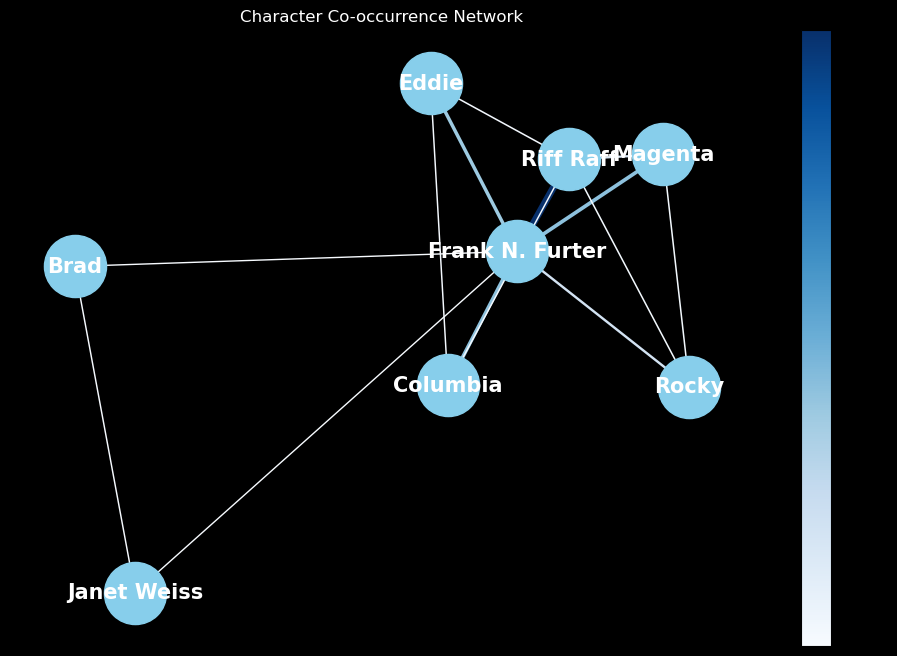

In [74]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/46470013_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##46787956_txt.txt

Sentence: Maybe it was the fact that Janet fainted at the sight of Frank come down on the elevator, and the way she swooned when he moved towards her.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 19

Sentence: He saw the way his hips moved lustrously towards her, the way Frank turned most of his attention towards Janet during his song, the way he simply told Janet not to panic and then never called a mechanic.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 15

Sentence: He hated the way Janet reacted to Frank’s seductive movements.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 9

Sentence: “Brad.” Frank’s voice growls at him, it’s mesmerising.
Characters: ['Frank N. Furter', 'Brad']
Score: 7

Sentence: The conversation is dropped there, a simple chuckle from Frank as he lifts Brad's chin up with just two fingers.
Characters: ['Frank N. Furter', 'Brad']
Score: 10



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1257937228.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1257937228.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


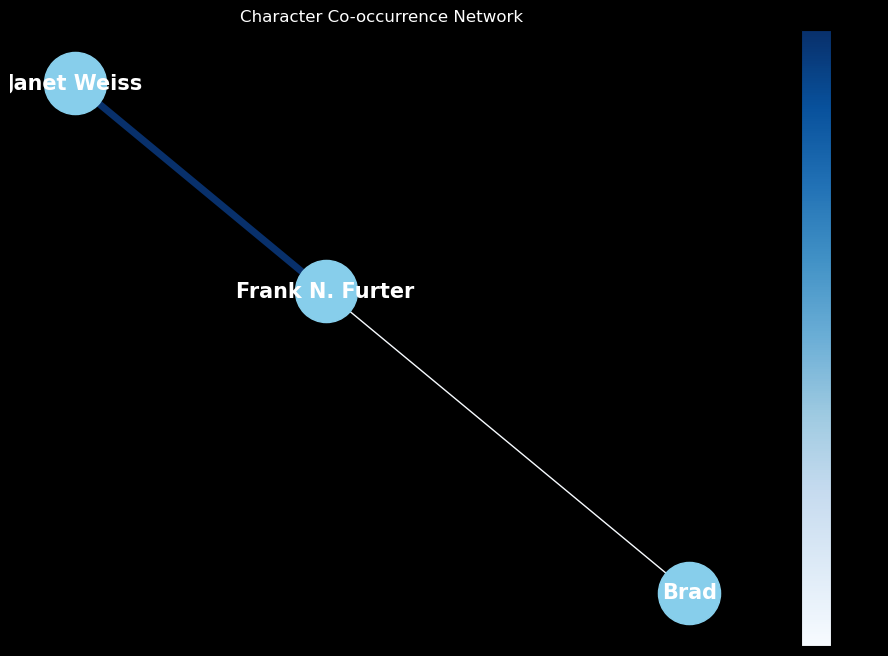

In [75]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/46787956_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##47993905_txt.txt

Sentence: Perhaps the gas used to drug the Rocky and the Earthlings had gotten to her, but even when they, in their drugged state, had been escorted away Riff Raff, to be prepared for the floor show, Magenta continued to sing, loudly, mockingly 


 




“You're a hot dog but you'd better not try to hurt her Frank Furter,








You're a hot dog but you'd better not try to hurt her, Frank Furter...”




 


To calm her down Riff Raff sprayed her with a quick blast of the gas, its effect was instant and Magenta fell silent and stumbled.
Characters: ['Frank N. Furter', 'Rocky', 'Riff Raff', 'Magenta']
Score: 40

Sentence: Columbia, who had been sitting, near catatonic since discovering what they had been eating at dinner had in fact been Eddie instead of Meat loaf, finally snapped out of it, having seen and heard all she could take by this point, and began yelling at Frank whom she had been so devoted to until now




”-You’re like a sponge, you take, take, take and drain others of their

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3133728285.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3133728285.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


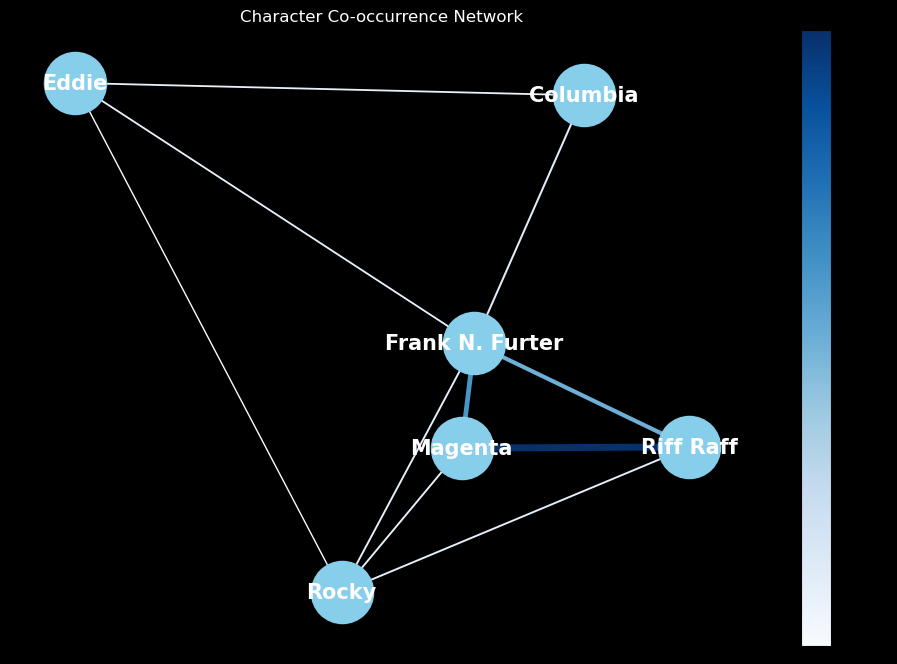

In [76]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/47993905_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49048579_txt.txt

Sentence: Columbia tapped her cigarette out in the ashtray on the bedside table and looked over at Eddie, bringing it back up almost to her mouth.
Characters: ['Columbia', 'Eddie']
Score: 4

Sentence: "I get to meet your friends?" 
"Yeah, but behave yourself, baby, Frankie's a hot one and he'll like you." 
"Yeah?" 
Columbia took another drag on her cigarette and handed it down to Eddie.
Characters: ['Frank N. Furter', 'Columbia', 'Eddie']
Score: 17

Sentence: "Bike." 
"You just saying that because you think it's sexy?"
"Yep." Columbia grinned and kissed Eddie again.
Characters: ['Columbia', 'Eddie']
Score: 15

Sentence: "Eddie, for fuck's sake-!" 
"What'm I gonna do there all day?" 
"Bring a magazine, watch porn on the TV, Frankie doesn't fucking care." Columbia tossed her head up to look at the ceiling.
Characters: ['Frank N. Furter', 'Columbia', 'Eddie']
Score: 23

Sentence: Columbia took off her goggles, squinted up at the clouds, and beckoned Eddie to follow her inside.
Characters:

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1076972278.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1076972278.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


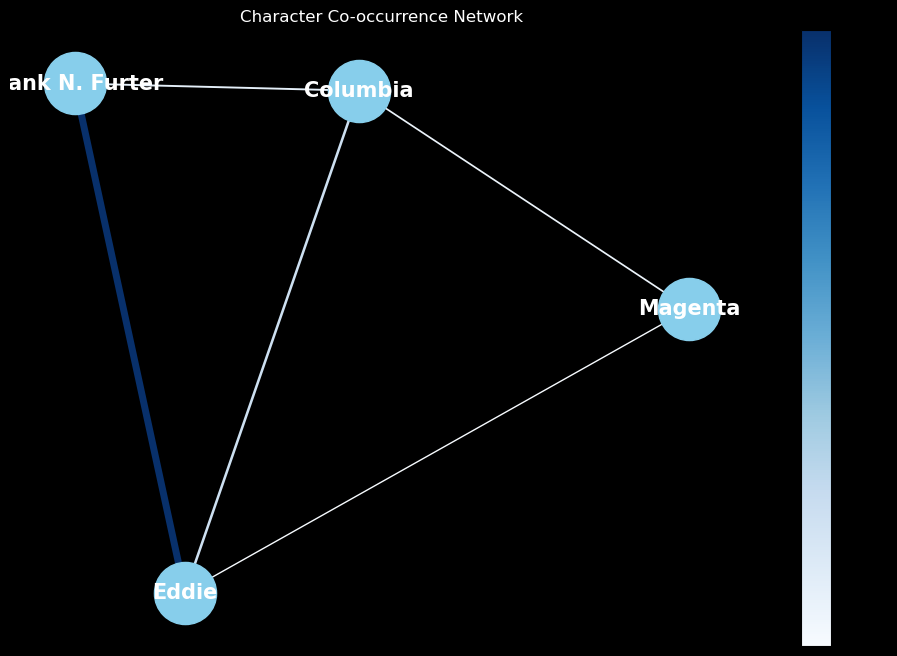

In [77]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49048579_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49190599_txt.txt

Sentence: It had taken Magenta a good 40 minutes to calm Columbia down from the hysterical sobbing mess that she was previously.
Characters: ['Columbia', 'Magenta']
Score: 12

Sentence: Now that she thought about it, Magenta was always very gentle with Columbia.
Characters: ['Columbia', 'Magenta']
Score: 1

Sentence: Despite her voice and her absurd interest in tap dancing, which she ultimately grew used to and even loved, Magenta never did anything to hurt her, unlike Frank.
Characters: ['Frank N. Furter', 'Magenta']
Score: 18

Sentence: Maybe it was the fact that she was always the one to comfort Columbia each time she was thrown into tears, as that wasn’t Riff Raff’s particularly favorite thing to do nor was he any good at it, but it didn’t matter.
Characters: ['Columbia', 'Riff Raff']
Score: 13

Sentence: Magenta gently closed the door behind her as she left the room her and Columbia shared.
Characters: ['Columbia', 'Magenta']
Score: 8

Sentence: Riff Raff was out here waiting for 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2167321626.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2167321626.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


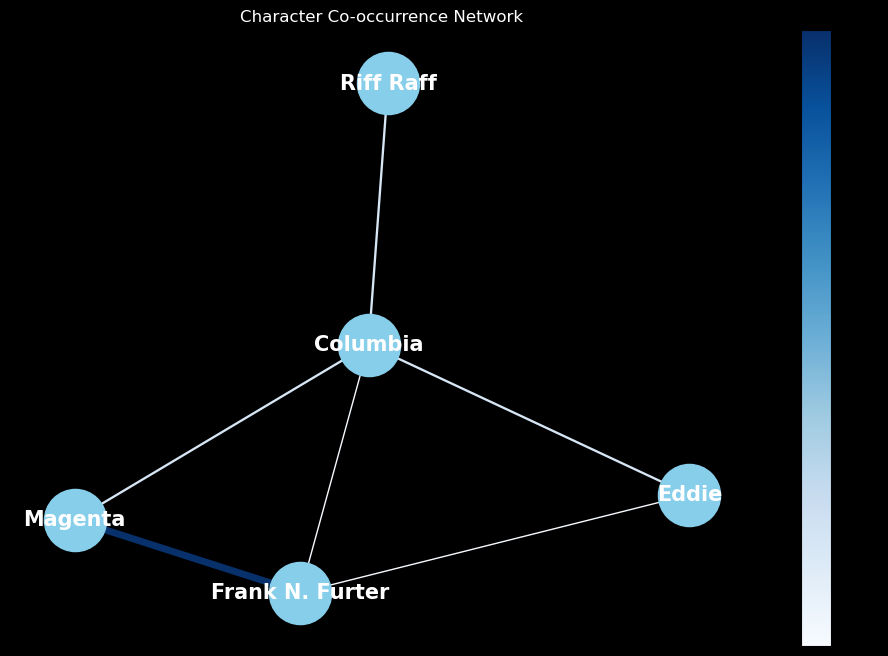

In [78]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49190599_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49230934_txt.txt

Sentence: Frank-N-Furter, had provided them with a place to stay for the night, he had, for some reason, put her and Brad in separate rooms, even though they were engaged.
Characters: ['Frank N. Furter', 'Brad']
Score: 8

Sentence: After Frank had taken his creation, the tanned, beach blonde, muscular hunk of a man he had dubbed Rocky Horror, off to bed in the biblical sense, Janet and Brad had been led to separate rooms by the butler, Riff Raff, and his sister, Magenta, who also served as the maid.
Characters: ['Janet Weiss', 'Rocky', 'Riff Raff', 'Magenta', 'Brad', 'Frank N. Furter']
Score: 4

Sentence: So the two of them, at least, also had to still be somewhere in the mansion in addition to Frank and Rocky, didn’t they?
Characters: ['Frank N. Furter', 'Rocky']
Score: 0

Sentence: If she remembered correctly, she could take this elevator to the lab where Frank had given Rocky life.
Characters: ['Frank N. Furter', 'Rocky']
Score: 9

Sentence: And while witnessing the transexual mad d

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3393347237.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3393347237.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


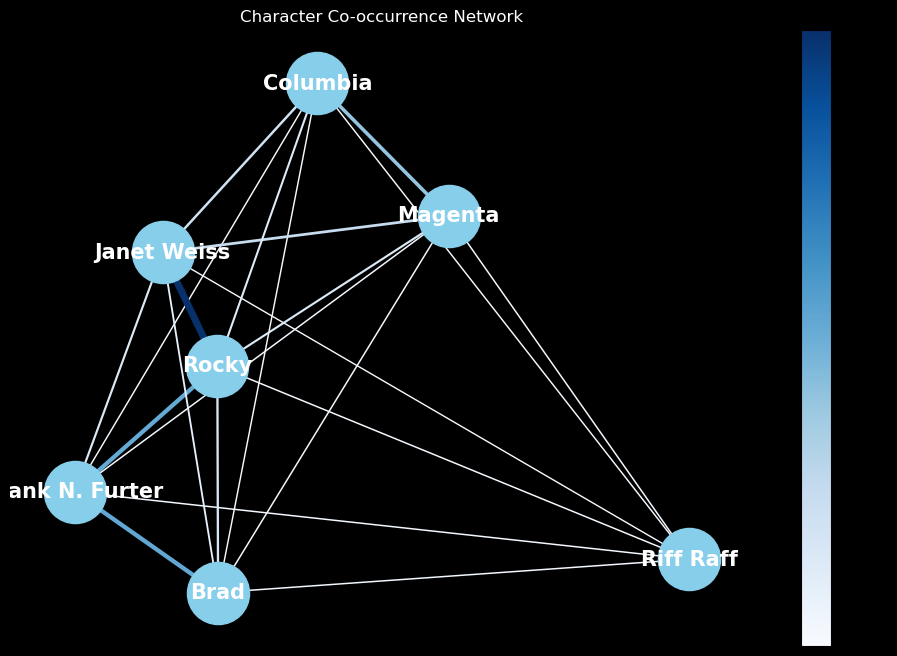

In [79]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49230934_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49454569_txt.txt

Sentence: Brad grasped at Franks hair he couldn't decide whether he wanted to push his head off of his dick or pull him further onto it.
Characters: ['Frank N. Furter', 'Brad']
Score: 13

Sentence: Frank however didn't care as he was savouring all the noises Brad was making.
Characters: ['Frank N. Furter', 'Brad']
Score: 5

Sentence: "Don't!"
"Beg then."
"Frank p-please I just please...Don't stop please, I-I'm so c-close I swear please-"
"Alright dear."
"Mmm!" Frank loved when Brad made such seductive noises especially when Frank himself was causing them.
Characters: ['Frank N. Furter', 'Brad']
Score: 17

Sentence: Nice!" Frank loved this he loved the praise, the noises, the little twitches Brad would make, everything.
Characters: ['Frank N. Furter', 'Brad']
Score: 10

Sentence: Brad grasped at Franks curly black hair, moaning as he tried to make the "show" last longer.
Characters: ['Frank N. Furter', 'Brad']
Score: 11

Sentence: Frank smiled as Brad spilled into his mouth, moaning as 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3788254766.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/3788254766.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


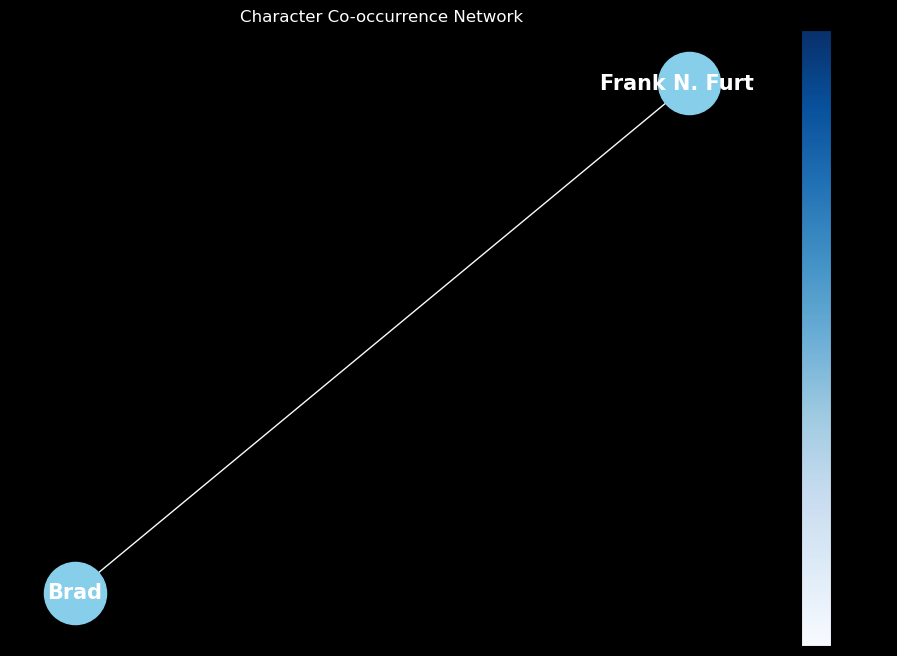

In [80]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49454569_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49753975_txt.txt

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/973296107.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/973296107.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


Sentence: Janet had been imagining her first time with Brad since they started dating.
Characters: ['Janet Weiss', 'Brad']
Score: 0

Sentence: Janet knew she should feel awful; she had cheated on Brad, the love of her life, with someone she had known for hardly an hour.
Characters: ['Janet Weiss', 'Brad']
Score: 10

Sentence: Huge pictures of Eddie are plastered on the walls and Janet feels a wave of nausea remembering the fate he met only an hour ago.
Characters: ['Janet Weiss', 'Eddie']
Score: 18

Sentence: “He’s good looking and all, but I can’t believe Frankie cast Eddie and I aside for a total meathead.” 




“And lord knows you would never love a meathead,” the maid teases.
Characters: ['Frank N. Furter', 'Eddie']
Score: 20

Sentence: “Eddie had more substance than people realized.” Columbia says it firmly and neither Janet nor the maid press her further.
Characters: ['Janet Weiss', 'Columbia', 'Eddie']
Score: 3

Sentence: ”




Janet realizes that the maid knows what conspired b

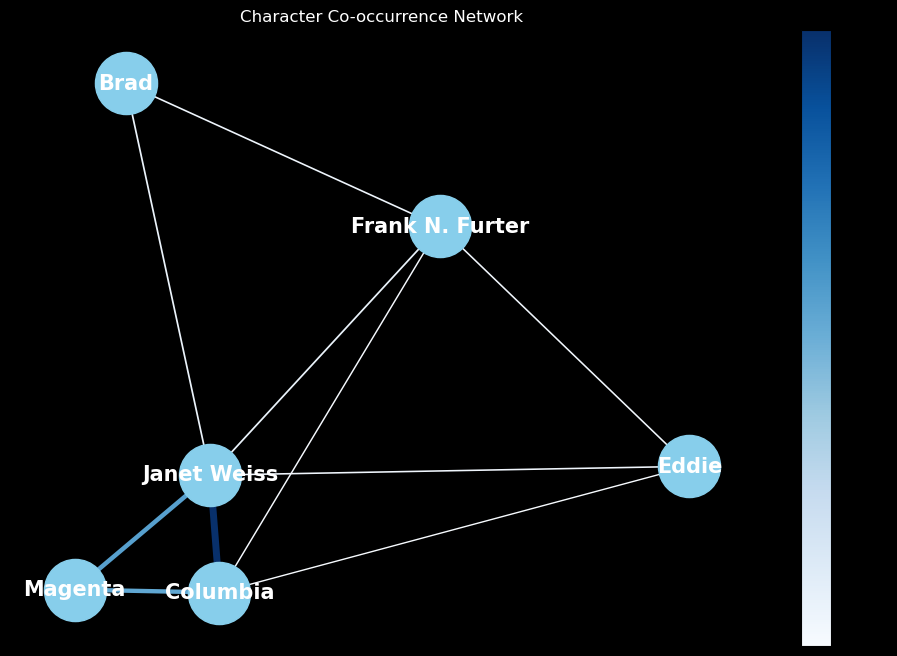

In [81]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49753975_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##49808935_txt.txt

Sentence: Columbia had been with Eddie and his band for 3-4 months now, acting as their groupie.
Characters: ['Columbia', 'Eddie']
Score: 4

Sentence: It was early in the morning, and as perusal, Eddie and Columbia were the only ones awake.
Characters: ['Columbia', 'Eddie']
Score: 0

Sentence: Eddie was driving the band's van, while Columbia sat in the passenger seat right next to him.
Characters: ['Columbia', 'Eddie']
Score: 4

Sentence: Chapter Summary


Columbia and Eddie have a show in Denton and they finally meet some new, and rather intriguing, faces


Chapter Notes


Hi all!!!
Characters: ['Columbia', 'Eddie']
Score: 12

Sentence: Eddie and Columbia were sitting on the stage together while everyone else was getting ready to leave.
Characters: ['Columbia', 'Eddie']
Score: 12

Sentence: As the two moved closer, Columbia and Eddie got a better look at them.
Characters: ['Columbia', 'Eddie']
Score: 16

Sentence: They were both very attractive to both Columbia and Eddie.
Characters: 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2398118666.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2398118666.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


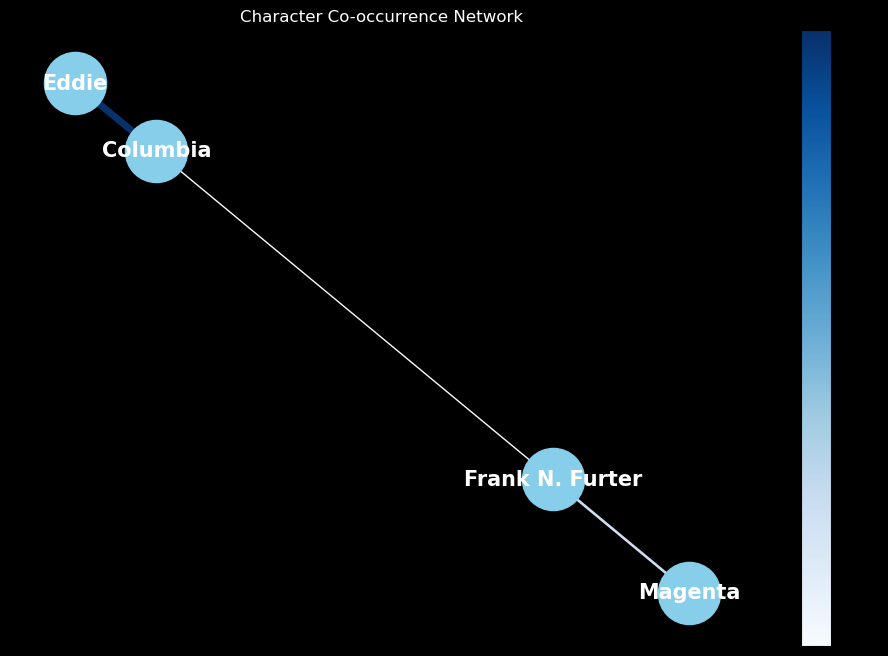

In [82]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/49808935_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##50729368_txt.txt

Sentence: eddie likes fucking frank - sure, they all like fucking frank, no matter how badly he treats them - but if he's being perfectly honest, he likes fucking columbia much more.
Characters: ['Columbia', 'Eddie']
Score: 9

Sentence: still, columbia fits nicely into the little cozy spot formed by the crook of eddie's elbow, strewn atop eddie's bed like so.
Characters: ['Columbia', 'Eddie']
Score: 5



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1802711419.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1802711419.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


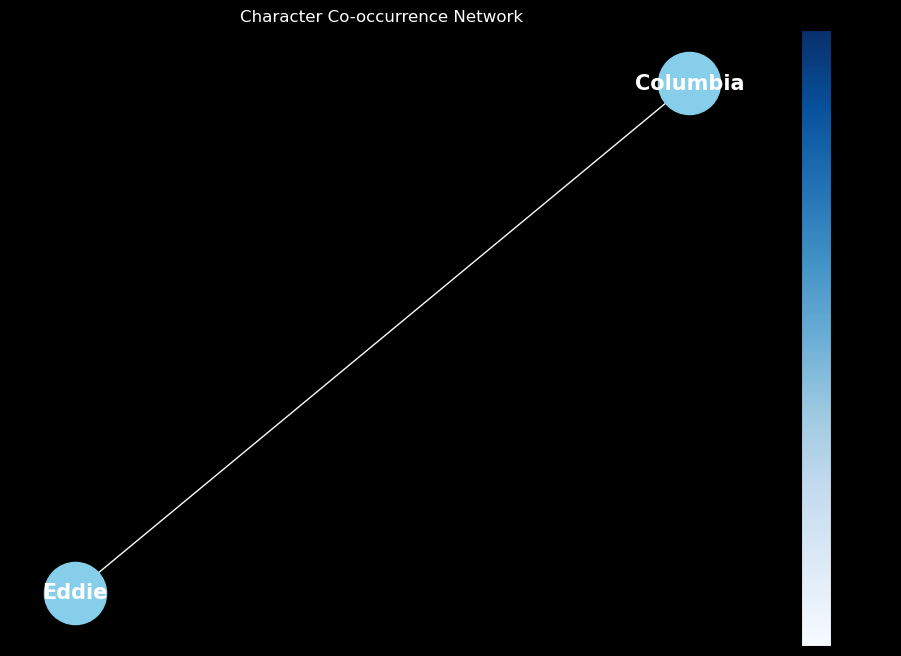

In [83]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/50729368_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##50886793_txt.txt

Sentence: "Ah shit," I said as i had managed to make the scar on my forehead bleed as i hit the floor "You good?" My dad asked "Yea," I responded "Crashing a motorcycle is worse," I said "Eddie she's crashed a bike before?" My mom asked "Wait did you crash a bike?" He asked "Fuck I said too much didn't I?" I asked myself out loud "Not as bad as rocky being the bastard he is snitching on me to Frank," Riff Raff said "He did what?" I asked "He snitched on me to Frank." "Rocky sniches means and stitches means no bitches!" I shouted half way across the room "Mind your language." Frank said "Oh fuck off you gay bastard," I said which resulted in everyone starring at me in horror apart from my dad -Eddie- he used said way worse things but his own child saying things like he did?
Characters: ['Frank N. Furter', 'Rocky', 'Eddie', 'Riff Raff']
Score: 34

Sentence: I rolled my eyes as I knew that evreyone had started mumbling against themselves "The kids nerve," Magenta said to her brother- or r

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/721617592.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/721617592.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


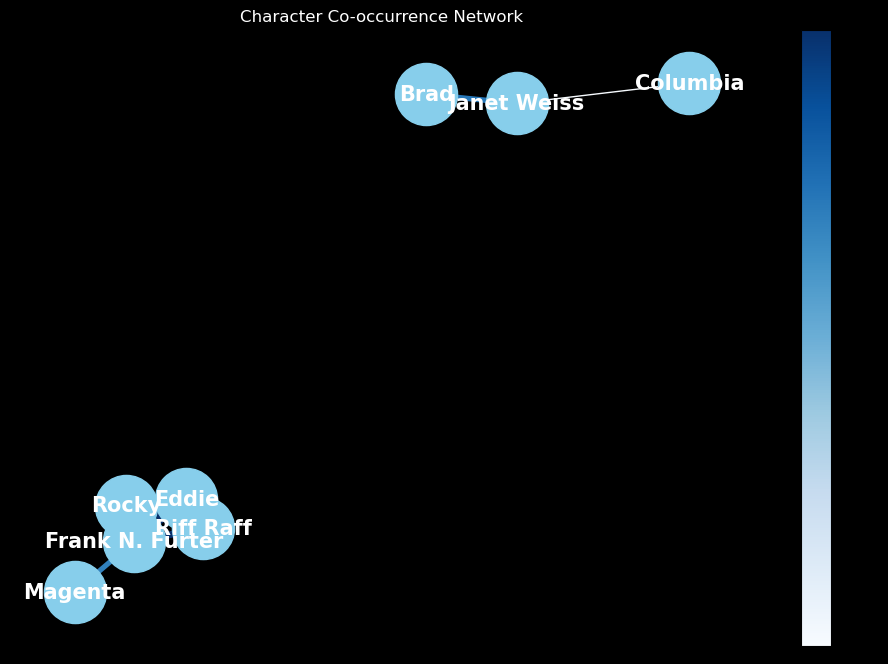

In [84]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/50886793_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##51255037_txt.txt

Sentence: The night Columbia had lost Eddie.
Characters: ['Columbia', 'Eddie']
Score: 0

Sentence: Magenta was never fond of Eddie.
Characters: ['Eddie', 'Magenta']
Score: 0

Sentence: She knew that Columbia’s heart was still signed by Eddie, and yet she decided to love her anyway.
Characters: ['Columbia', 'Eddie']
Score: 10

Sentence: She suddenly understood Columbia’s resentment for Frank.
Characters: ['Frank N. Furter', 'Columbia']
Score: 0

Sentence: She wished she could have persuaded Columbia to join her, lead with her, instead of Riff Raff!
Characters: ['Columbia', 'Riff Raff']
Score: 5

Sentence: “Brother?” Magenta demanded; her voice filled with a certain authority she’d only ever heard Frank use.
Characters: ['Frank N. Furter', 'Magenta']
Score: 9

Sentence: Magenta smirked, her gaze set on Riff Raff.
Characters: ['Riff Raff', 'Magenta']
Score: 2

Sentence: Magenta laughed softly, pinning Riff Raff to the wall with her weapon.
Characters: ['Riff Raff', 'Magenta']
Score: 2



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/137825303.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/137825303.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


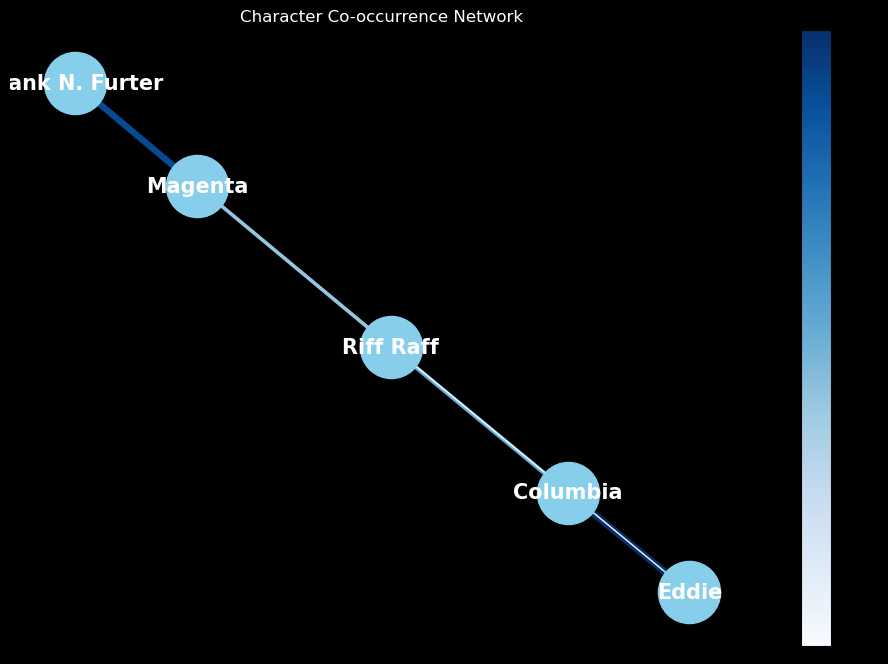

In [85]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/51255037_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##51274501_txt.txt

Sentence: And on the one week anniversary of the debacle that had been meeting Frank and … everything else that happened (which he and Janet had only talked about as much was absolutely necessary to establishing the continuing existence of their marriage), his memories weren’t helping.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 8

Sentence: And Frank was one beast, this velvety androgynous sex dream come to life and crawling into his bed, but Janet was another.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 5

Sentence: A flash of Frank crossed Brad’s mind, how he’d probably done the same to Janet’s skin.
Characters: ['Frank N. Furter', 'Brad', 'Janet Weiss']
Score: 8

Sentence: She didn’t want Frank, or Rocky.
Characters: ['Frank N. Furter', 'Rocky']
Score: 0

Sentence: It was definitely different than with Frank— Janet is far more careful with him, coaxing him.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 5

Sentence: And no offense to the long-legged alien

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1648363914.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1648363914.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


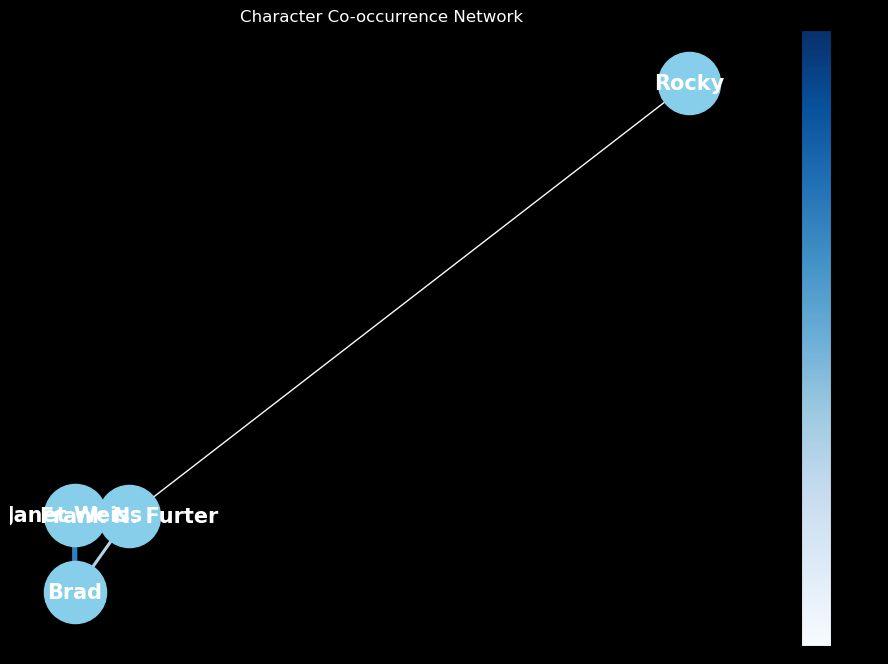

In [86]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/51274501_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##51817627_txt.txt

In [87]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/51817627_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


ValueError: min() arg is an empty sequence

In [ ]:
##51831301_txt.txt

In [88]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/51831301_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


ValueError: min() arg is an empty sequence

In [ ]:
##52511266_txt.txt

Sentence: For Janet and Frank, it also meant reading and long conversations by the fireplace.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 4

Sentence: And, as the night of Christmas arrived, after a sumptuous supper, Janet and Frank returned to the balcony and watched the clear starry sky, twinkling rhythmically and offering them a breathtaking view to finish their celebration.
Characters: ['Frank N. Furter', 'Janet Weiss']
Score: 27



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/515091874.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/515091874.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


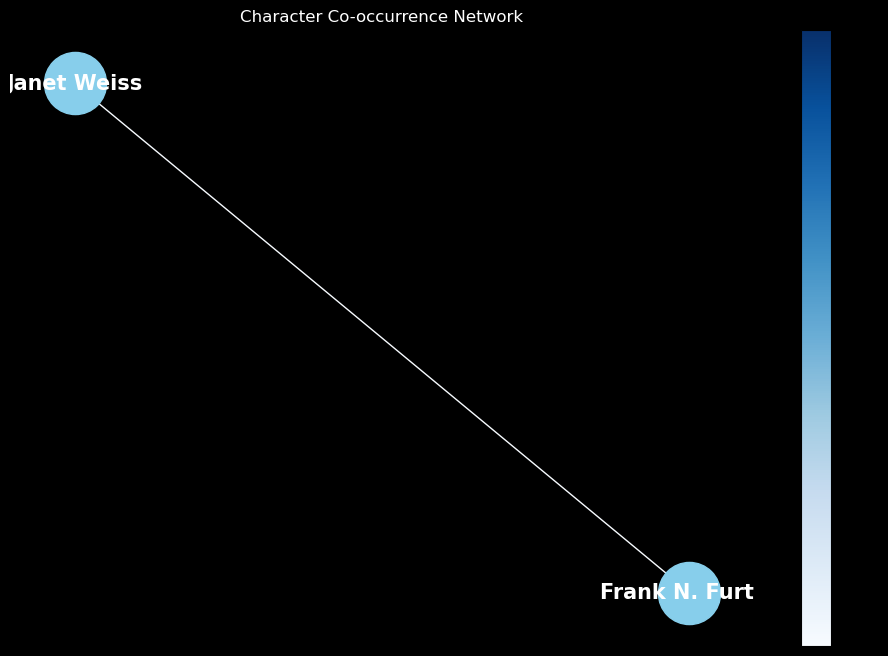

In [89]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/52511266_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##52540231_txt.txt

Sentence: Riff Raff was so focused on his great moment that he never saw Magenta raise her own weapon behind him.
Characters: ['Riff Raff', 'Magenta']
Score: 12

Sentence: Magenta simply held out her arm, and Columbia rushed to her side.
Characters: ['Columbia', 'Magenta']
Score: 0

Sentence: "Yes, I guess that explains it."
When Magenta pulled back from the kiss, a panting Columbia snuggled into her neck.
Characters: ['Columbia', 'Magenta']
Score: 13

Sentence: "You have to stop making such a spectacle of yourself, however," Magenta told Frank sternly.
Characters: ['Frank N. Furter', 'Magenta']
Score: 4

Sentence: "Rocky!" Frank called, beckoning.
Characters: ['Frank N. Furter', 'Rocky']
Score: 3

Sentence: Rocky glanced at Janet quickly, then scuttled over to Frank's side.
Characters: ['Frank N. Furter', 'Rocky', 'Janet Weiss']
Score: 4

Sentence: Once he was wrapped tightly in Frank's arms, Magenta turned her weapon on the three humans, and light enveloped them.
Characters: ['Frank 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1001172480.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1001172480.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


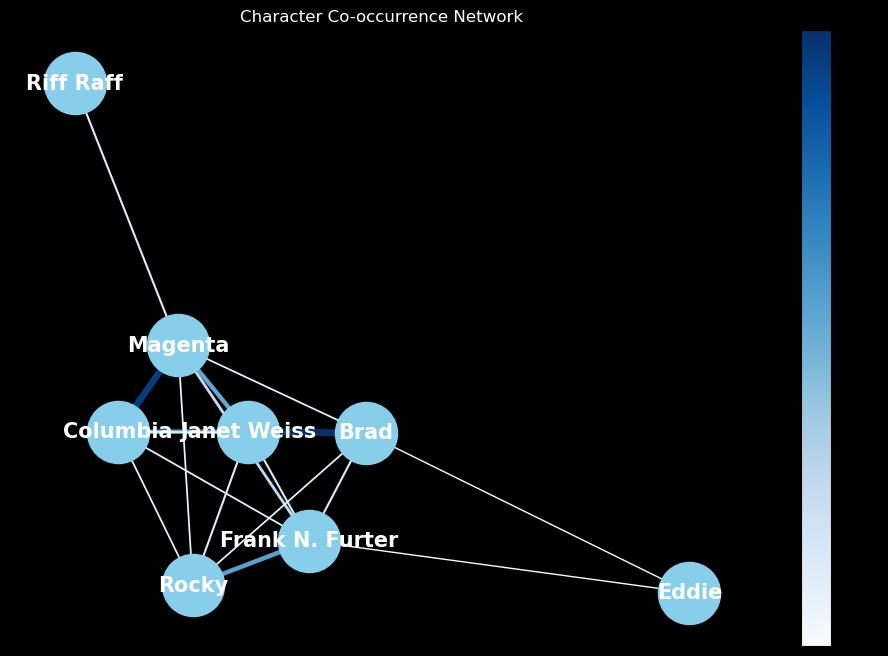

In [90]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/52540231_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##52744153_txt.txt

Sentence: And later, when they were back in good old Denton; a bottle of scotch being shared between them; Janet and Brad talked over things in his apartment.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: Brad’s loving kisses and gentle movements were a stark contrast to the passionate and frenzied actions of another, and Janet couldn’t tell whether she should be feeling thankful or disappointed from the dissimilarity.
Characters: ['Janet Weiss', 'Brad']
Score: 26

Sentence: Coming close to her ear, his warm breath blowing against the shell of it:
 
“So do I.”
 
Janet felt tears spring to her eyes, a reaction that surprised Brad.
Characters: ['Janet Weiss', 'Brad']
Score: 17

Sentence: Having attended Betty and Ralph’s baby shower 3 months later (and drinking one too many beers from the coolers), Janet had asked Brad to leave early to avoid the usual embarrassment that accompanies too much alcohol at events; the two deciding to head to a local diner to eat.
Characters: ['Jane

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1484155140.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1484155140.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


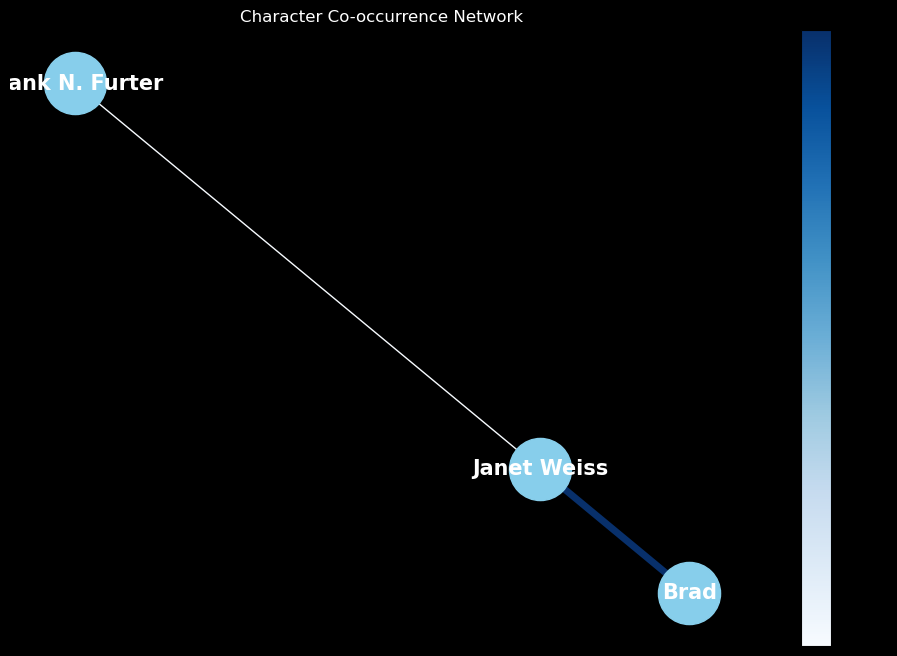

In [91]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/52744153_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##52865872_txt.txt

Sentence: Heroes are rare.”

- James Baldwin, “Giovanni’s Room”






It was only when the sexy, semi-homicidal extraterrestrial transvestite mad scientist sleeping on his family’s couch started coughing up blood that Brad Majors was finally forced to admit out loud to his fiancée Janet (and somewhat himself) that, just maybe, 




perhaps




, there had been a slight change of plans and the circumstances under which they’d gotten engaged had been irreparably altered a teeny bit.
Characters: ['Janet Weiss', 'Brad']
Score: 36

Sentence: There was only so much Brad and Janet could do to convince him of his own sickness without an otherworldly hurricane of polished nails hurtling their way.
Characters: ['Janet Weiss', 'Brad']
Score: 8

Sentence: It seemed Frank hadn’t thought to tell them this had been happening at all— just continued to throw the tissues noncommittally in the general direction of the garbage can— then decided to act all nonchalant upon Janet nearly tripping over one of 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/695572004.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/695572004.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


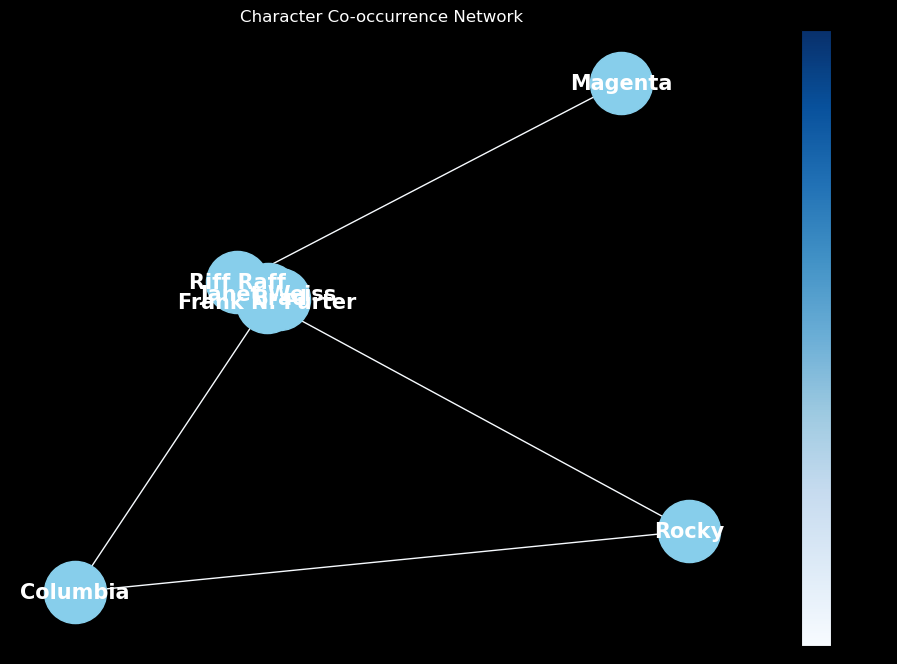

In [92]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/52865872_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##53459851_txt.txt

Sentence: Should he have Magenta tell Frank that he was ill?
Characters: ['Frank N. Furter', 'Magenta']
Score: 7

Sentence: Thankfully, Frank had his back to the door, and Riff walked quietly enough that he hadn’t yet drawn his attention.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 8

Sentence: He stood motionless in place, listening as Frank questioned Magenta imperiously.
Characters: ['Frank N. Furter', 'Magenta']
Score: 0

Sentence: They stared at each other for a moment, Riff silently cursing everything that had led him to this moment—the drugs, the Earthling who’d failed to show up, the project, this wretched planet, the very circumstances of his birth, and above all, Frank N.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 14

Sentence: “I was unable to find anything of suitable quality.”

Frank watched him, green eyes narrowed, until Riff finally remembered to add "...Master." The word always left a vile taste in his mouth; calling anyone "Master" did not come natura

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2511411126.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2511411126.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


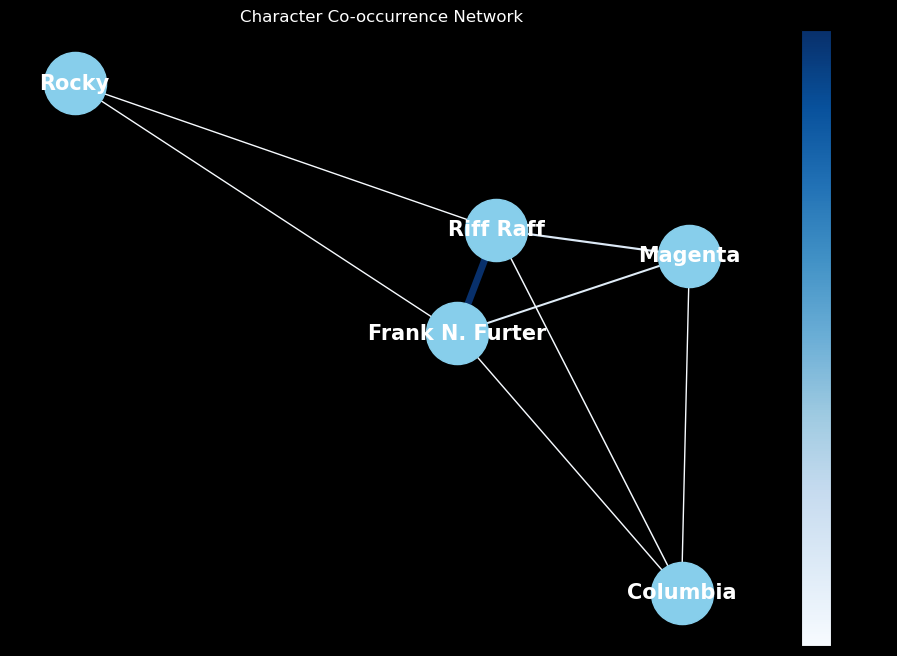

In [93]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/53459851_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##54502897_txt.txt

Sentence: Columbia gripped onto Magenta like her life depending on it, while her tears soaked the shoulder of her uniform.
Characters: ['Columbia', 'Magenta']
Score: 5

Sentence: Usually when Columbia cried, Magenta would hush her and move on.
Characters: ['Columbia', 'Magenta']
Score: 4

Sentence: Even when Columbia was basically thrown out by Frank when he found Eddie, she never sobbed.
Characters: ['Frank N. Furter', 'Columbia', 'Eddie']
Score: 3

Sentence: I guess that's where you could consider Magenta and Columbia similar.
Characters: ['Columbia', 'Magenta']
Score: 2

Sentence: It annoyed Magenta enough to the point she threatened to break Columbia's dance shoes (and doing so), which only led to Frank buying new ones.
Characters: ['Frank N. Furter', 'Columbia', 'Magenta']
Score: 13

Sentence: Riff Raff may not have been the biggest Columbia fan, but whether he liked her or not didn't matter.
Characters: ['Columbia', 'Riff Raff']
Score: 9

Sentence: She could absolutely care less 

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2401219674.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2401219674.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


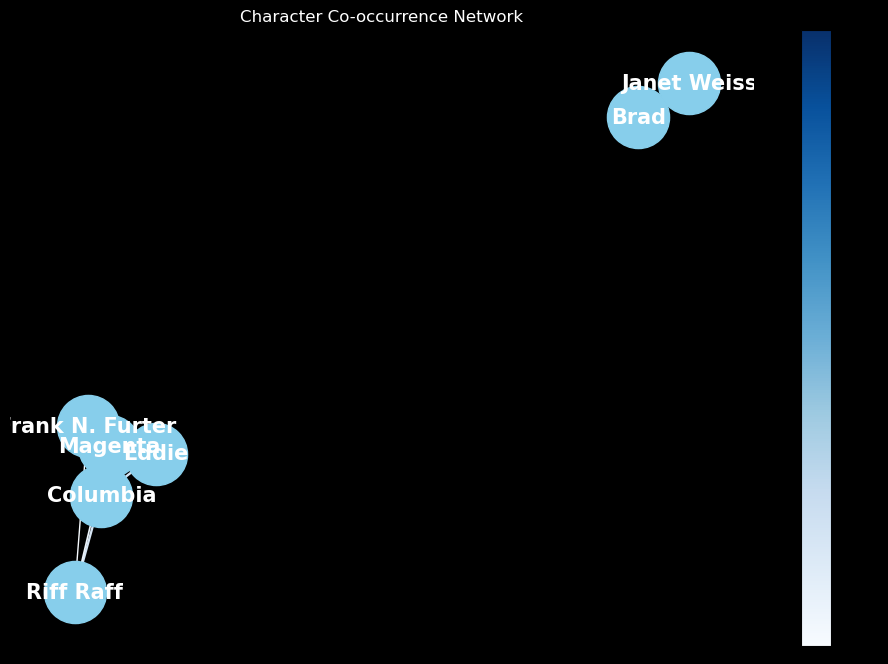

In [94]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/54502897_txt.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##5538284.txt

Sentence: I don't how Genta can cook with it!"

Magenta leaned against the door frame watching as Columbia tried to sigh only to end up coughing and waving smoke from her face unaware of the domestic.
Characters: ['Columbia', 'Magenta']
Score: 19

Sentence: I was going to decorate them and share them with you guys to kick off the Christmas week."

Magenta raised an eyebrow crossing her arms over her chest waiting for an explanation about this so called Christmas, but Columbia was to absorbed in pouting about the ruined cookies to see.
Characters: ['Columbia', 'Magenta']
Score: 29

Sentence: 1, 2, 3, 4, 5, 6...the sixth tole echoed through the house while a sigh filled the kitchen, if the old clock had tolled out 8 times then the pair would have found themselves in hot water because Frank would awaken and expect everyone to be up and doing their everyday tasks, Magenta silently wondered if her brother had already gone to the lab for the day.
Characters: ['Frank N. Furter', 'Magenta']
Sc

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4179711315.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4179711315.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


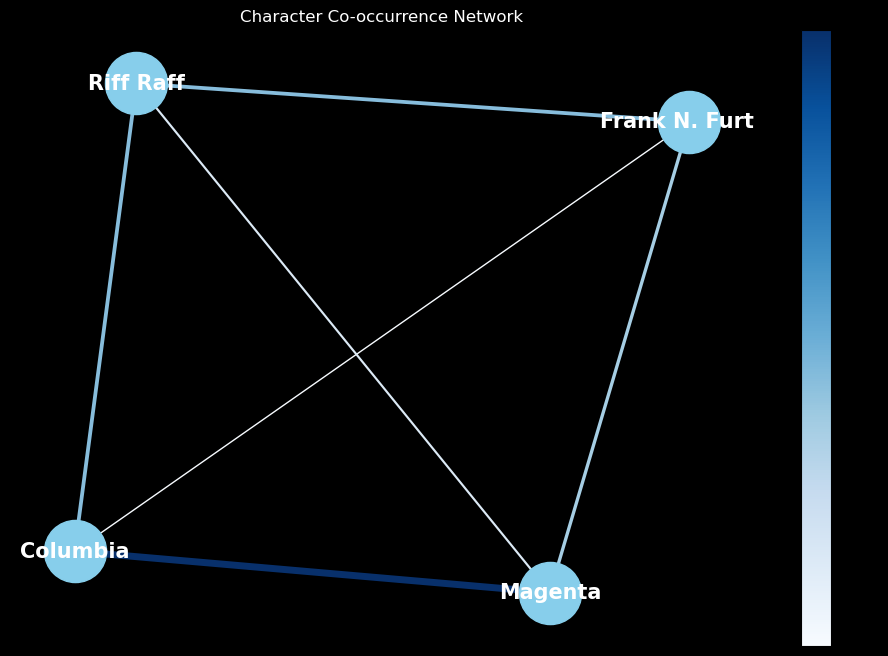

In [95]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/5538284.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##6030289.txt

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/659761930.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/659761930.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


Sentence: Of course, that wouldn't stop Frank from absolutely devouring every inch of newly engaged Brad Majors.
Characters: ['Frank N. Furter', 'Brad']
Score: 0

Sentence: Brad needed a mentor, and lucky him that Frank was there to do it.
Characters: ['Frank N. Furter', 'Brad']
Score: 5

Sentence: Brad was a piece of clay that Frank could play with and make whatever he wanted.
Characters: ['Frank N. Furter', 'Brad']
Score: 10

Sentence: He was tall, skinny, somewhat lanky, but Frank could see the outline of muscles as he caressed Brad's arms, chest, and stomach.
Characters: ['Frank N. Furter', 'Brad']
Score: 5

Sentence: Frank pressed his lips against Brad's skin all the way down to where Brad's boxers had begun to form a tent, only to be interrupted by the obnoxious alarm of the television.
Characters: ['Frank N. Furter', 'Brad']
Score: 4

Sentence: Frank only half-listened to Riff Raff, noting key words to understand that his creation had gotten loose, but the hounds had been sent a

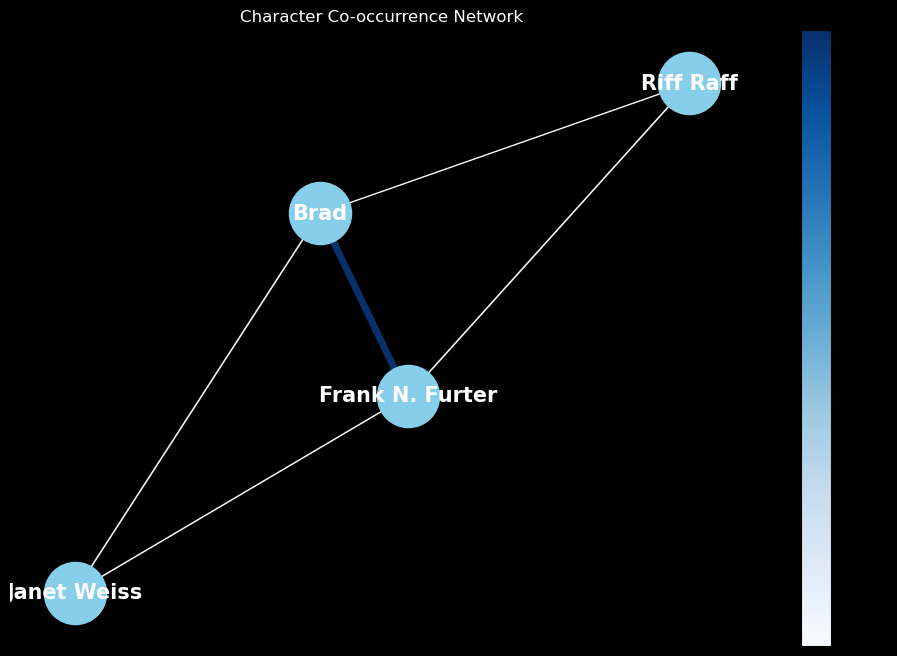

In [96]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/6030289.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##6323518.txt

Sentence: Introductions over with, I took the lift back up to the lab to prepare for the unveiling of my latest project and left the couple to follow with Magenta, Riff Raff and Columbia.
Characters: ['Columbia', 'Riff Raff', 'Magenta']
Score: 8

Sentence: Richard wrote the play, killing off myself, Columbia and my beloved Rocky.
Characters: ['Rocky', 'Columbia']
Score: 17

Sentence: Playmates came and went, though Rocky and Columbia were constant; Magenta and Riff Raff had their differences with me as usual and more than once I had some mad scheme that nearly ended in the destruction of the castle, if not the inhabitants.
Characters: ['Rocky', 'Columbia', 'Riff Raff', 'Magenta']
Score: 12



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/304367985.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/304367985.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


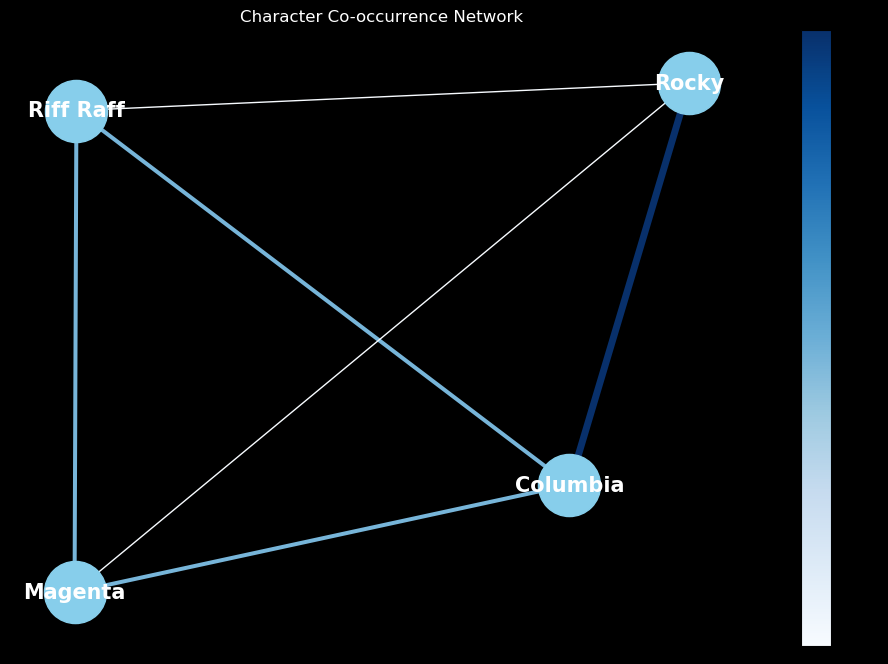

In [97]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/6323518.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##7523557.txt

Sentence: “Exactly Frank, we are back on Transexual and I could get in trouble if the wrong person seen me diverting from proper edicate.”

Frank waved the comment off smiling like a Cheshire Cat as he put a hand on Riff’s shoulder.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 24

Sentence: You started on a good day, we just had a new domestic start as well.”

Riff looked confused as he let Frank lead him out of the room with the girl following behind like a trained puppy.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 25

Sentence: Here is your first week's wage, you'll get paid every week and if you have more questions ask the others or I will pop in the labs from time to time.”

All Riff could do was nod not wanting to interrupt Frank who now looked over his shoulder at the girl who was standing quietly watching Riff with childish brown eyes, when Frank seen this he smiled wide again motioning her over to his side wrapping his arm around her shoulders.
Characters: ['Fran

/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1389868484.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/1389868484.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


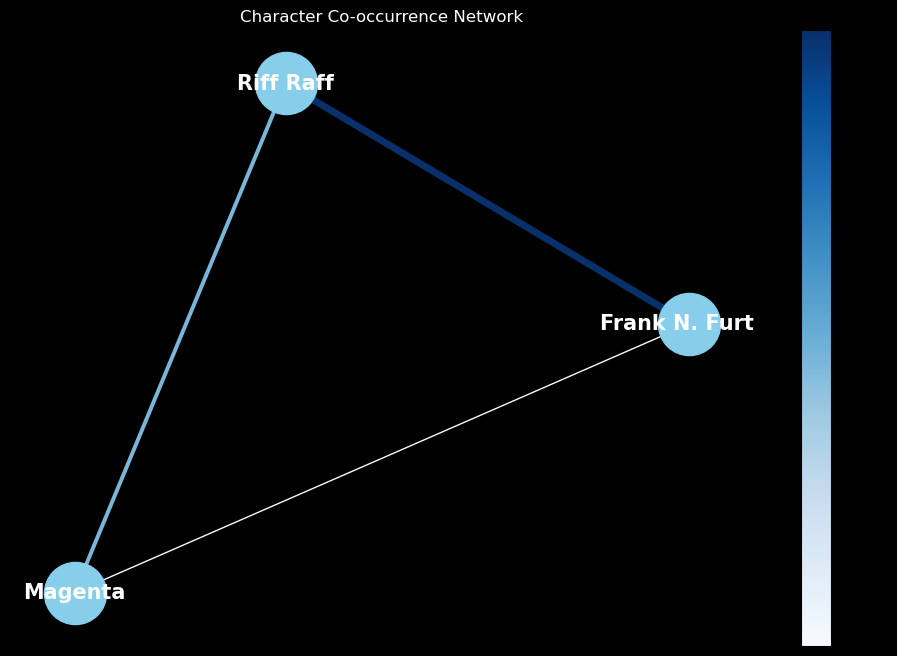

In [98]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/7523557.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##8186731.txt

Sentence: Then he gets to the files on a couple called Brad and Janet, who could only look more wholesome and normal were they to appear in the feature section of Better Homes and Gardens.
Characters: ['Janet Weiss', 'Brad']
Score: 7



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2084103508.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/2084103508.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


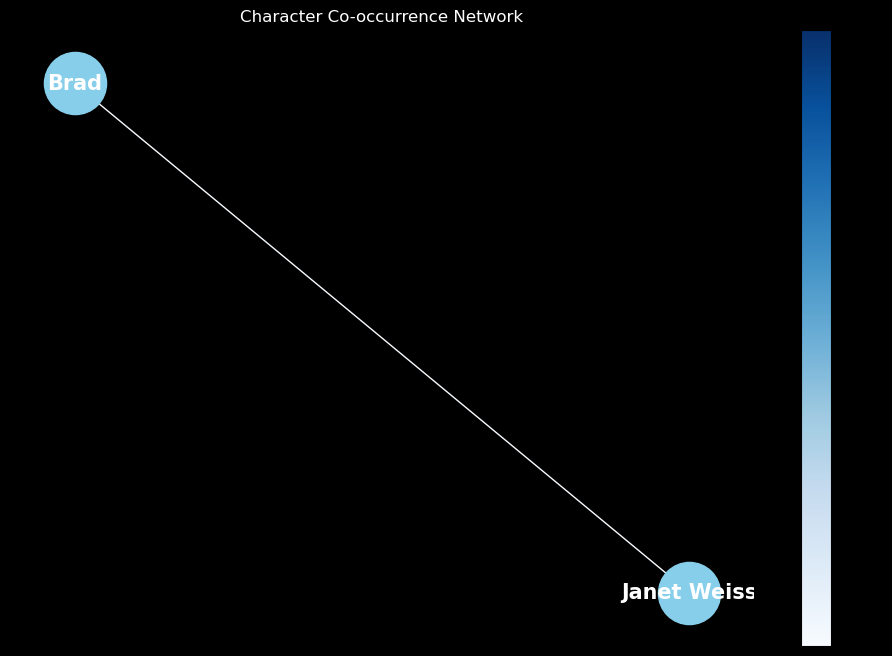

In [99]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/8186731.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()


In [ ]:
##9351971.txt

Sentence: Riff and Frankie have been caught in this cycle for a long time.
Characters: ['Frank N. Furter', 'Riff Raff']
Score: 4



/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4015936883.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)
/var/folders/m5/h2p0rblj3hl08svt7xvt760h0000gn/T/ipykernel_74235/4015936883.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Co-occurrence Weight')


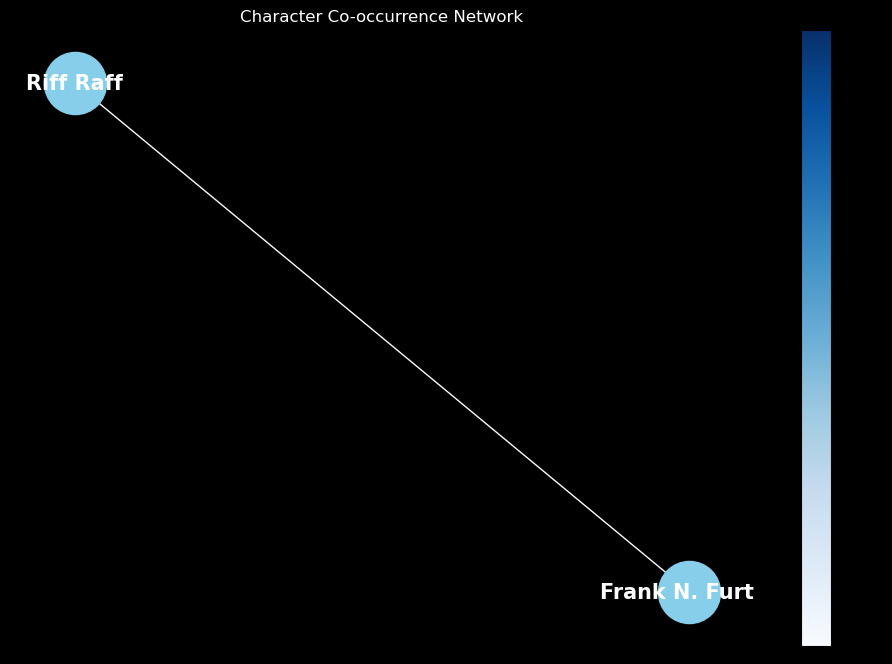

In [100]:
import re
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 读取文本文件，将句子存储在 DataFrame 中
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # 使用正则表达式来分割句子，考虑到感叹号、问号以及其他可以视作一个句子结束的标点符号
    sentences = re.split(r'(?<=[.!?])\s+', text)
    df = pd.DataFrame({'Sentence': sentences})
    return df

# 提取包含两个人物名称的句子
def extract_sentences_with_multiple_names(df, names_variants_dict):
    all_variants = [variant for variants in names_variants_dict.values() for variant in variants]
    name_combinations = [(name1, name2) for name1 in all_variants for name2 in all_variants if name1 != name2]
    pattern = '|'.join([f"{re.escape(name1)}.*{re.escape(name2)}|{re.escape(name2)}.*{re.escape(name1)}" for name1, name2 in name_combinations])
    name_sentences = df[df['Sentence'].str.contains(pattern, na=False)]
    return name_sentences

# 加载人物名称变体字典
def load_names_variants_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        names_variants_dict = json.load(file)
    return names_variants_dict

# 加载动词-分数字典
def load_verb_score_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        verb_score_dict = json.load(file)
    return verb_score_dict

# 给每个句子打分
def score_sentences(name_sentences, verb_score_dict):
    scores = []
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        sentence_score = 0
        for verb, score in verb_score_dict.items():
            if verb in sentence:
                sentence_score += score
        scores.append(sentence_score)
    return scores

# 提取句子中出现的人物名称
def extract_names_in_sentence(sentence, names_variants_dict):
    all_variants = {variant: name for name, variants in names_variants_dict.items() for variant in variants}
    names_in_sentence = set()
    for variant, name in all_variants.items():
        if variant in sentence:
            names_in_sentence.add(name)
    return list(names_in_sentence)

# 构建共现网络并可视化
def visualize_cooccurrence_network(name_sentences, names_variants_dict):
    G = nx.Graph()
    
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        score = row['Score']
        characters = extract_names_in_sentence(sentence, names_variants_dict)
        
        if len(characters) > 1:
            for i in range(len(characters)):
                for j in range(i + 1, len(characters)):
                    char1, char2 = characters[i], characters[j]
                    if G.has_edge(char1, char2):
                        G[char1][char2]['weight'] += score
                    else:
                        G.add_edge(char1, char2, weight=score)
    
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
    edge_widths = [1 + 4 * norm(weight) for weight in weights]
    
    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')
    
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='white', font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Co-occurrence Weight')
    
    plt.title('Character Co-occurrence Network', color='white')
    plt.axis('off')
    plt.show()

# 主程序
def main():
    # 读取文本文件
    text_df = read_text_file('/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/9351971.txt')

    # 读取人物名称变体
    names_variants_dict = load_names_variants_dict('character_variants_RHPS.json')

    # 识别文章中所有出现两个人物及以上的句子
    name_sentences = extract_sentences_with_multiple_names(text_df, names_variants_dict)

    # 加载动词-分数字典
    verb_score_dict = load_verb_score_dict('verbs_cater_score.json')

    # 给每个句子打分
    name_sentences['Score'] = score_sentences(name_sentences, verb_score_dict)

    # 打印每个句子中出现的人物名称及其分数
    for index, row in name_sentences.iterrows():
        sentence = row['Sentence']
        names_in_sentence = extract_names_in_sentence(sentence, names_variants_dict)
        print(f"Sentence: {sentence}")
        print(f"Characters: {names_in_sentence}")
        print(f"Score: {row['Score']}")
        print()

    # 可视化共现网络
    visualize_cooccurrence_network(name_sentences, names_variants_dict)

if __name__ == "__main__":
    main()
